In [58]:
# import the required python modules

import numpy as np
import autograd.numpy as npa
from autograd.numpy import pi, real, conj

import matplotlib as mpl
mpl.rcParams['figure.dpi']=100

import matplotlib.pylab as plt

from autograd.scipy.signal import convolve as conv
from scipy.interpolate import RegularGridInterpolator

import ceviche
from ceviche import fdfd_ez, jacobian
from ceviche.optimizers import adam_optimize

from random import random

In [59]:
from ceviche_utilities import *

In [60]:
# constants

EPSILON_0 = 8.85418782e-12              # vacuum permittivity
MU_0 = 1.25663706e-6                    # vacuum permeability
C_0 = 1 / np.sqrt(EPSILON_0 * MU_0)     # speed of light in vacuum
Q_e = 1.602176634e-19                   # funamental charge

In [61]:
def pxl(x):
    '''converts meters to pixels (dl)'''
    return int(x/dl)

In [62]:
def viz_epsr_rho(epsr, rho):
    fig, axs = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(12, 3), dpi=200, tight_layout=True)
    er = axs[0].imshow(epsr.T, cmap='Greys', origin='lower')
    rh = axs[1].imshow(np.real(rho).T, cmap='Greys', origin='lower', vmin=0, vmax=1)

    # text
    axs[0].text(10, Ny - Ny//5, r"$\varepsilon_r$", fontsize=20)
    axs[1].text(10, Ny - Ny//5, r"$\rho$", fontsize=20)

    # colorbars
    cbar_er = plt.colorbar(er, ax=axs[0], orientation="horizontal", aspect=20)
    plt.colorbar(rh, ax=axs[1], orientation="horizontal", aspect=20)
    plt.show()

In [63]:
def callback_output_structure(iteration, of_list, rho):
    """Callback function to output fields and the structures (for making sweet gifs)"""
    rho = rho.reshape((Nx, Ny))
    epsr = epsr_parameterization(
        rho, bg_rho, design_region, epsr_min, epsr_max, radius=blur_radius, N_blur=N_blur, beta=beta_proj, eta=eta_proj, N_proj=N_proj)
    
    viz_epsr_rho(epsr, rho)
    # np.savetxt(f"saved_structures\\schedule\\{iteration}.txt", epsr)
    np.savetxt(f"saved_structures\\schedule\\rho_{iteration}.txt", rho)


def callback_beta_schedule(iteration, of_list, rho):
    """Callback function for the optimizer to schedule changes to beta with the iteration number"""
    
    global beta_proj

    if iteration < 50:
        beta_proj = 10
    elif 50 <= iteration & iteration < 75:
        beta_proj = 100
    elif 75 <= iteration & iteration < 100:
        beta_proj = 200
    else:
        beta_proj = 300

    # Chain with the output structure callback
    callback_output_structure(iteration, of_list, rho)

In [64]:
def mask_combine_epsr(epsr, bg_epsr, base_region):
    """Utility function for combining the design region epsr and the background epsr
    """
    return bg_epsr*base_region + epsr*(base_region == 0).astype(float)


def epsr_parameterization(rho, bg_rho, design_region, epsr_min, epsr_max, radius=1, N_blur=1, beta=100, eta=0.5, N_proj=1):
    """Defines the parameterization steps for constructing rho
    """
    # Combine rho and bg_rho
    rho = mask_combine_rho(rho, bg_rho, design_region)

    rho_blur = operator_blur(npa.concatenate((rho[:,Ny//2:], rho ,rho[:, :Ny//2]), axis=1), radius=radius, N=N_blur)
    rho = rho_blur[:, (rho_blur.shape[1])//4:(3*rho_blur.shape[1]//4)]
    rho = operator_proj(rho, beta=beta, eta=eta, N=N_proj)

    epsr = epsr_min + (epsr_max-epsr_min) * rho

    # Final masking (SiO2 base)
    epsr = mask_combine_epsr(epsr, val_epsr_Si, base_region)

    return epsr

In [65]:
def viz_epsr(epsr):
    ceviche.viz.real(epsr, cbar=True, cmap='jet', DK_title='epsr', DK_min=1, DK_max=5/4*val_epsr_Si)

## iSPR&CDR inverse design for 1/2/3/5 frequencies 
(numerical aperture 0.22)

In [66]:
# parameters

################################################################################
# optimization
Nsteps = 100         # Number of epochs in the optimization 
step_size = 1e-2    # Step size for the Adam optimizer

################################################################################
# epsilon parametrization
blur_radius = 4       # Radius of the circle for the conv kernel filter
N_blur = 2            # Number of times to apply the filter
beta_proj = 200       # Strength of the projection
eta_proj = 0.5        # Center of the projection between 0 and 1
N_proj = 1            # Number of times to apply the projection

################################################################################
# geometry

a = 240e-9          # grating period (in m)
F = 0.7             # grating fill factor
h = 400e-9          # grating tooth height
d = 20e-9           # impact parameter
base = 100e-9       # grating base height
xR_PML = 150e-9     # distance from the right PML to the bottom of the grating
xL_PML = 150e-9     # distance from the left PML to the electron path
detector = 100e-9   # separation between the detectors and the PMLs

################################################################################
# FD simulation parameters

dl = 4e-9            # element size (in m) # Note: use dl>2 only for a quick check
Npml = 20            # Size of the PML boundaries in pixels 

# Simulation domain size (in number of pixels)
Nx = int((xR_PML + xL_PML + base + h + d) / dl) + 2*Npml + 1
Ny = int(a / dl) + 1
   
################################################################################
# material

nSi = 3.727                 # refractive index of Si
nSiO2 = 1.455               # refractive index of SiO2
val_epsr_Si = nSi**2        # relative permittivity of Si
val_epsr_SiO2 = nSiO2**2    # relative permittivity of SiO2

################################################################################
# electron beam

beta = 0.32838       # electron relative velocity
sigma_x = 3e-9       # electron beam sigma_x  

################################################################################
# radiation

# frequencies = 2*pi * np.array((3.89e+14, 4.00e+14, 4.12e+14, 4.24e+14, 4.36e+14))
# frequencies = 2*pi * np.array((3.89e+14, 4.12e+14, 4.36e+14))
frequencies = 2*pi * np.array((4.00e+14, 4.24e+14))
# frequencies = [2*pi * 4.12e+14]


################################################################################

In [67]:
# Initialize relative permittivity of the domain
# epsr = np.ones((Nx, Ny))
rho = np.zeros((Nx, Ny))
bg_rho = np.zeros((Nx, Ny))

epsr_min = 1
epsr_max = val_epsr_Si

#################################################
# grating for Smith-Purcell

x1 = Npml + pxl(xL_PML + d)
x2 = Npml + pxl(xL_PML + d + h)
y1 = int(Ny/2*(1-F))
y2 = int(Ny/2*(1-F) + F*Ny)
rho[x2:Nx, :]  = 2*eta_proj #+ 0.1 * (2 * np.random.random(rho[x2:Nx, :].shape) - 1)
for x in range(x1, x2):
    for y in range(Ny):
        if x > x1 + pxl(180e-9):
            rho[x, y] = eta_proj + 0.05 * random() + 0.05
        else:
            rho[x, y] = eta_proj - 0.05 * random() - 0.05
    for y in range(y1, y2):
        rho[x, y] = eta_proj + 0.05 * random() + 0.05
#################################################

# Region within which the permittivity is allowed to change
design_region = np.zeros((Nx, Ny))
design_region[x1:x2, :] = 1
bg_rho[x2:Nx, :] = 1

# SiO2 base
base_region = np.zeros((Nx, Ny))
base_region[x2:Nx, :] = 1

rho_initial = rho

In [68]:
epsr = epsr_parameterization(
    rho, bg_rho, design_region, epsr_min, epsr_max, radius=blur_radius, N_blur=N_blur, beta=beta_proj, eta=eta_proj, N_proj=N_proj)

<AxesSubplot:xlabel='x', ylabel='y'>

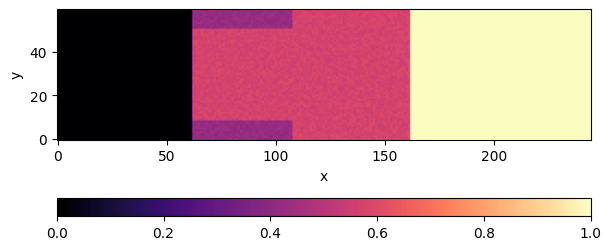

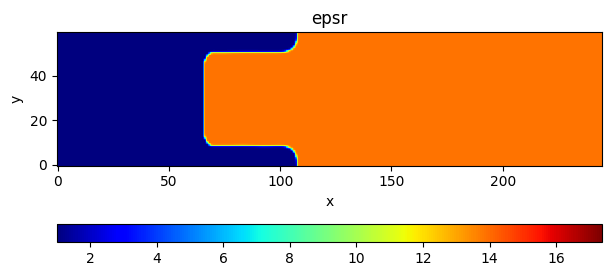

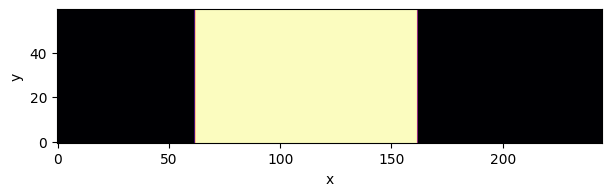

In [69]:
ceviche.viz.abs(rho, cbar=True)
viz_epsr(epsr)
ceviche.viz.abs(design_region)

In [70]:
def J(x, y, omega, v, sigma_x, d):
    '''Electric current density'''

    x *= dl
    y *= dl


    j = -Q_e / (4*pi * d) / np.sqrt(2*pi* sigma_x **2) * np.exp(-x**2/(2*sigma_x**2)) * np.exp(-1j * omega/v * y)
    
    return j

In [71]:
current_list = []

for omega in frequencies:
    current = np.zeros((Nx, Ny), dtype=np.complex128)
    for x in range(Nx):
        for y in range(Ny):
            current[x,y] = J(x - (Npml + xL_PML / dl), y, omega=omega, v=beta*C_0, sigma_x=sigma_x, d=0.5e-9)
    current_list.append(current)

<AxesSubplot:title={'center':'J_y'}, xlabel='x', ylabel='y'>

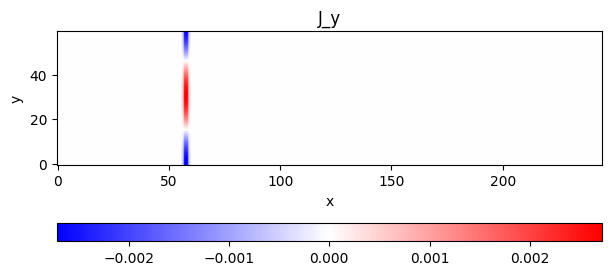

In [72]:
# ceviche.viz.abs(current, cbar=True)
ceviche.viz.real(current_list[0], DK_title='J_y', cbar=True, cmap='bwr')

In [73]:
# Create the simulation object for 'Hz' (TM) polarization
simulations_list = []

for omega in frequencies:
    simulation = ceviche.fdfd_hz(omega, dl, epsr, [Npml, 0], bloch_phases=[0, -(omega/(beta*C_0)*a)])
    simulations_list.append(simulation)

In [74]:
source_tmp_list = []

for current in current_list:
    source_tmp = np.zeros((Nx, Ny), dtype=np.complex128)
    source_tmp = np.reshape(simulation.Dxb.dot(current.flatten() / (-EPSILON_0 * 1j * omega)), (Nx, Ny))
    source_tmp[design_region == 1] = 0

    source_tmp_list.append(source_tmp)

In [75]:
# Run the simulation with the given source
Ex_list = []
Ey_list = []
Hz_list = []

for source_tmp, simulation in zip(source_tmp_list, simulations_list):
    Ex, Ey, Hz = simulation.solve(source_tmp)

    Ex_list.append(Ex)
    Ey_list.append(Ey)
    Hz_list.append(Hz)

for i in range(len(Ey_list)):
    for current, omega in zip(current_list, frequencies):
        Ey_list[i] = Ey_list[i] - current / (EPSILON_0 * 1j * omega)

<AxesSubplot:title={'center':'Hz'}, xlabel='x', ylabel='y'>

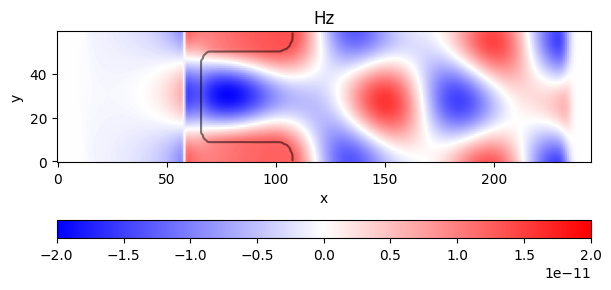

In [76]:
# Visualize the real value of the _ field component
# ceviche.viz.real(Ey_list[0], DK_title='Ey', outline=epsr, cbar=True)
ceviche.viz.real(Hz_list[0], DK_title='Hz', DK_max=2e-11, outline=epsr, cbar=True, cmap='bwr')

### Poynting vector

In [77]:
Sx_list = []
Sy_list = []

for Ey, Hz in zip(Ey_list, Hz_list):
    Sx =  4*2*pi * real( 1/2 * Ey * conj(Hz))
    Sx_list.append(Sx)

for Ex, Hz in zip(Ex_list, Hz_list):
    Sy =  4*2*pi * real(-1/2 * Ex * conj(Hz))
    Sy_list.append(Sy)

In [78]:
# detector position
det_x = int(Nx * 0.9) - Npml
print(f'detector position: X = {det_x}')


# the energy flux through the detector
def energy_flux(Sx, det_x):
    return npa.sum(Sx[det_x, :]*dl)

# long_det_left = x1+int(h/dl)
# def longitudinal_energy_flux(Sy):
#     return npa.sum(Sy[long_det_left:Nx, Ny-1]*dl)

detector position: X = 200


In [79]:
def mode(m, x, omega, H, n):
    k = omega/(beta*C_0)

    integral = 0
    for yy in range(0, H.shape[1]):
        dy = a / H.shape[1]
        integral += np.exp(1j * (k - (2*pi * m / a)) * yy*dy) * H[x, yy] * dy

    return integral * np.exp((x*dl) * np.sqrt(0j + (k - (2*pi * m / a))**2 - (n*omega/C_0)**2))

In [80]:
norm = npa.sum([npa.abs(mode(1, int(x2+80e-9/dl), frequencies[i], Hz_list[i], nSi))**2 for i in range(len(frequencies))])
print(norm)
print(int(x2+80e-9/dl))

5.284503121177544e-36
182


In [81]:
# optimal energy flux for F=0.7, h=180 for 5 frequencies
rect_optimum = 3.3266573041100787e-35
print(norm/rect_optimum)

0.15885324630969802


### Objective function

In [82]:
# optimize the average energy flux
def objective_average(rho):
    rho = rho.reshape((Nx, Ny))
    epsr = epsr_parameterization(
        rho, bg_rho, design_region, epsr_min, epsr_max, radius=blur_radius, N_blur=N_blur, beta=beta_proj, eta=eta_proj, N_proj=N_proj)

    energy_flux_list = []

    for i, simulation in enumerate(simulations_list):
        simulation.eps_r = epsr
        _, Ey, Hz = simulation.solve(source_tmp_list[i])
        
        # m=1 only
        energy_flux_list.append(npa.abs(mode(1, int(x2+80e-9/dl), frequencies[i], Hz, nSi)) **2)

    return  npa.sum(energy_flux_list) / rect_optimum

In [83]:
# optimize the minimum energy flux
def objective_min(rho):
    rho = rho.reshape((Nx, Ny))
    epsr = epsr_parameterization(
        rho, bg_rho, design_region, epsr_min, epsr_max, radius=blur_radius, N_blur=N_blur, beta=beta_proj, eta=eta_proj, N_proj=N_proj)

    energy_flux_list = []

    for i, simulation in enumerate(simulations_list):
        simulation.eps_r = epsr
        _, Ey, Hz = simulation.solve(source_tmp_list[i])
        
        # m=1 only
        energy_flux_list.append(npa.abs(mode(1, int(x2+80e-9/dl), frequencies[i], Hz, nSi)) **2)

    return  npa.min(energy_flux_list) / rect_optimum 


In [84]:
def objective(rho):
    # return objective_min(rho)
    return objective_average(rho)

### Optimization

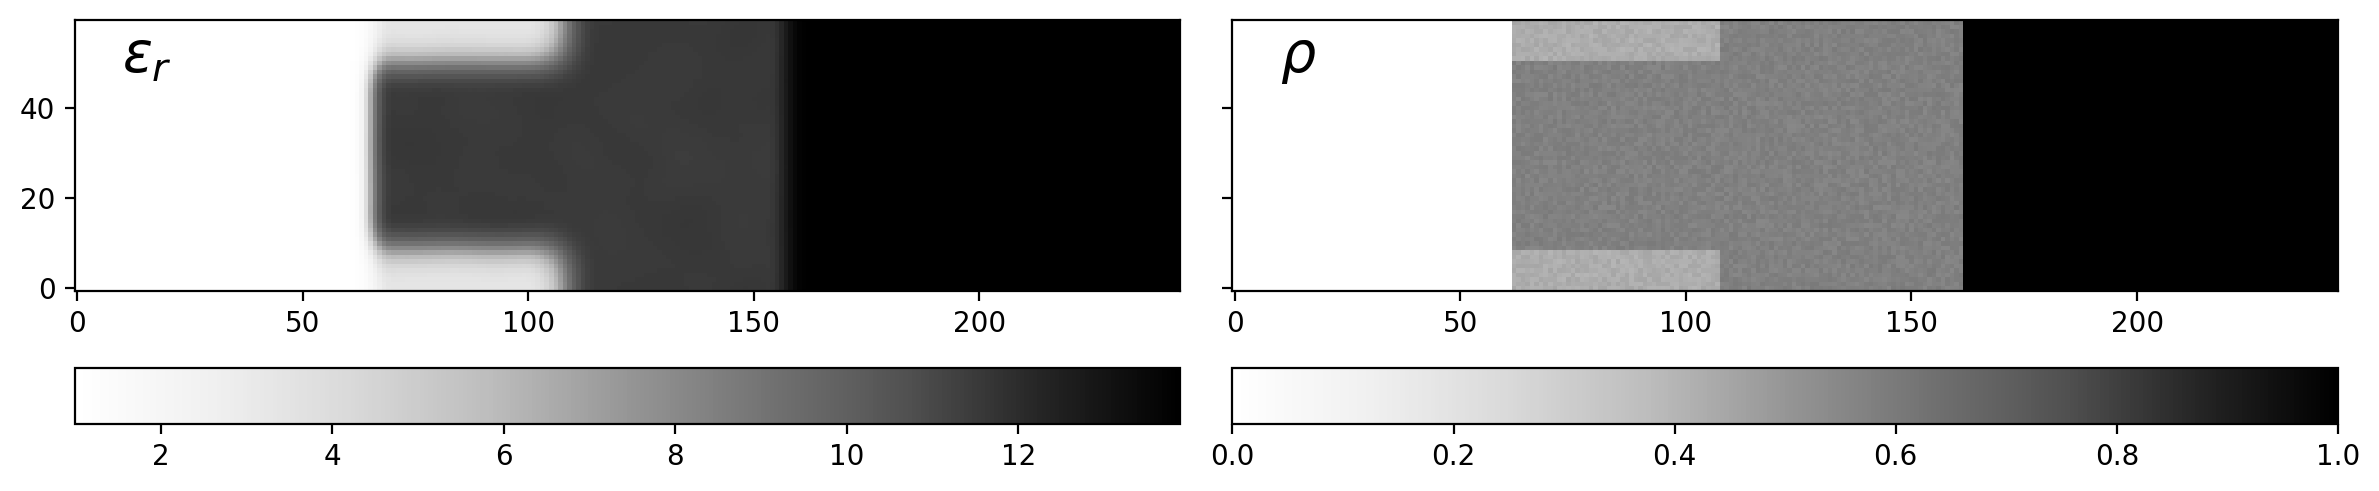

Epoch:   1/100 | Duration: 5.72 secs | Value: 1.271483e-02


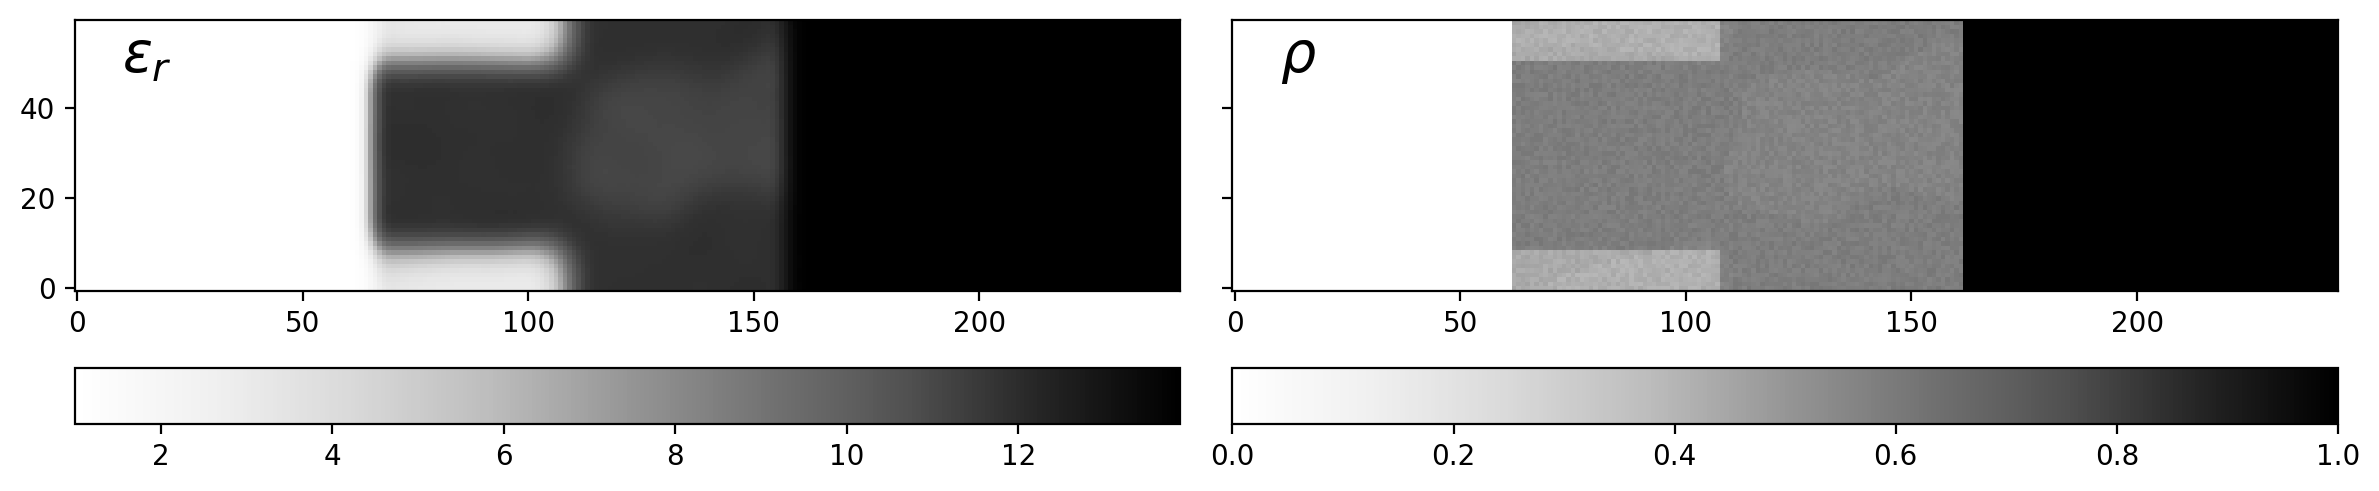

Epoch:   2/100 | Duration: 5.65 secs | Value: 2.939846e-02


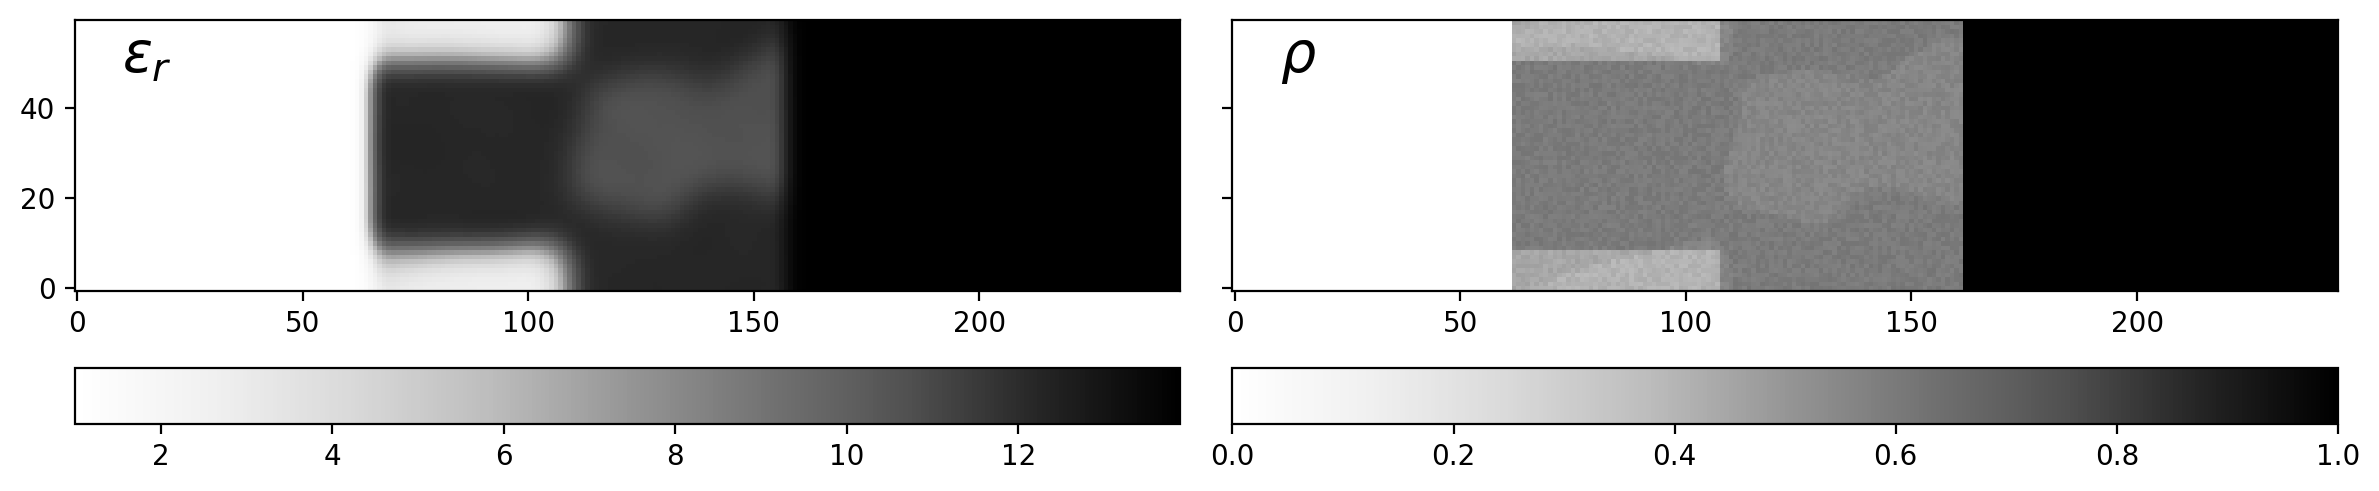

Epoch:   3/100 | Duration: 5.06 secs | Value: 5.380772e-02


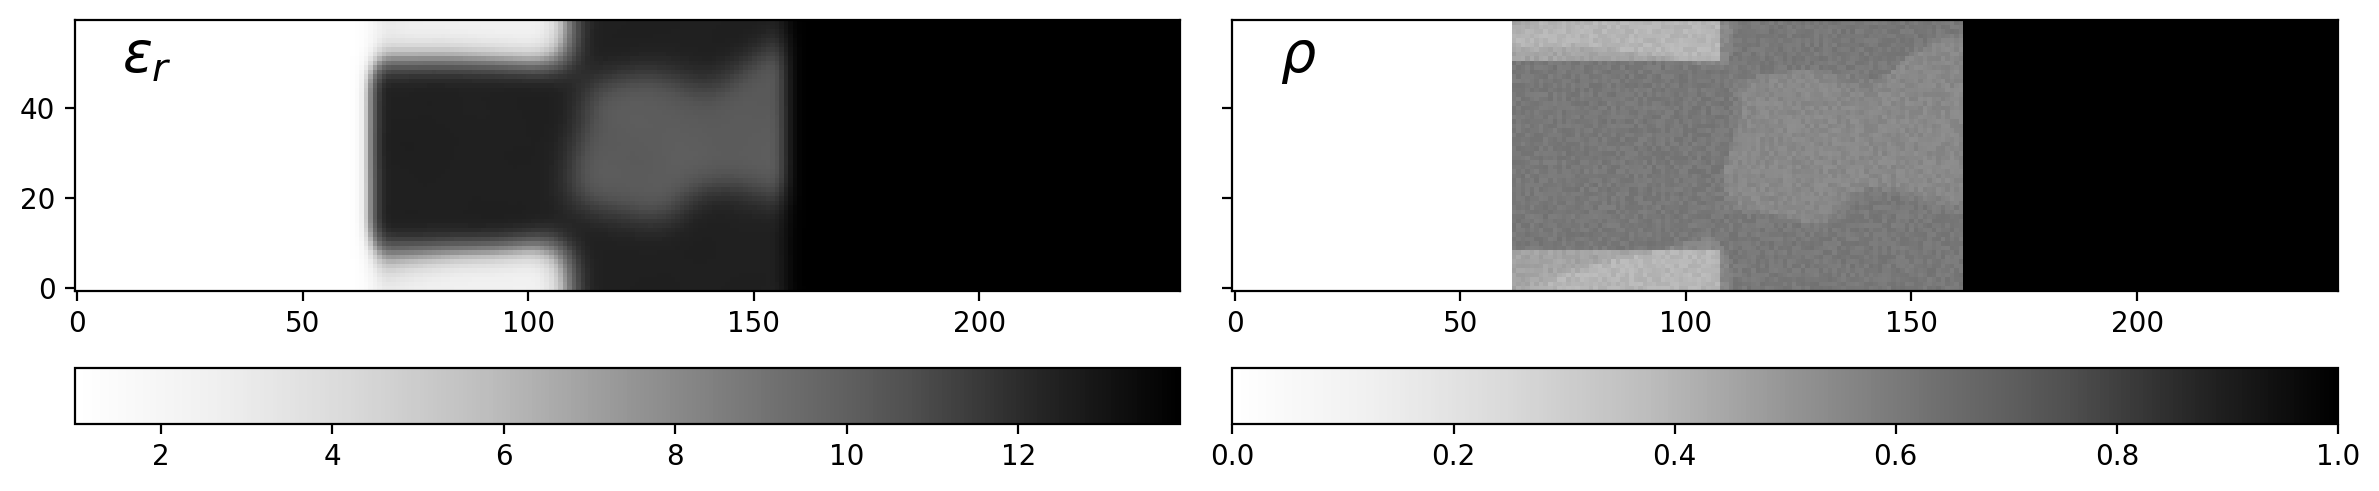

Epoch:   4/100 | Duration: 5.46 secs | Value: 8.589829e-02


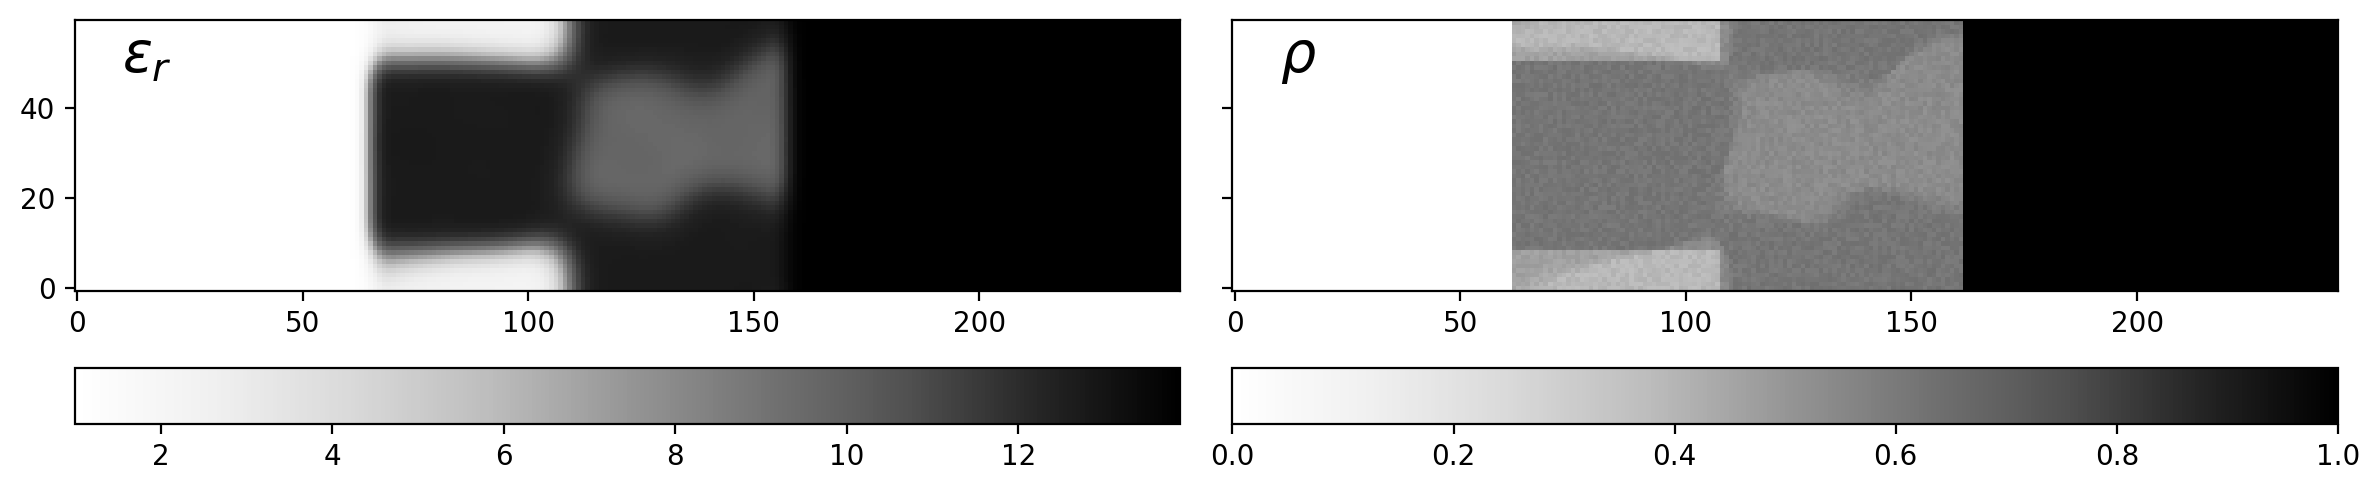

Epoch:   5/100 | Duration: 5.68 secs | Value: 1.258355e-01


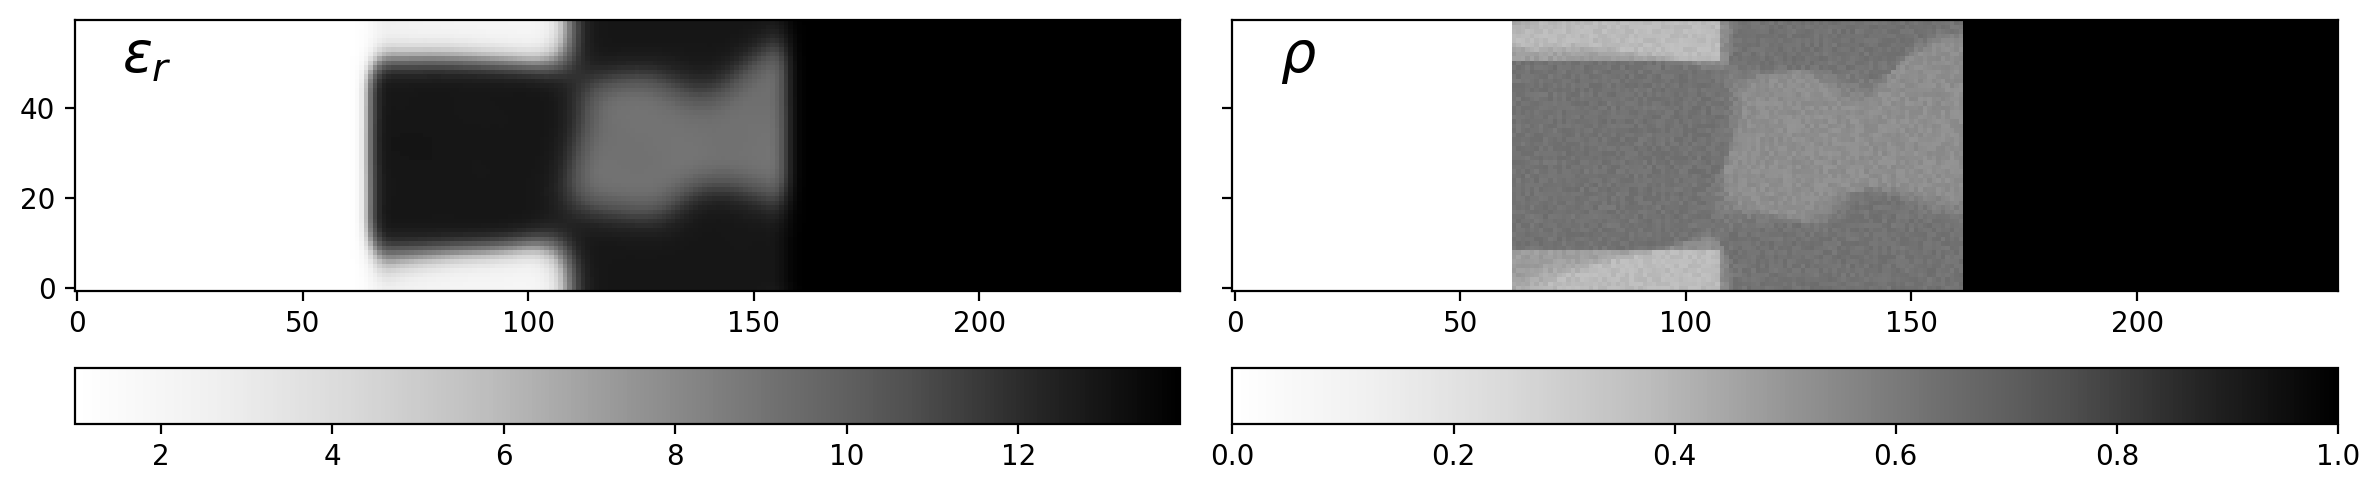

Epoch:   6/100 | Duration: 5.91 secs | Value: 1.739614e-01


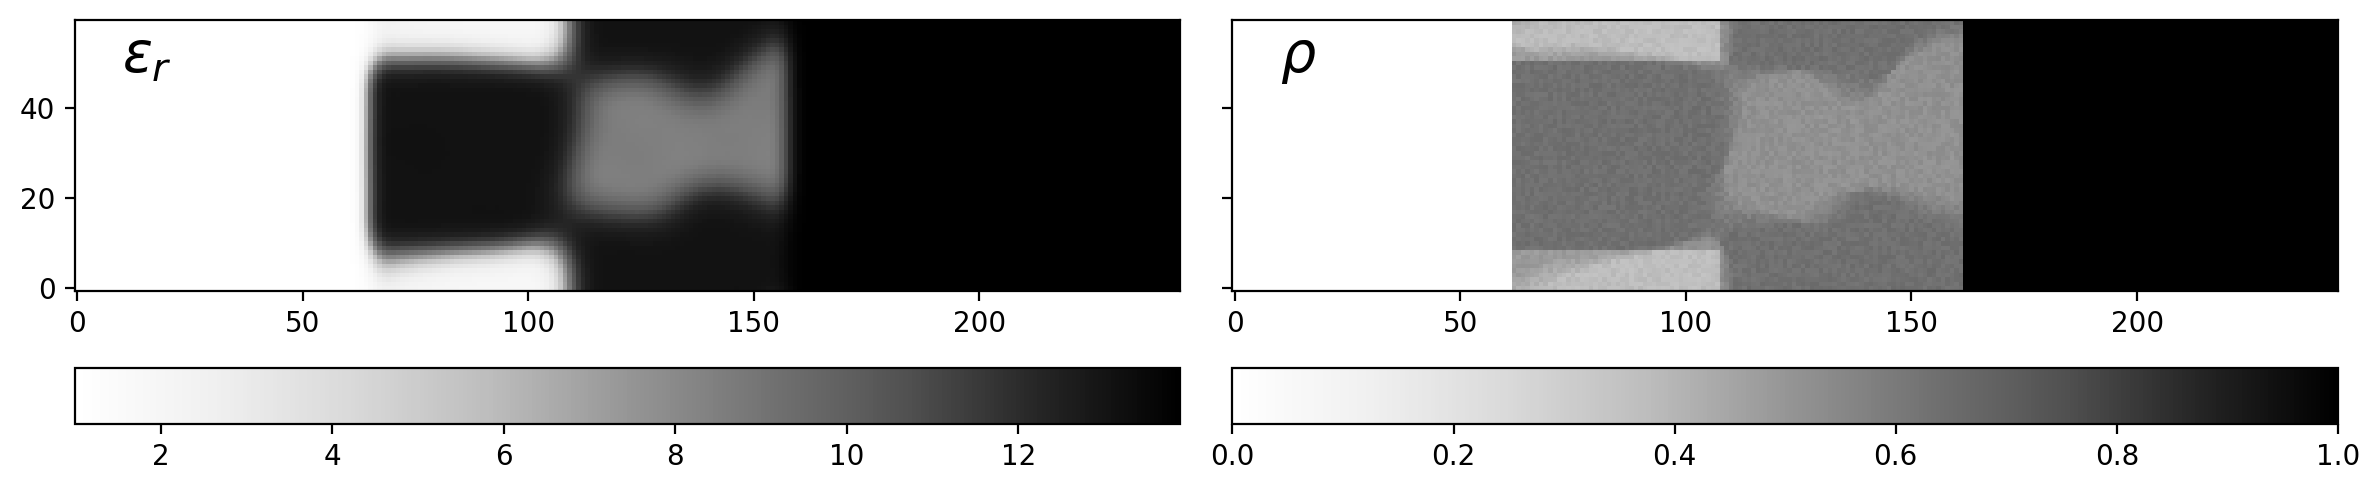

Epoch:   7/100 | Duration: 5.88 secs | Value: 2.301597e-01


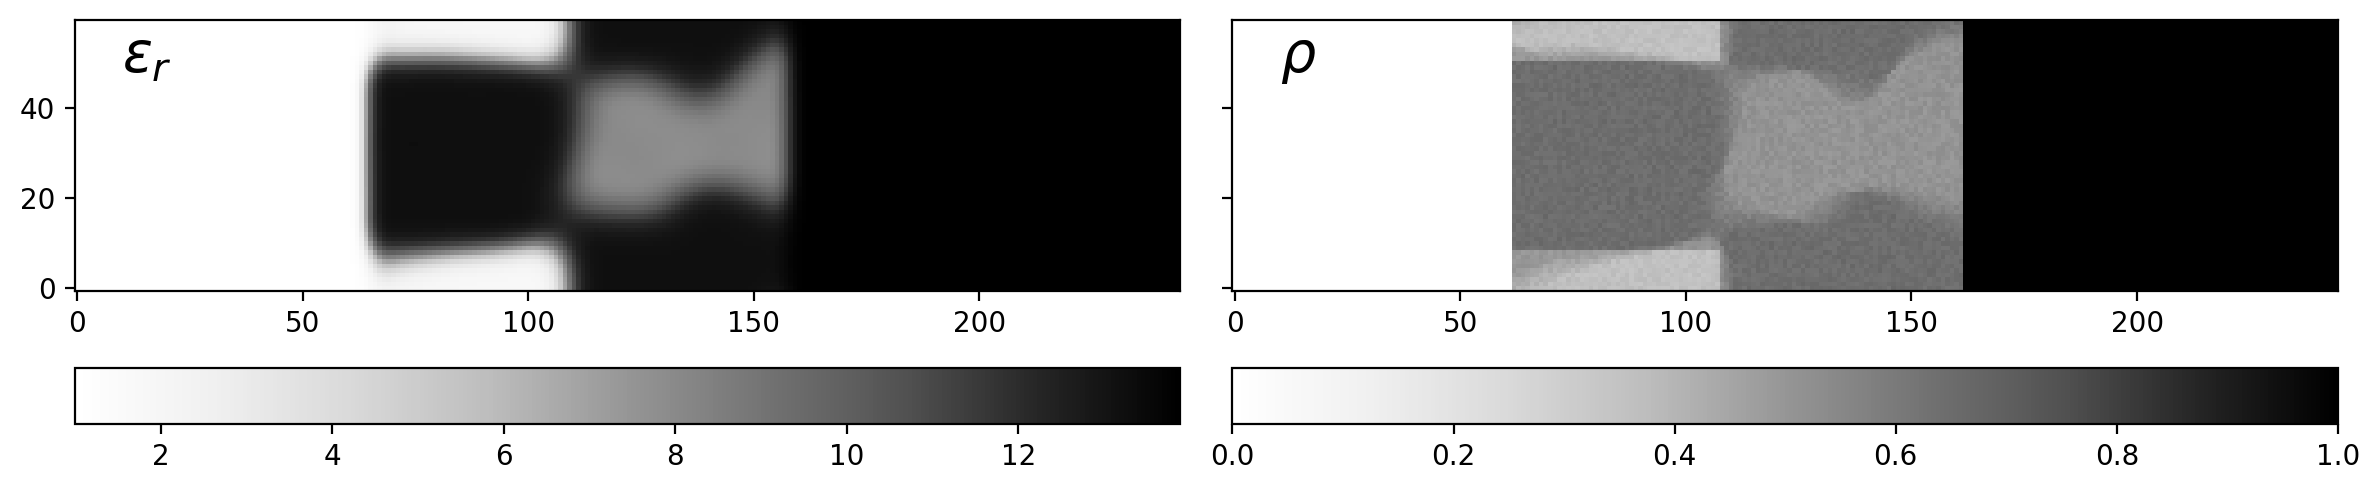

Epoch:   8/100 | Duration: 5.50 secs | Value: 2.933391e-01


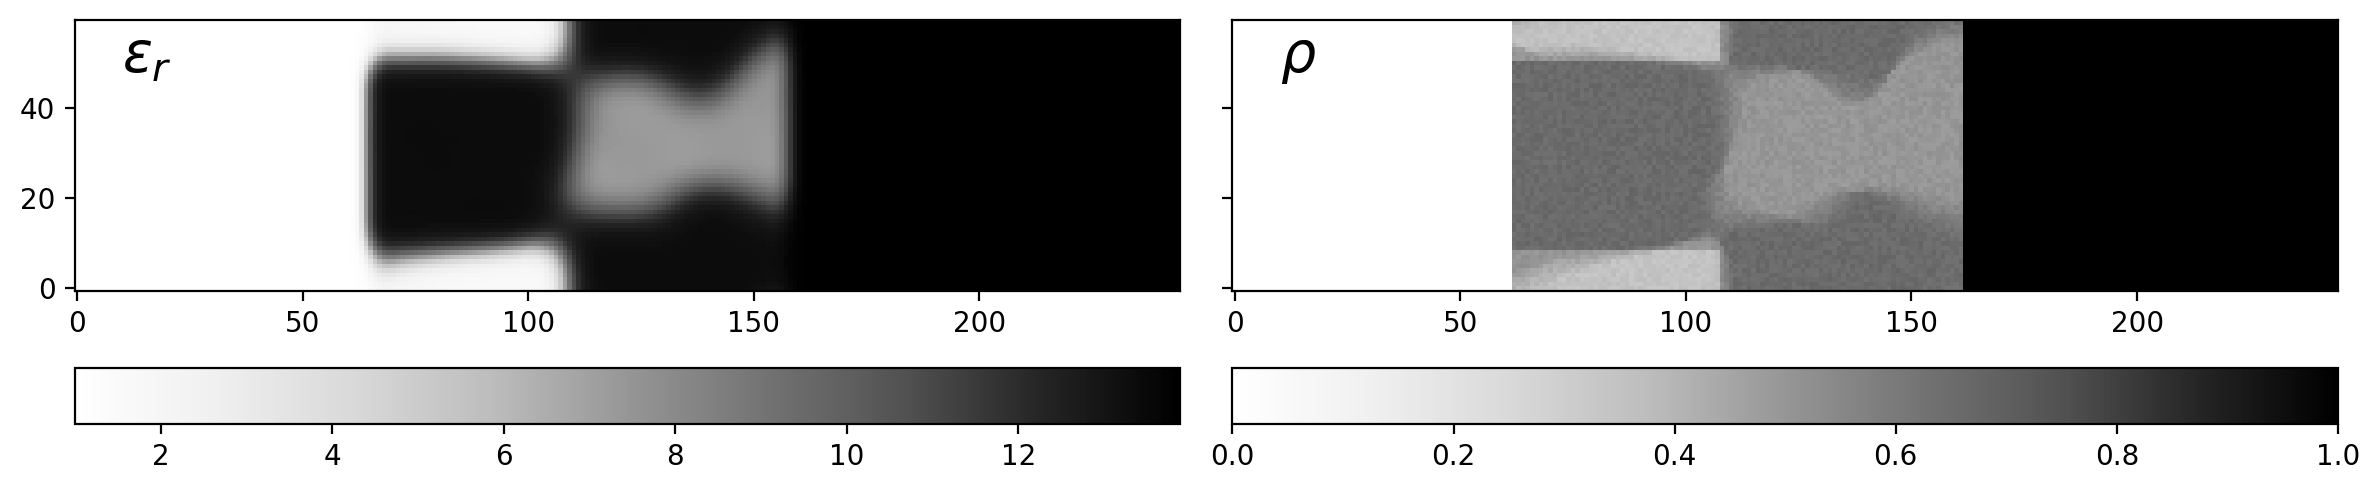

Epoch:   9/100 | Duration: 5.56 secs | Value: 3.623948e-01


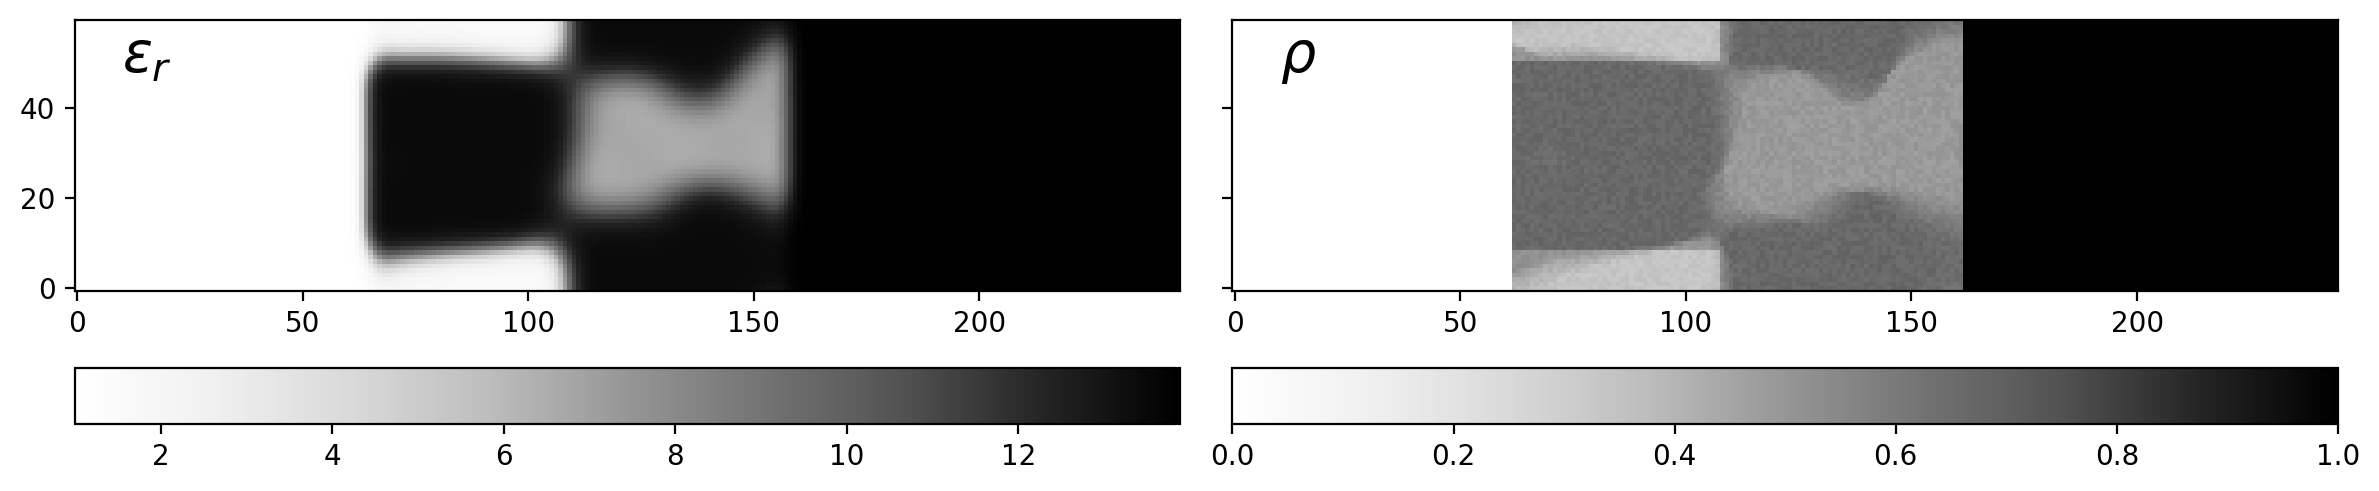

Epoch:  10/100 | Duration: 5.87 secs | Value: 4.379358e-01


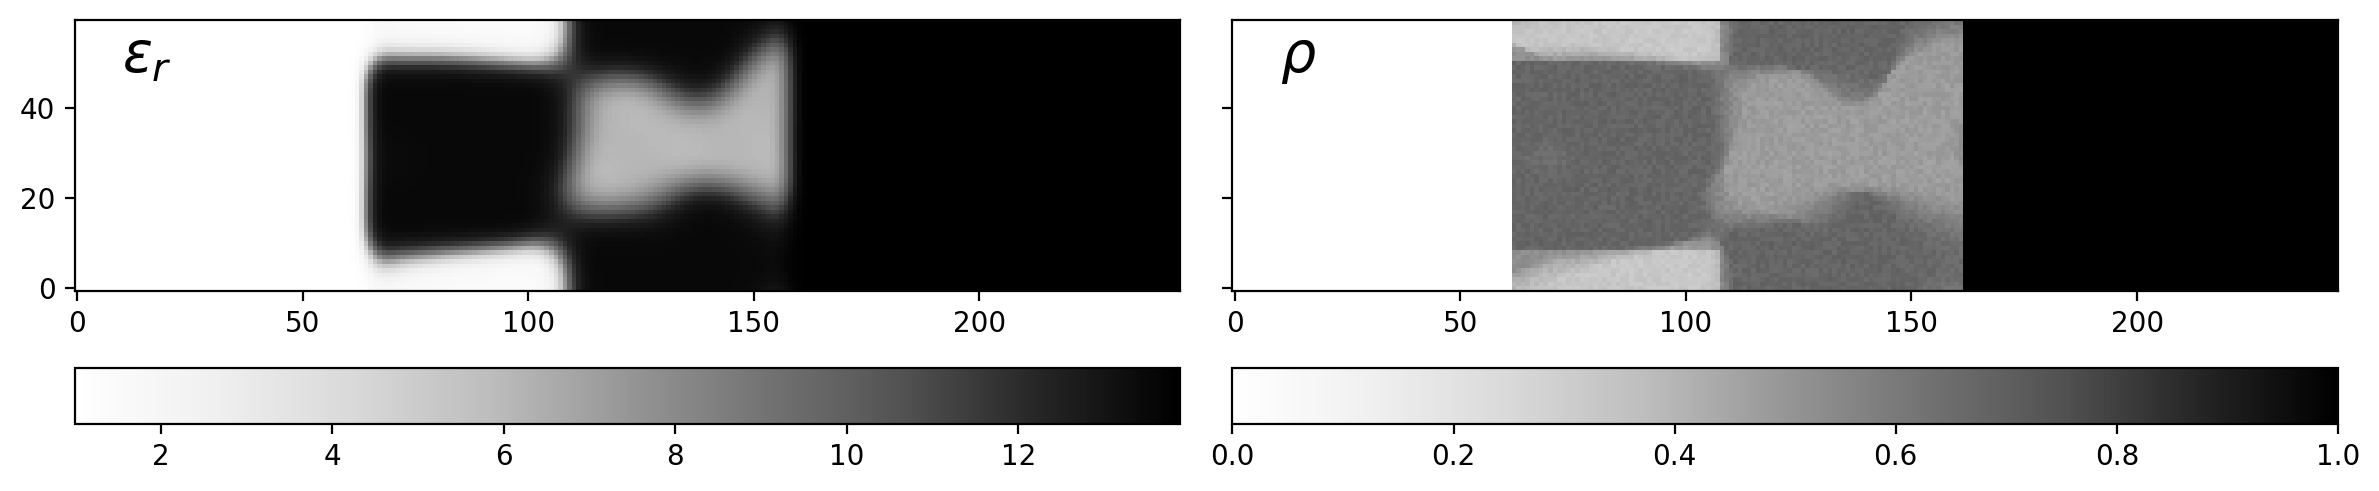

Epoch:  11/100 | Duration: 5.69 secs | Value: 5.215911e-01


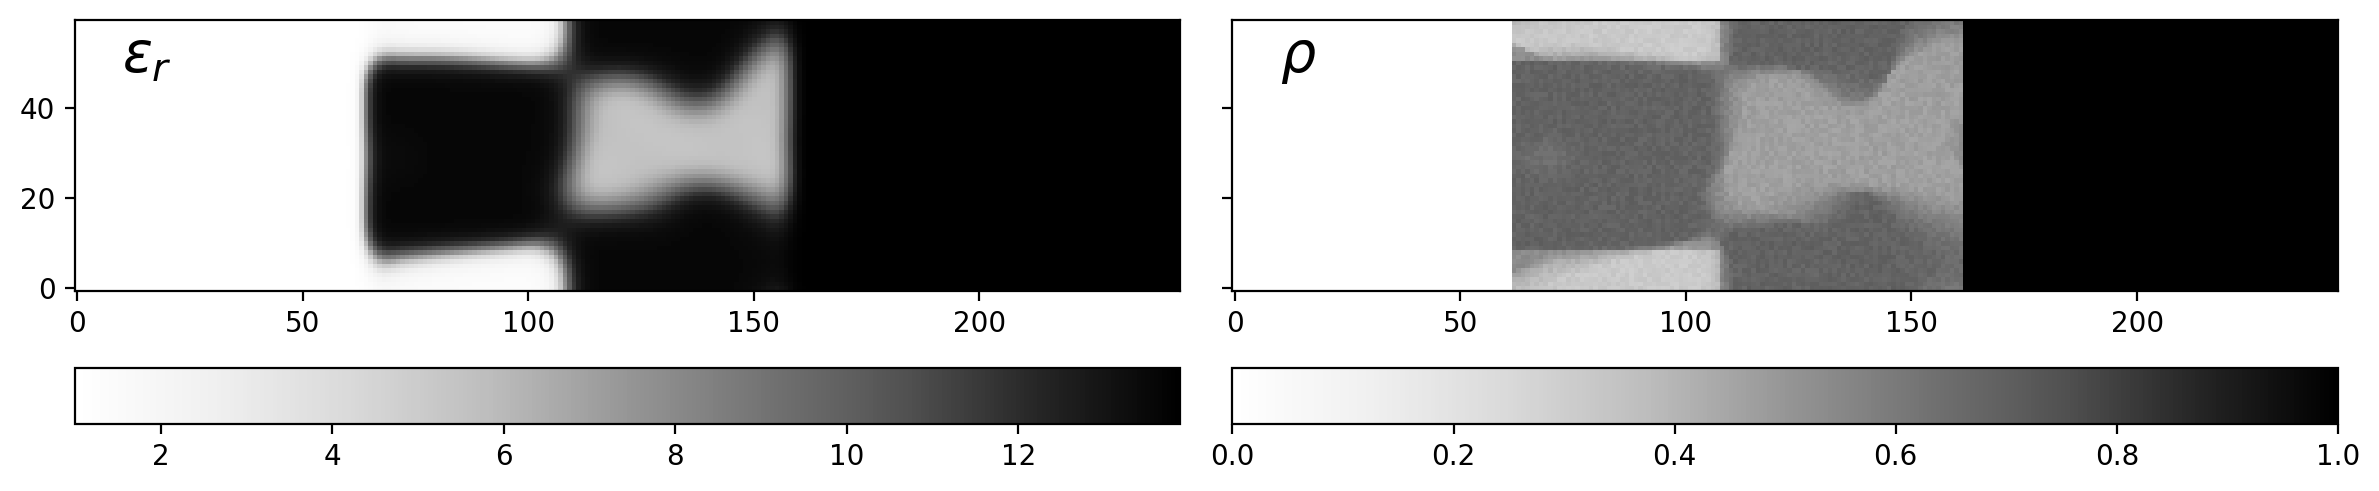

Epoch:  12/100 | Duration: 5.67 secs | Value: 6.130180e-01


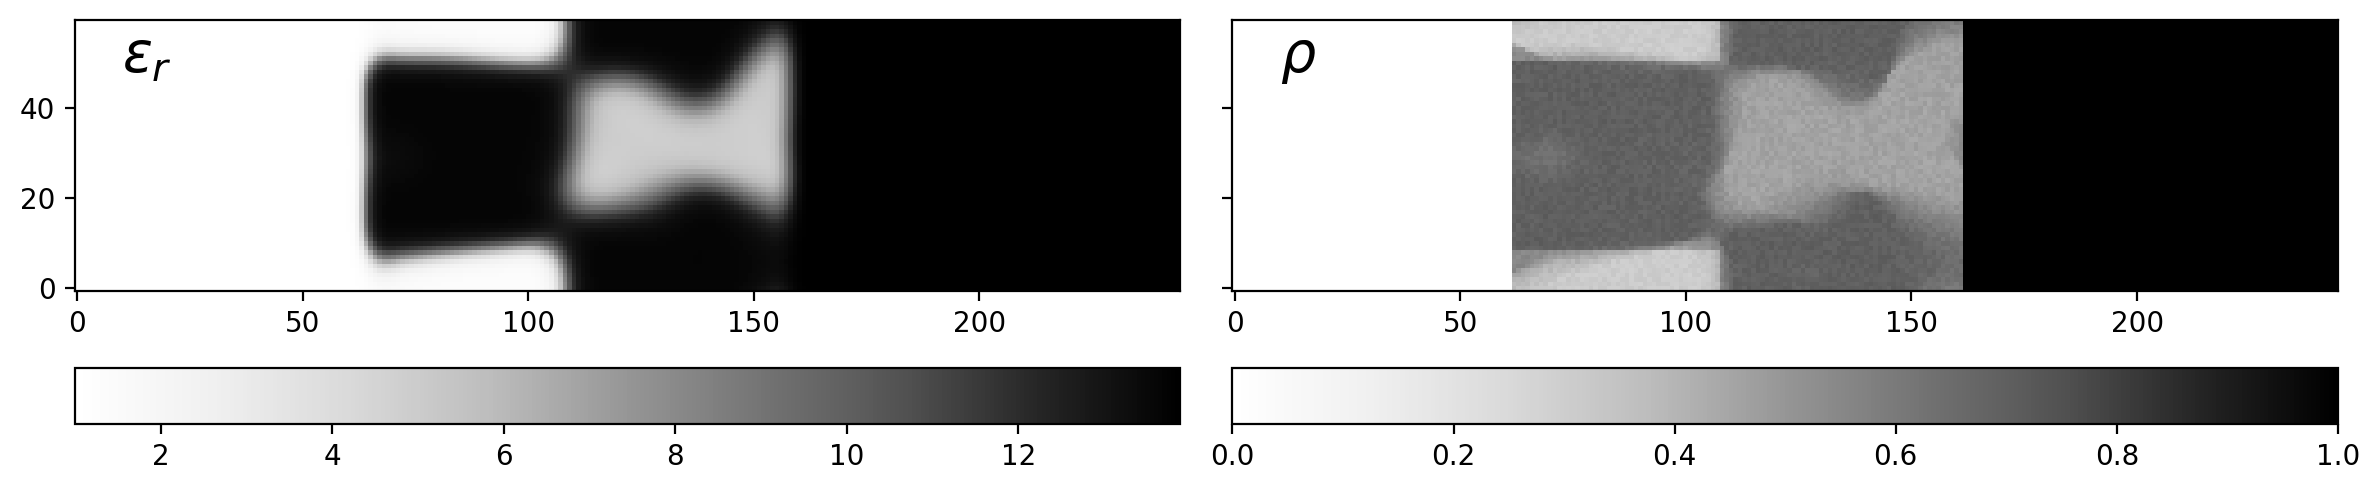

Epoch:  13/100 | Duration: 5.83 secs | Value: 7.088793e-01


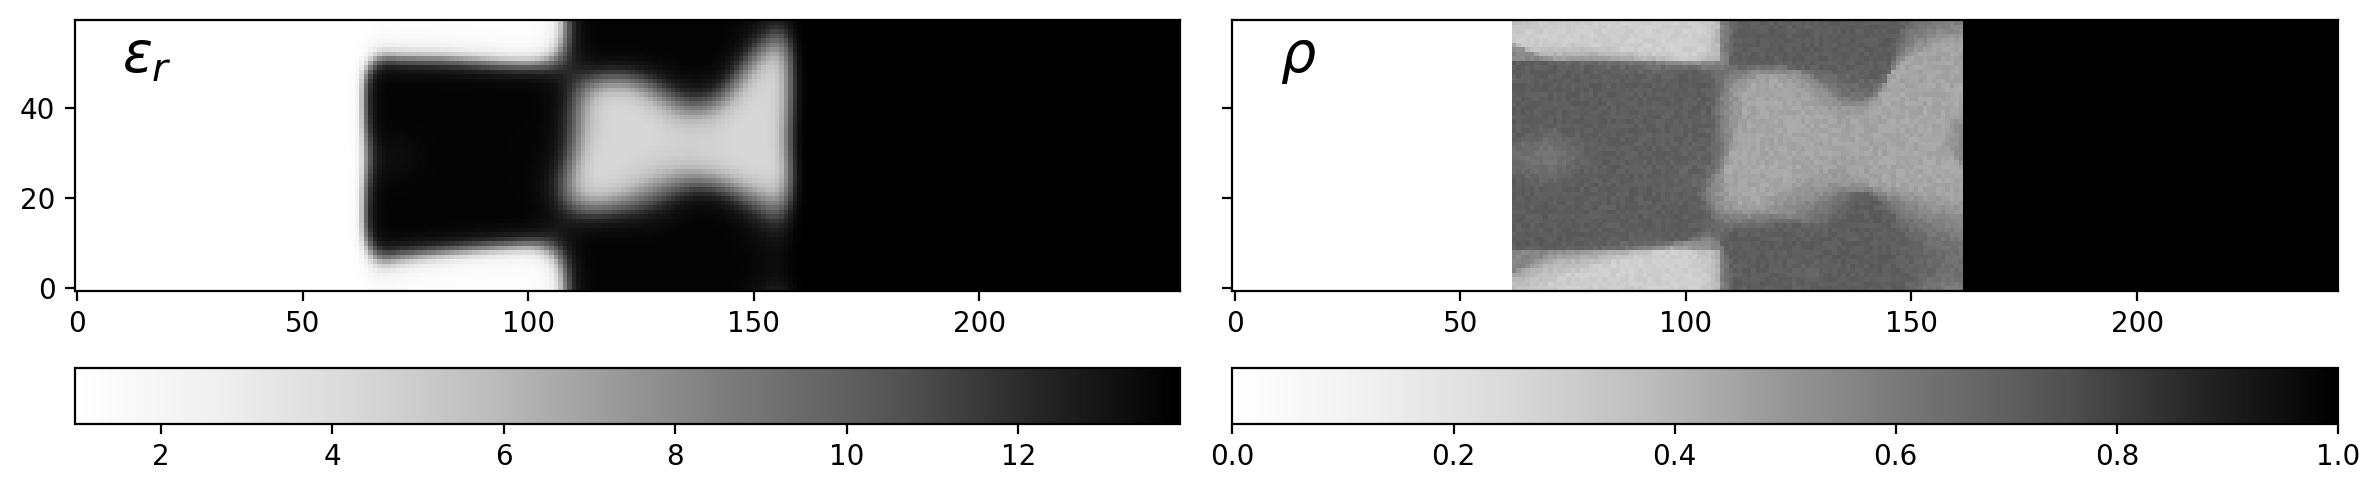

Epoch:  14/100 | Duration: 5.61 secs | Value: 8.056806e-01


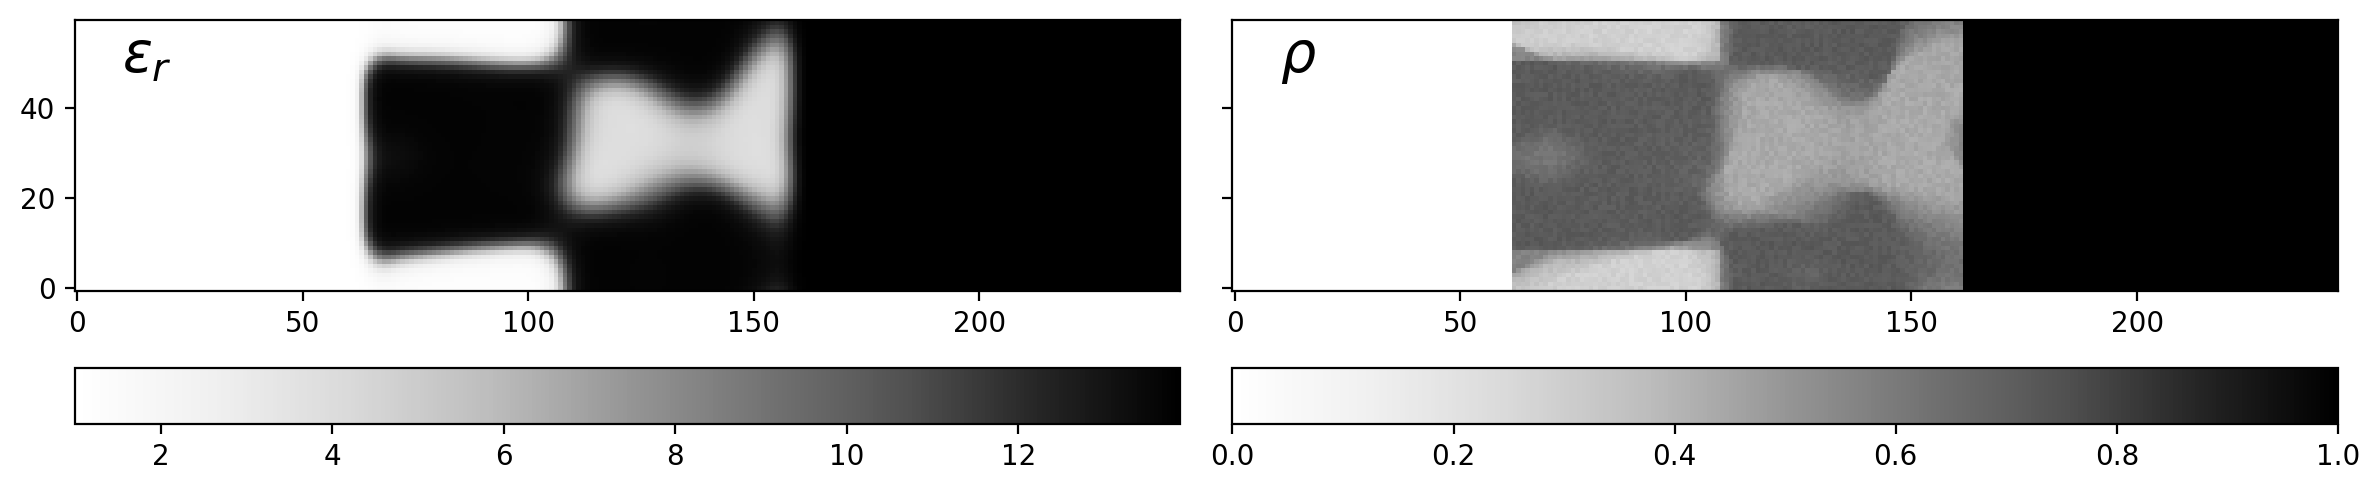

Epoch:  15/100 | Duration: 6.01 secs | Value: 9.036202e-01


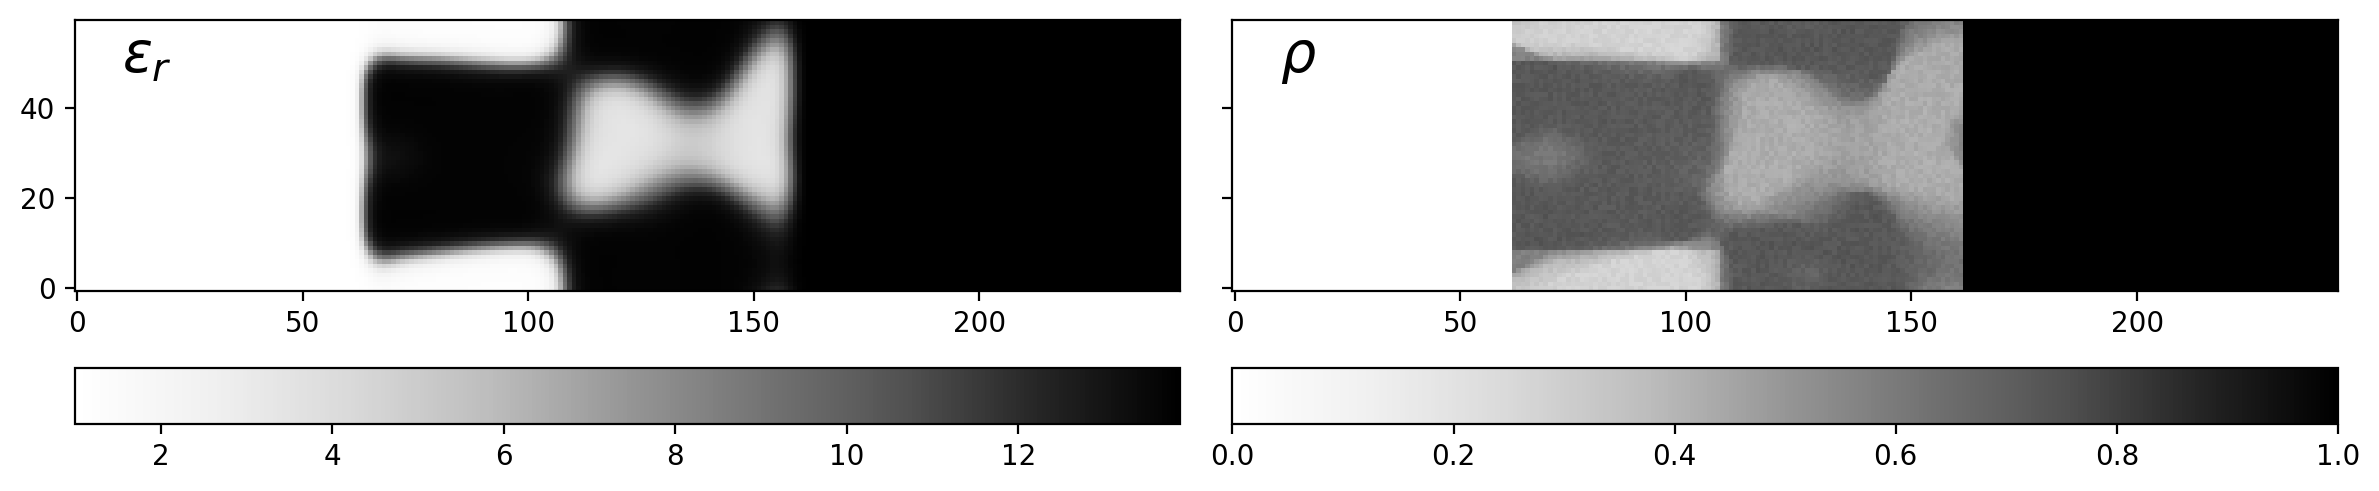

Epoch:  16/100 | Duration: 6.44 secs | Value: 1.007371e+00


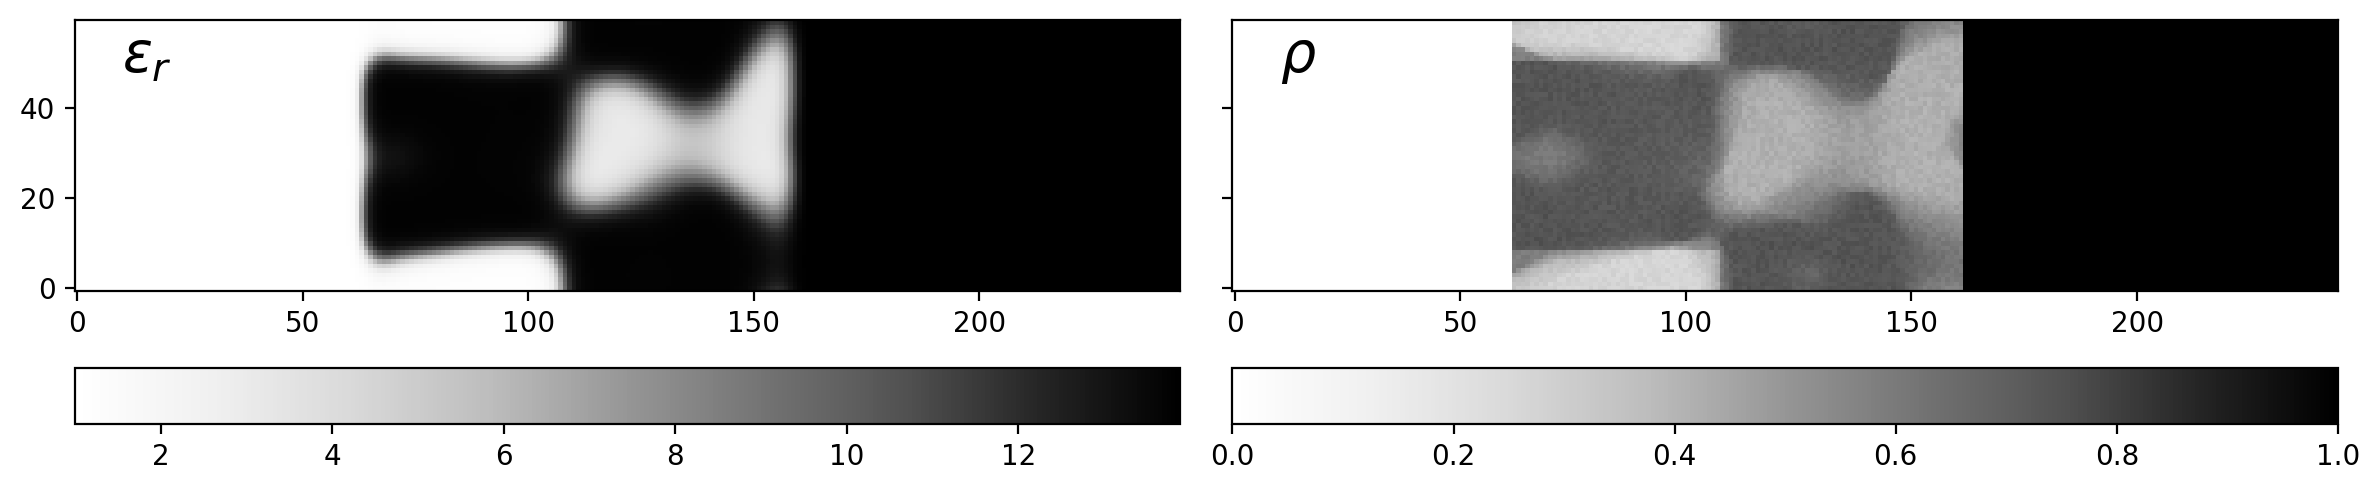

Epoch:  17/100 | Duration: 5.74 secs | Value: 1.122402e+00


Epoch:  18/100 | Duration: 5.45 secs | Value: 1.247412e+00


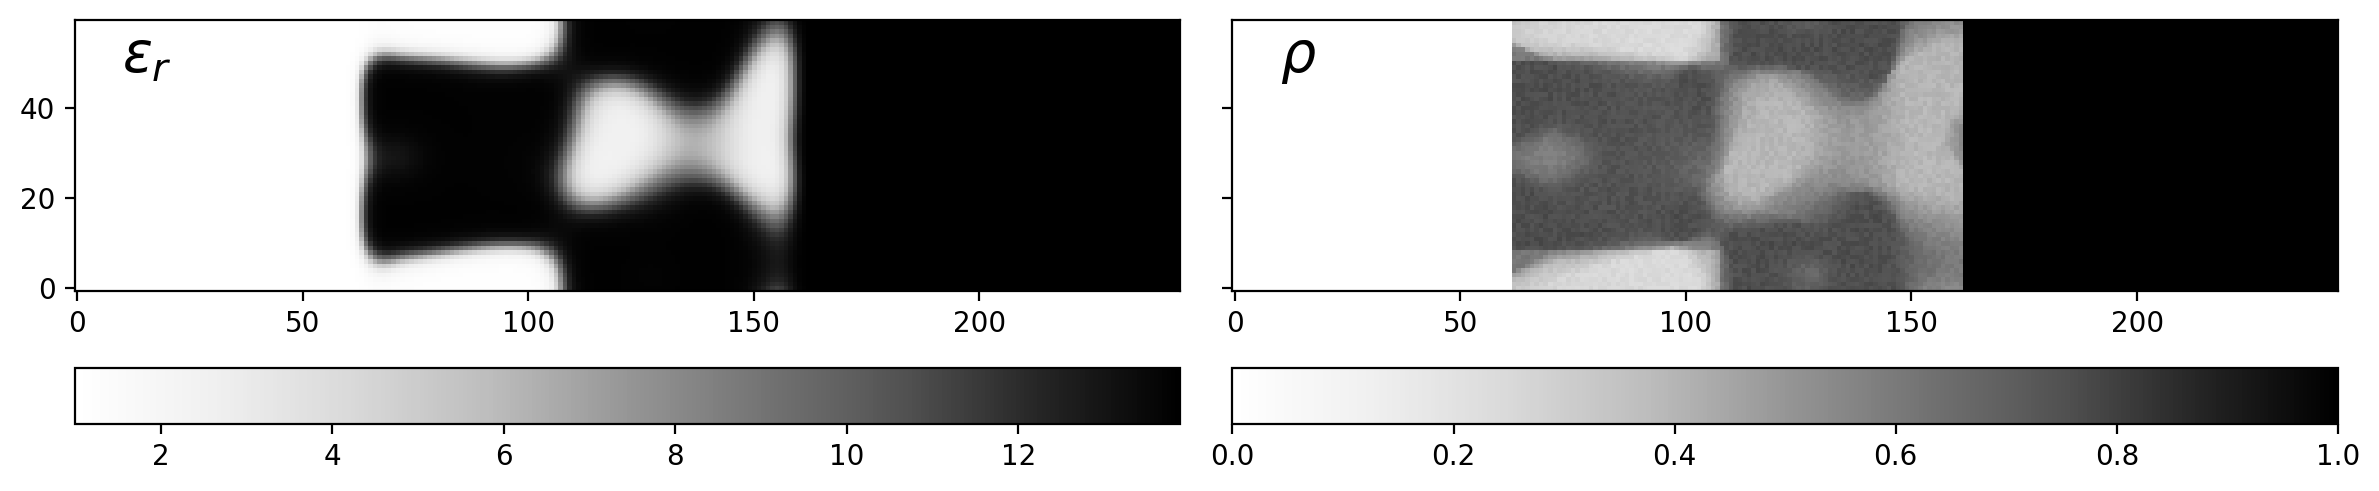

Epoch:  19/100 | Duration: 5.85 secs | Value: 1.375876e+00


Epoch:  20/100 | Duration: 5.58 secs | Value: 1.508637e+00


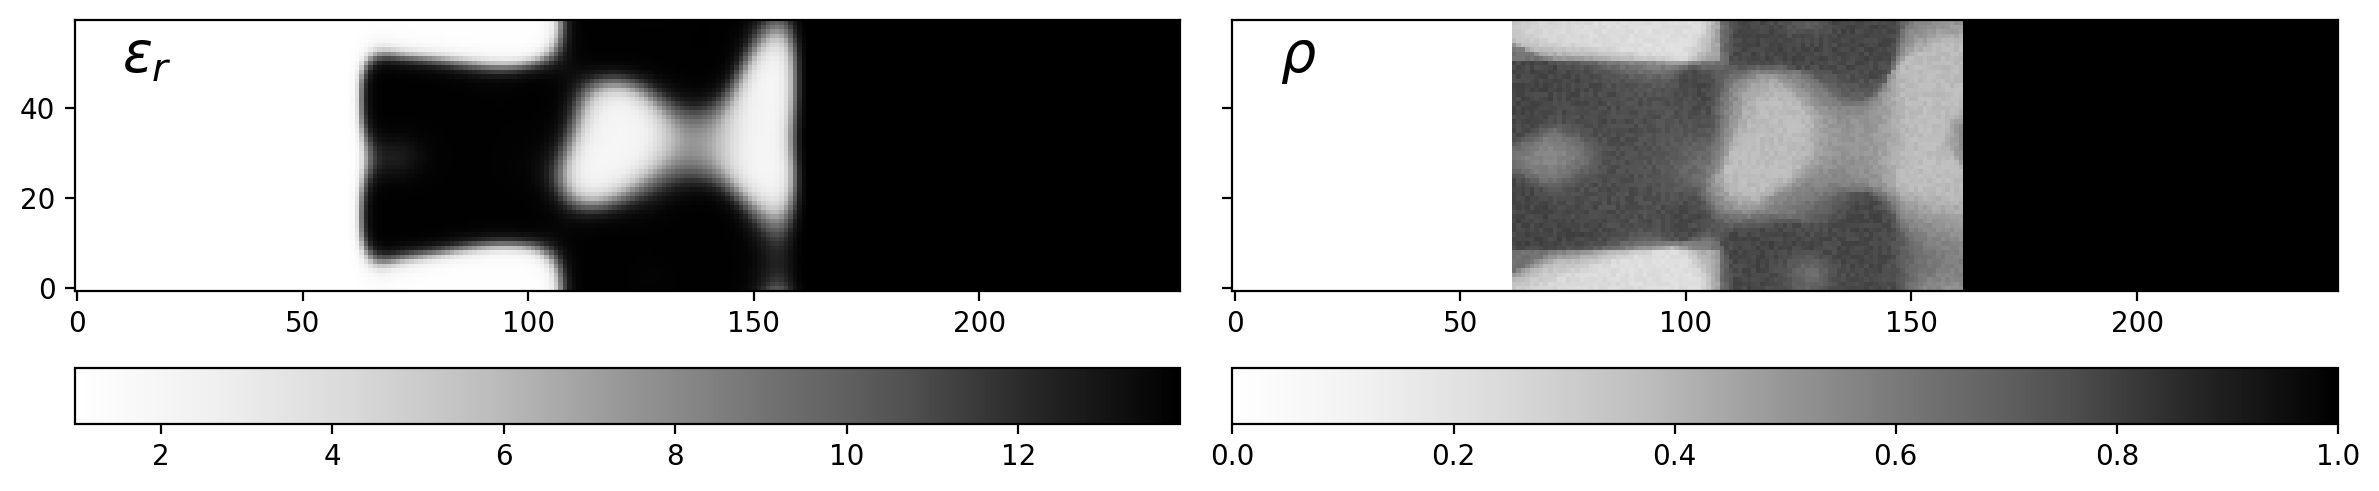

Epoch:  21/100 | Duration: 5.72 secs | Value: 1.653929e+00


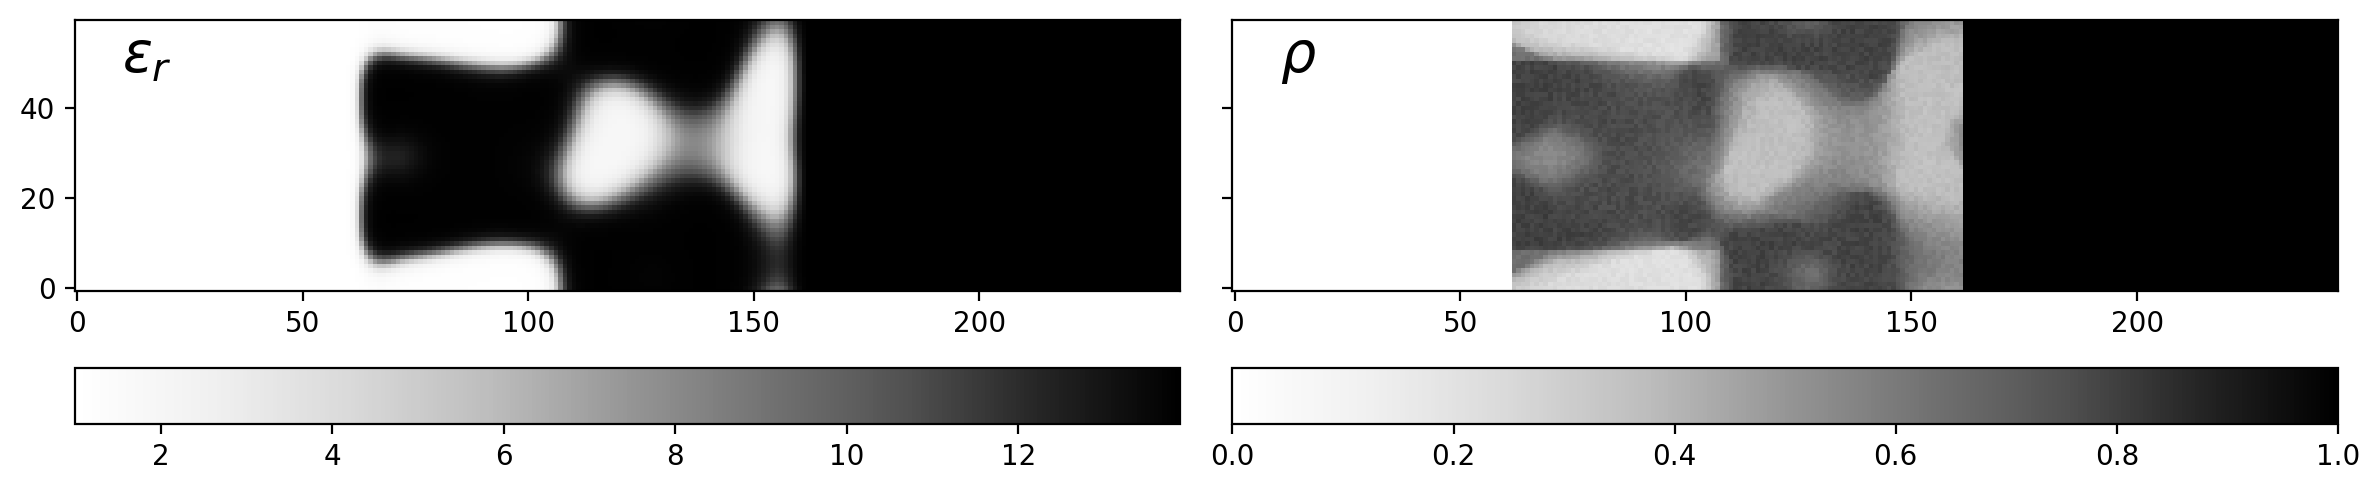

Epoch:  22/100 | Duration: 5.85 secs | Value: 1.809718e+00


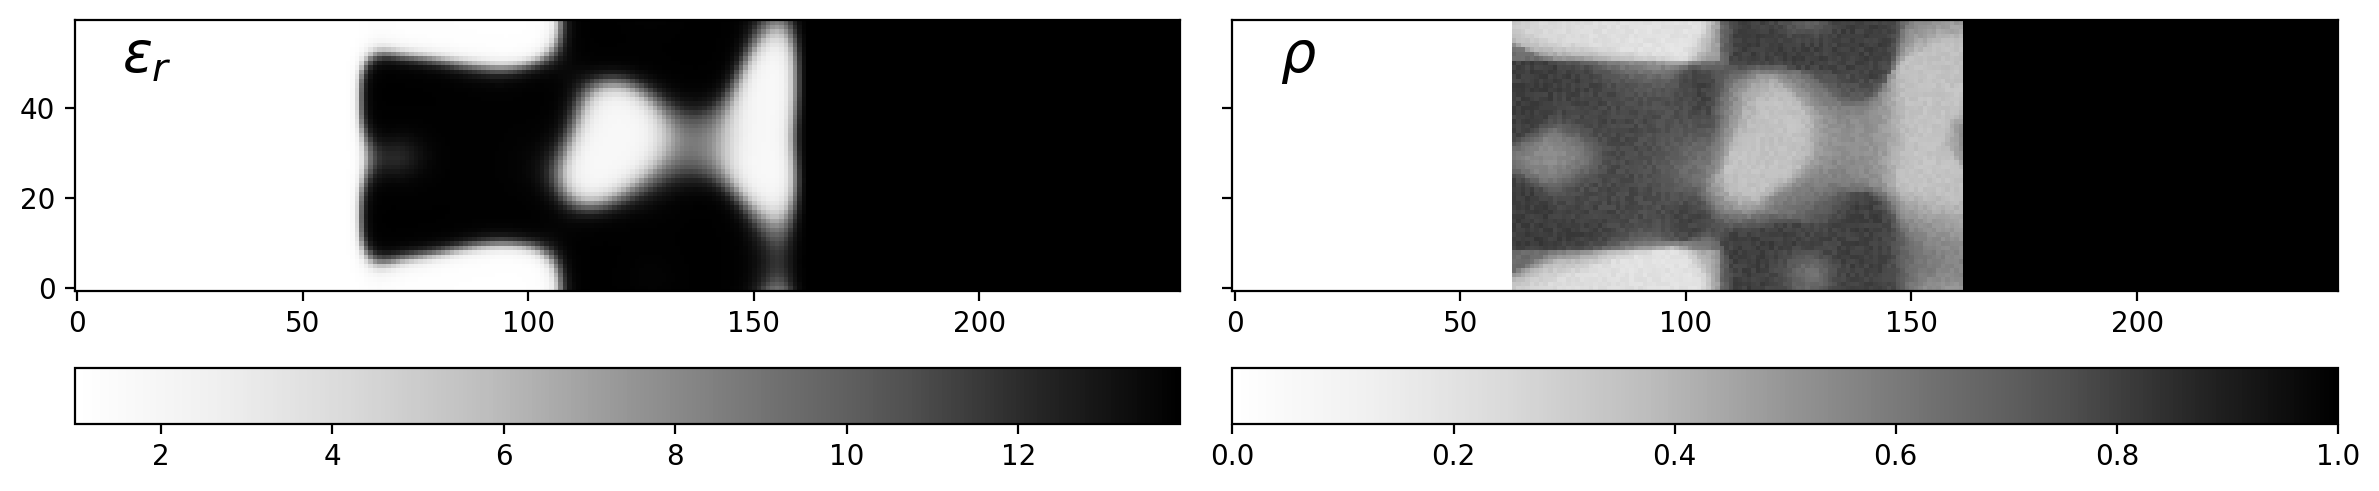

Epoch:  23/100 | Duration: 5.57 secs | Value: 1.966874e+00


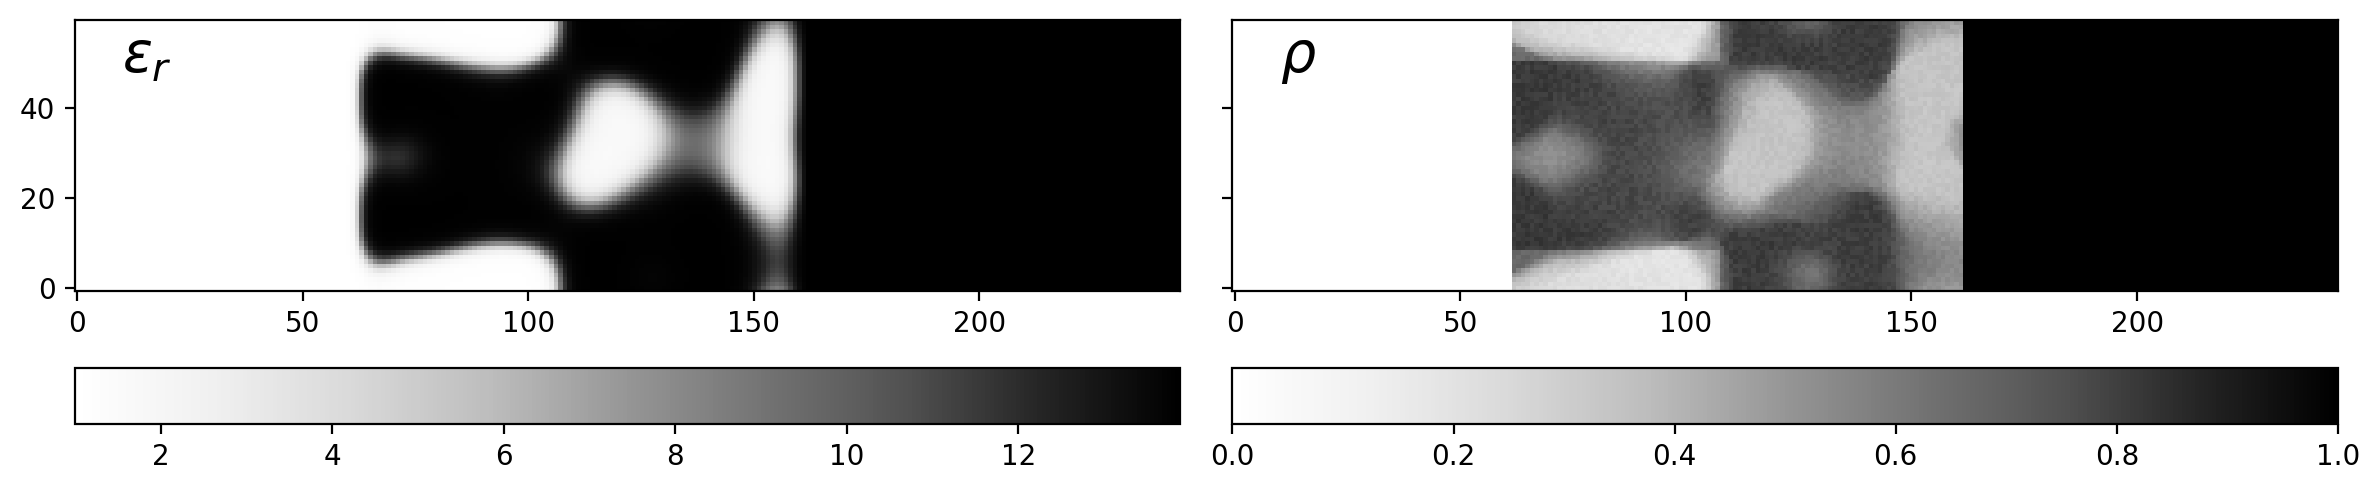

Epoch:  24/100 | Duration: 5.61 secs | Value: 2.136637e+00


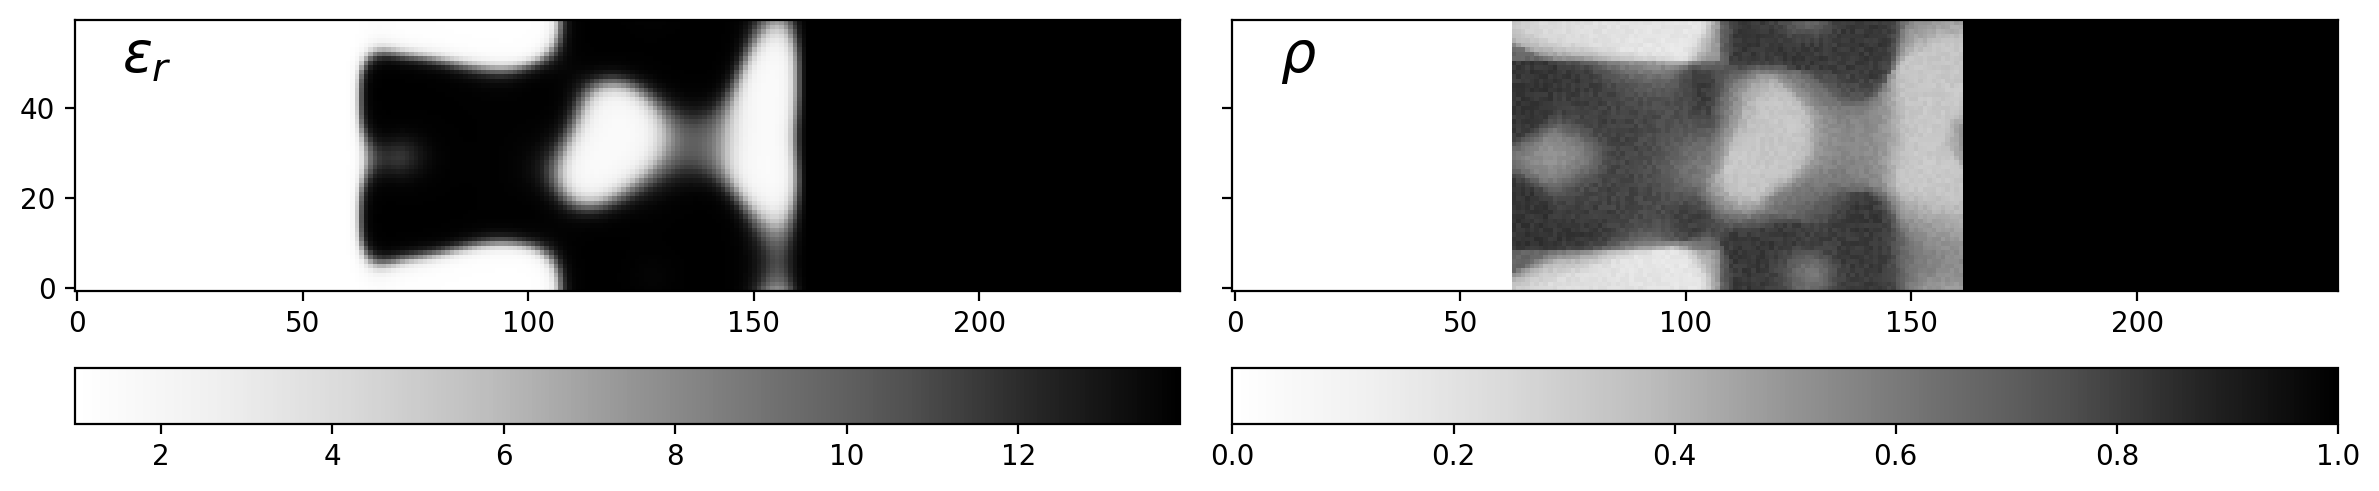

Epoch:  25/100 | Duration: 5.56 secs | Value: 2.319089e+00


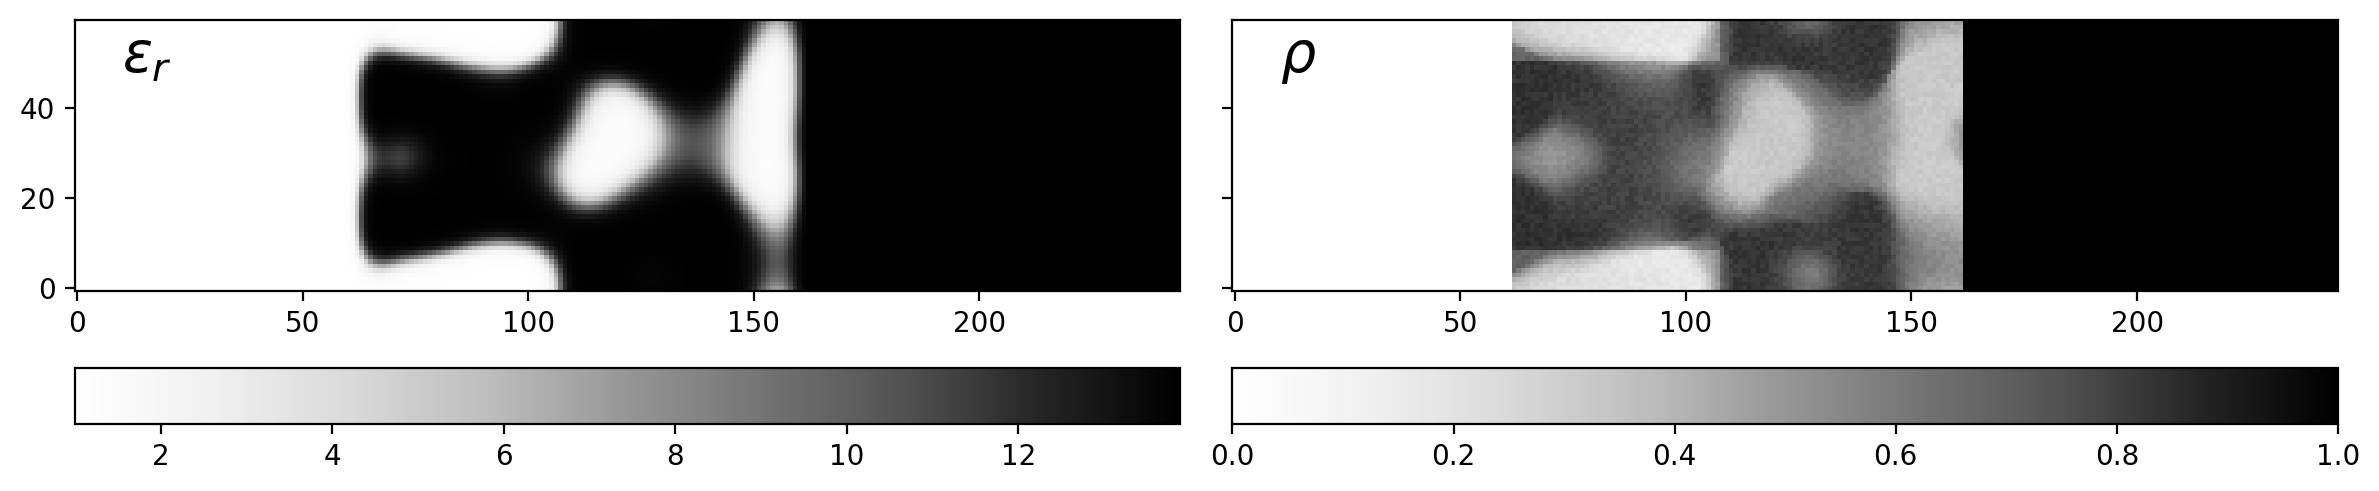

Epoch:  26/100 | Duration: 5.85 secs | Value: 2.501520e+00


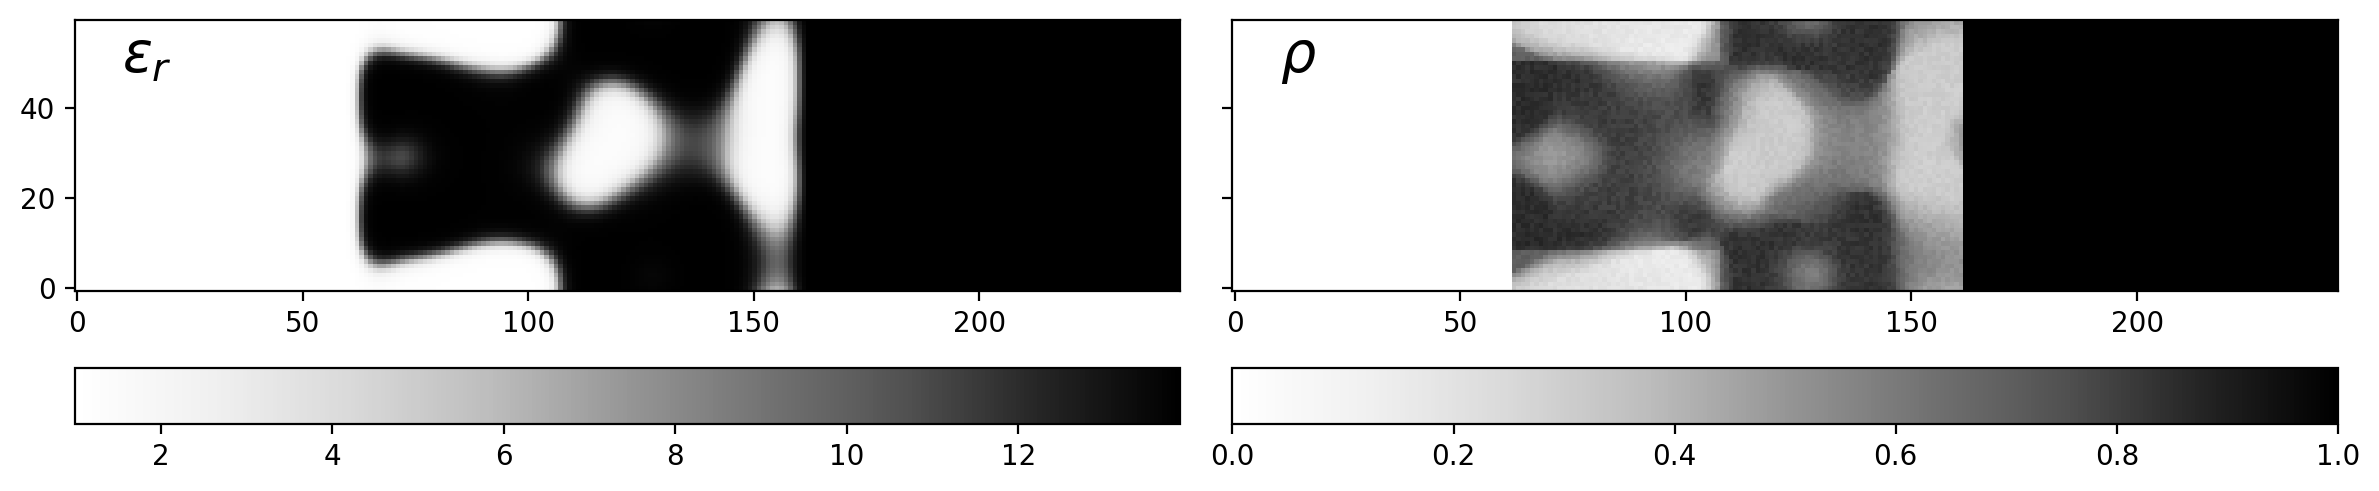

Epoch:  27/100 | Duration: 5.28 secs | Value: 2.696046e+00


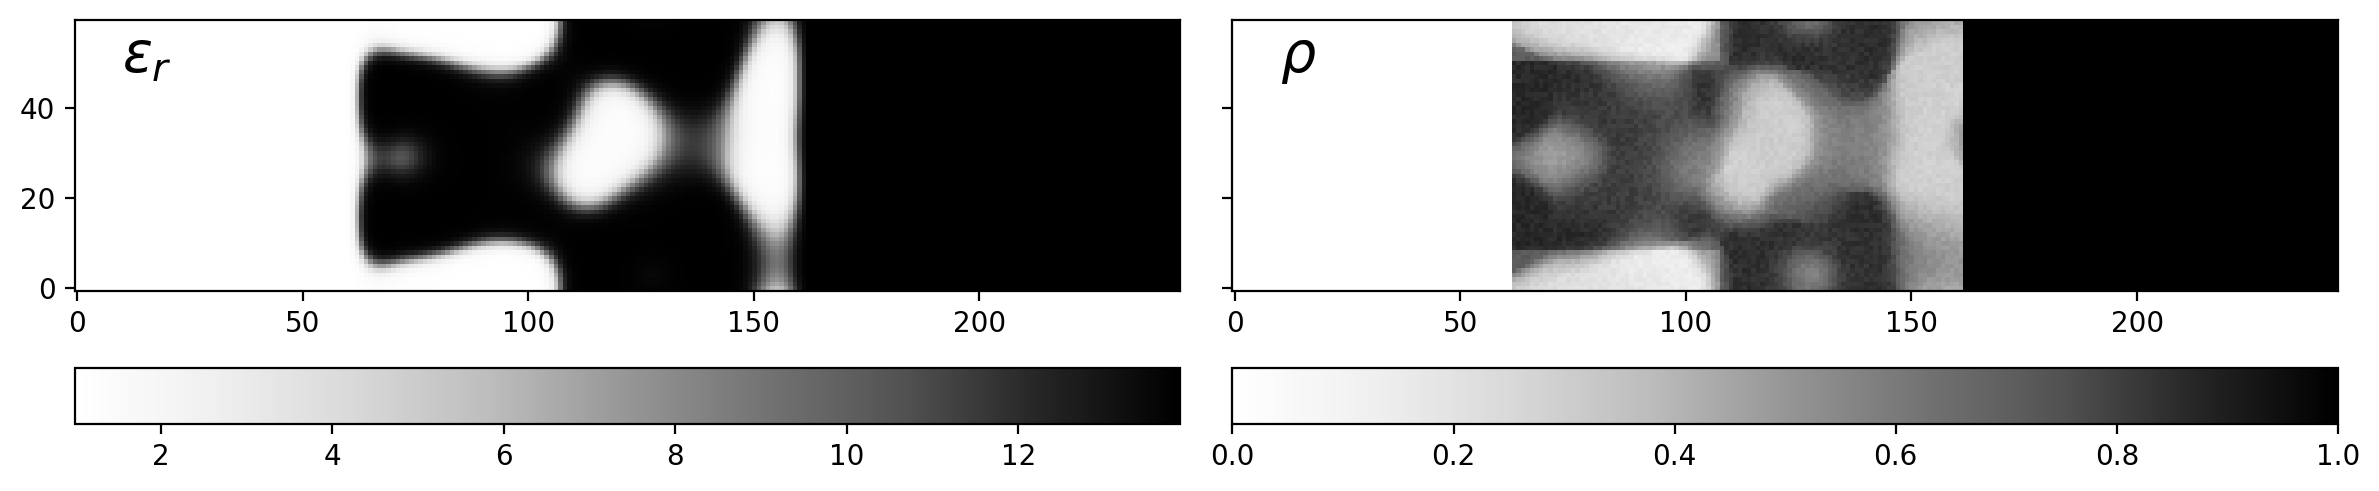

Epoch:  28/100 | Duration: 5.62 secs | Value: 2.891291e+00


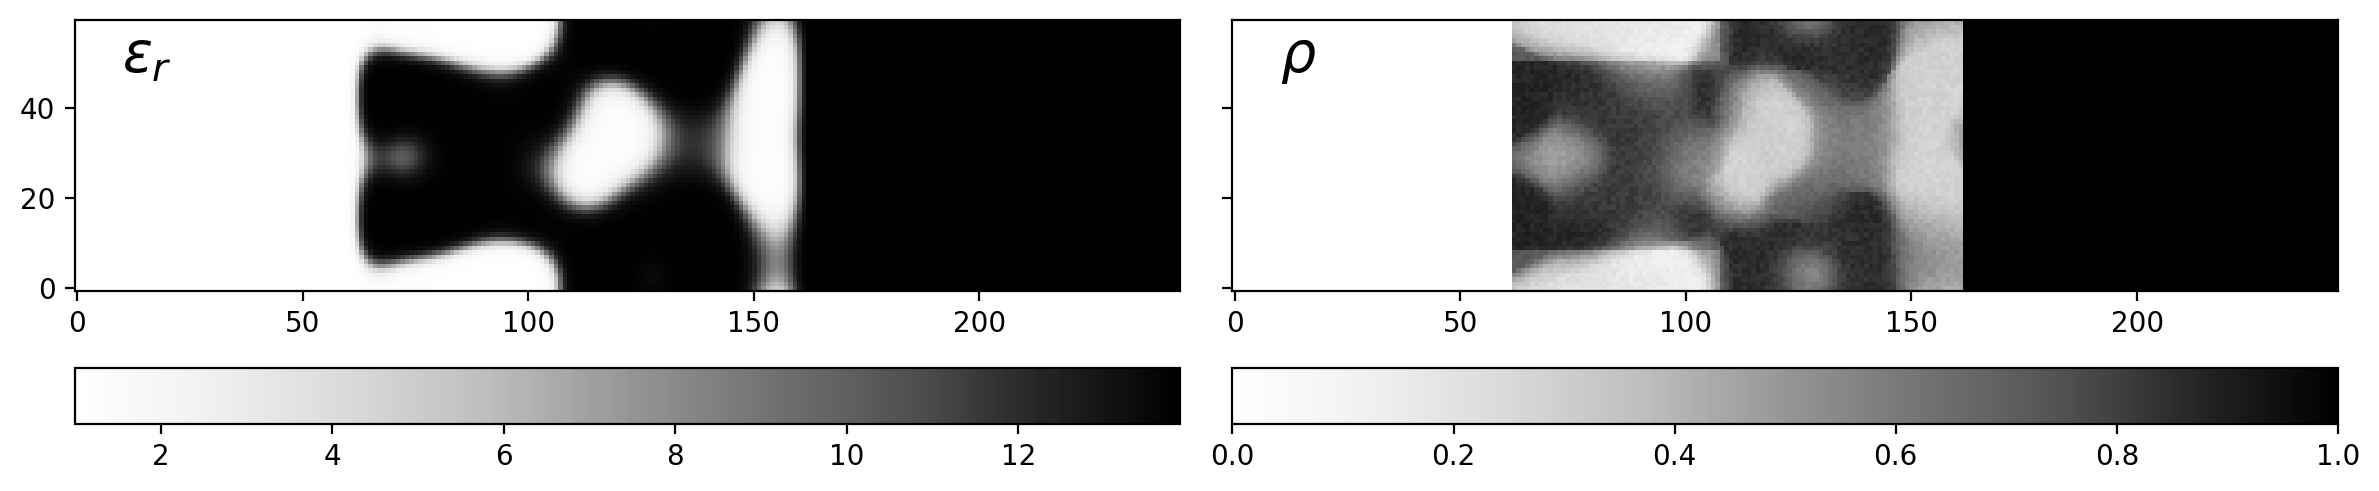

Epoch:  29/100 | Duration: 5.48 secs | Value: 3.102817e+00


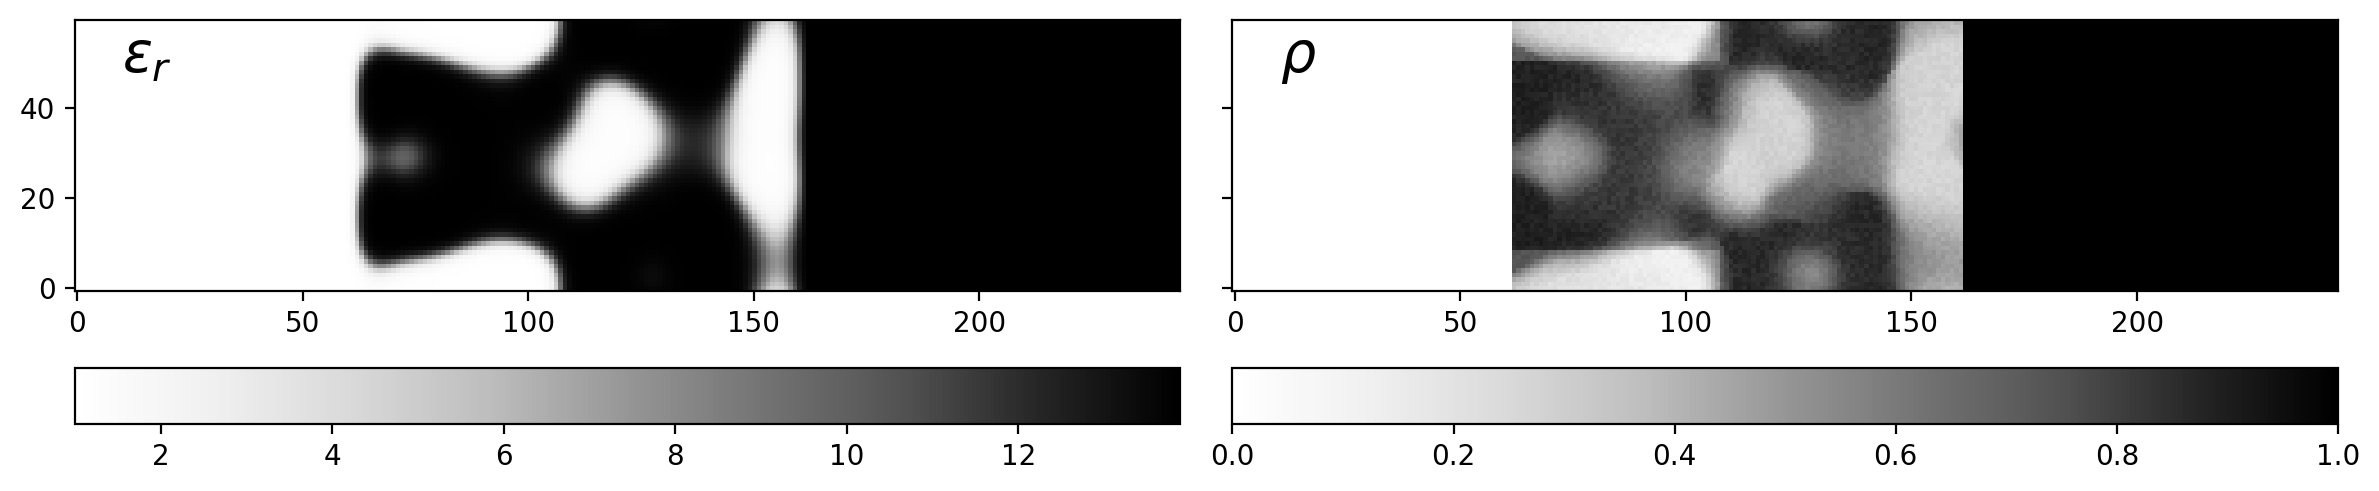

Epoch:  30/100 | Duration: 5.87 secs | Value: 3.323617e+00


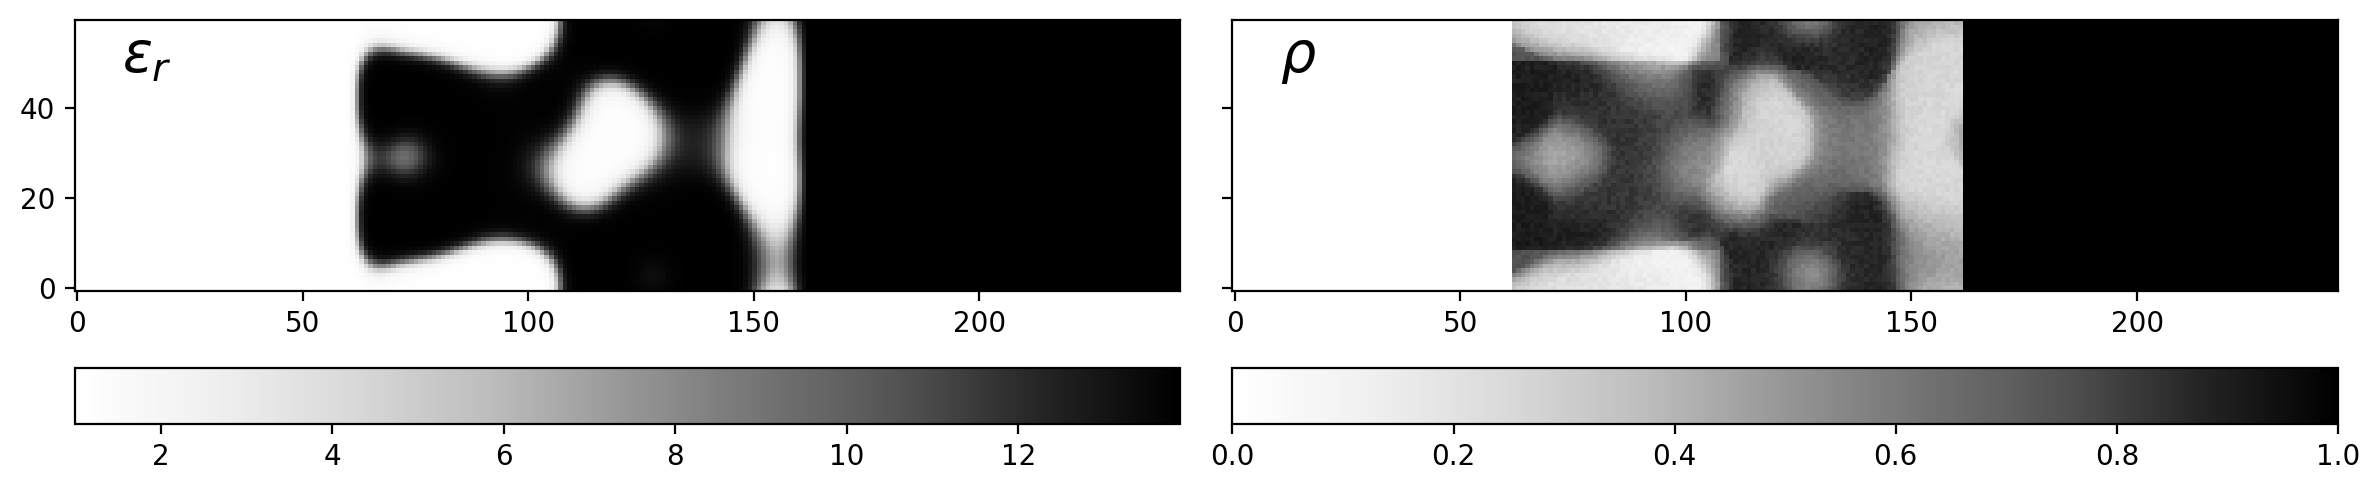

Epoch:  31/100 | Duration: 5.42 secs | Value: 3.573426e+00


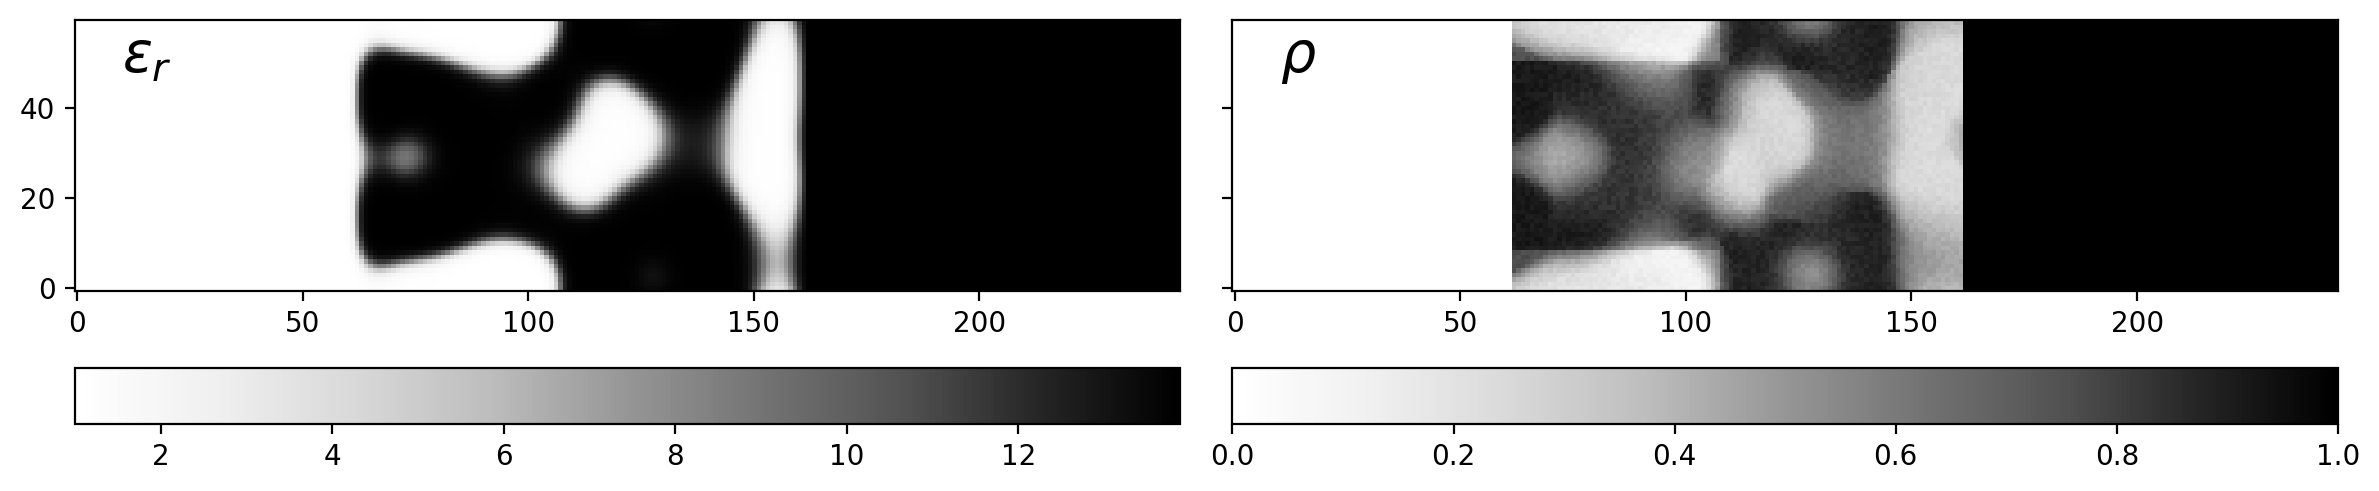

Epoch:  32/100 | Duration: 5.75 secs | Value: 3.848760e+00


Epoch:  33/100 | Duration: 5.81 secs | Value: 4.168924e+00


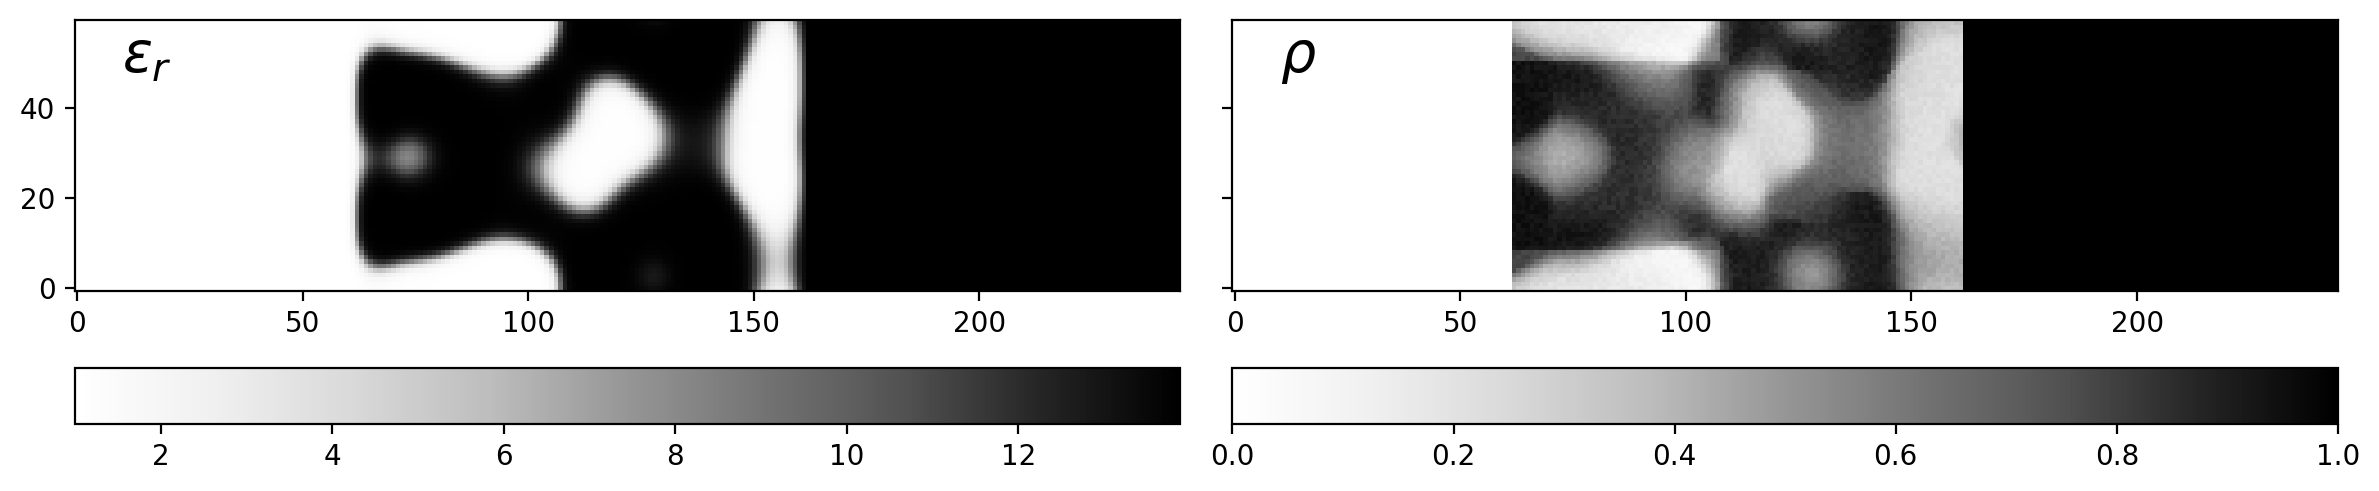

Epoch:  34/100 | Duration: 5.81 secs | Value: 4.535045e+00


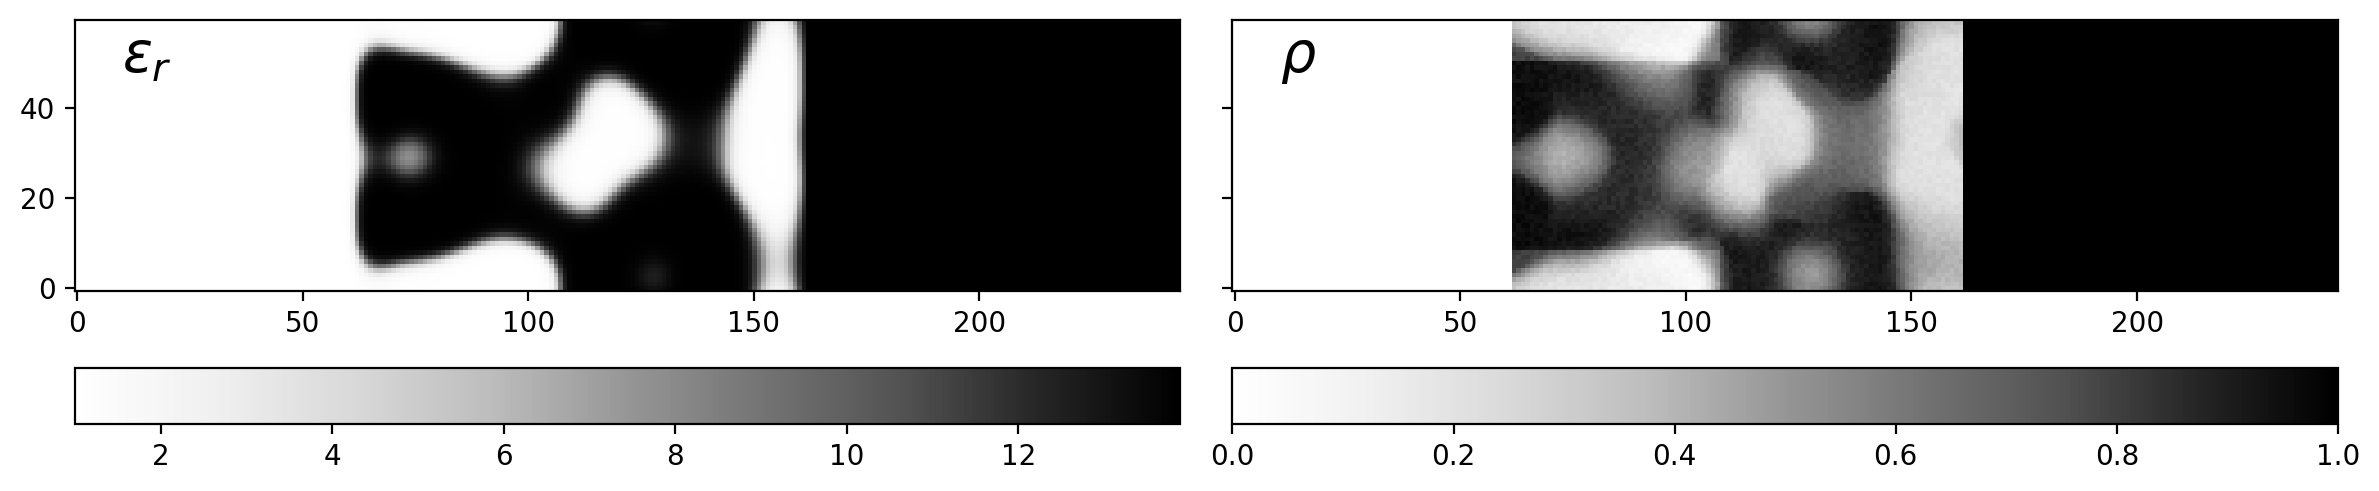

Epoch:  35/100 | Duration: 5.74 secs | Value: 4.963292e+00


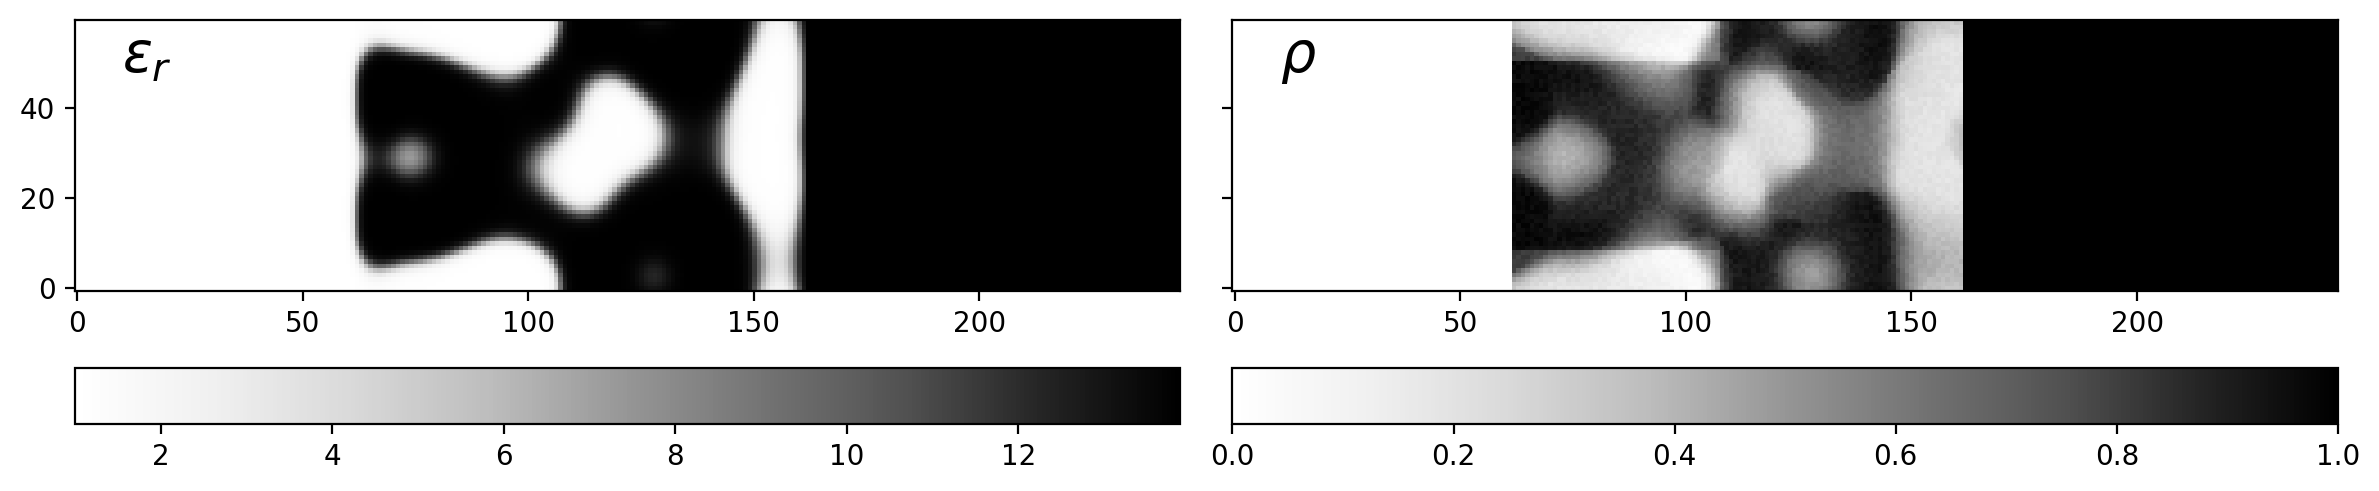

Epoch:  36/100 | Duration: 5.66 secs | Value: 5.469523e+00


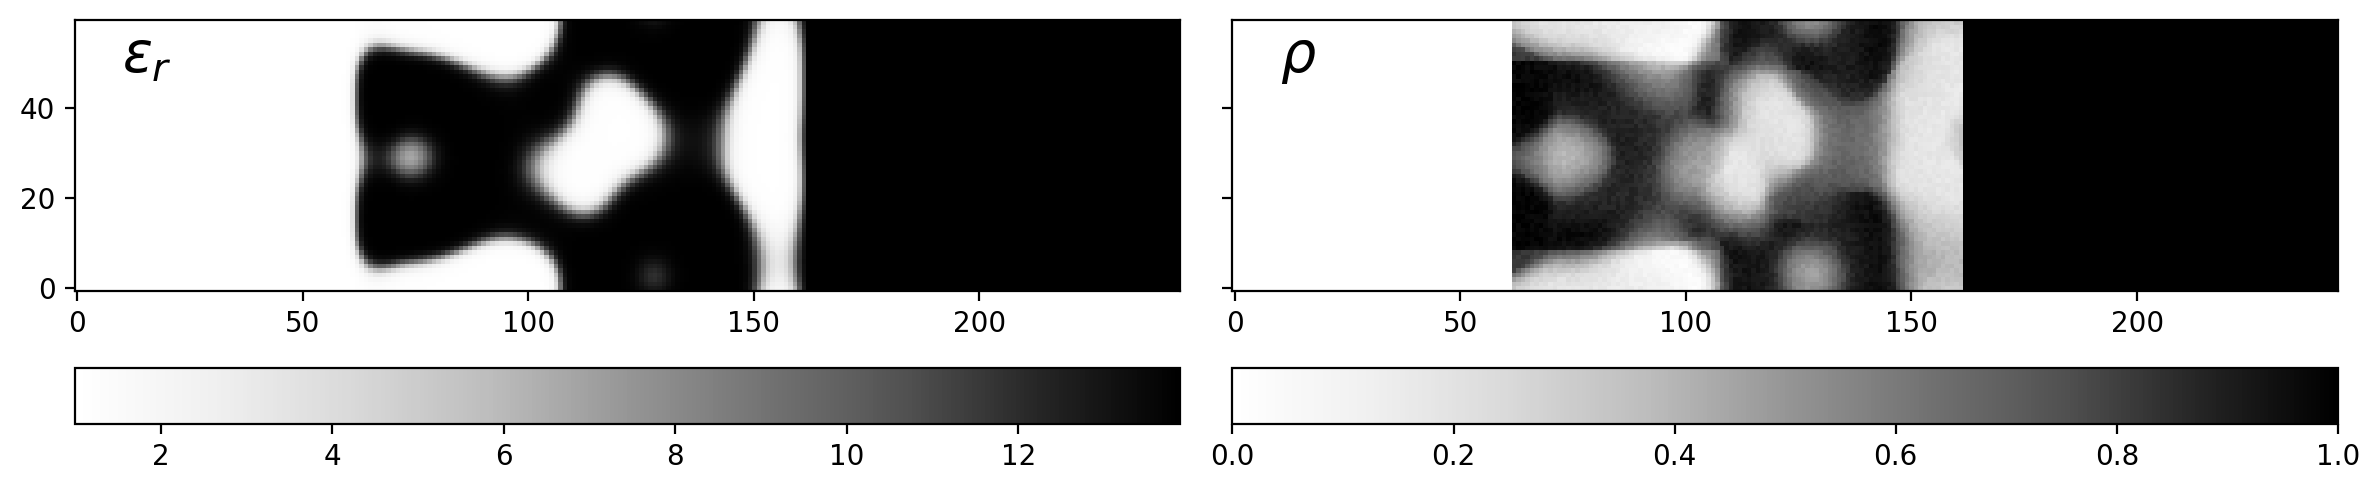

Epoch:  37/100 | Duration: 5.88 secs | Value: 5.991847e+00


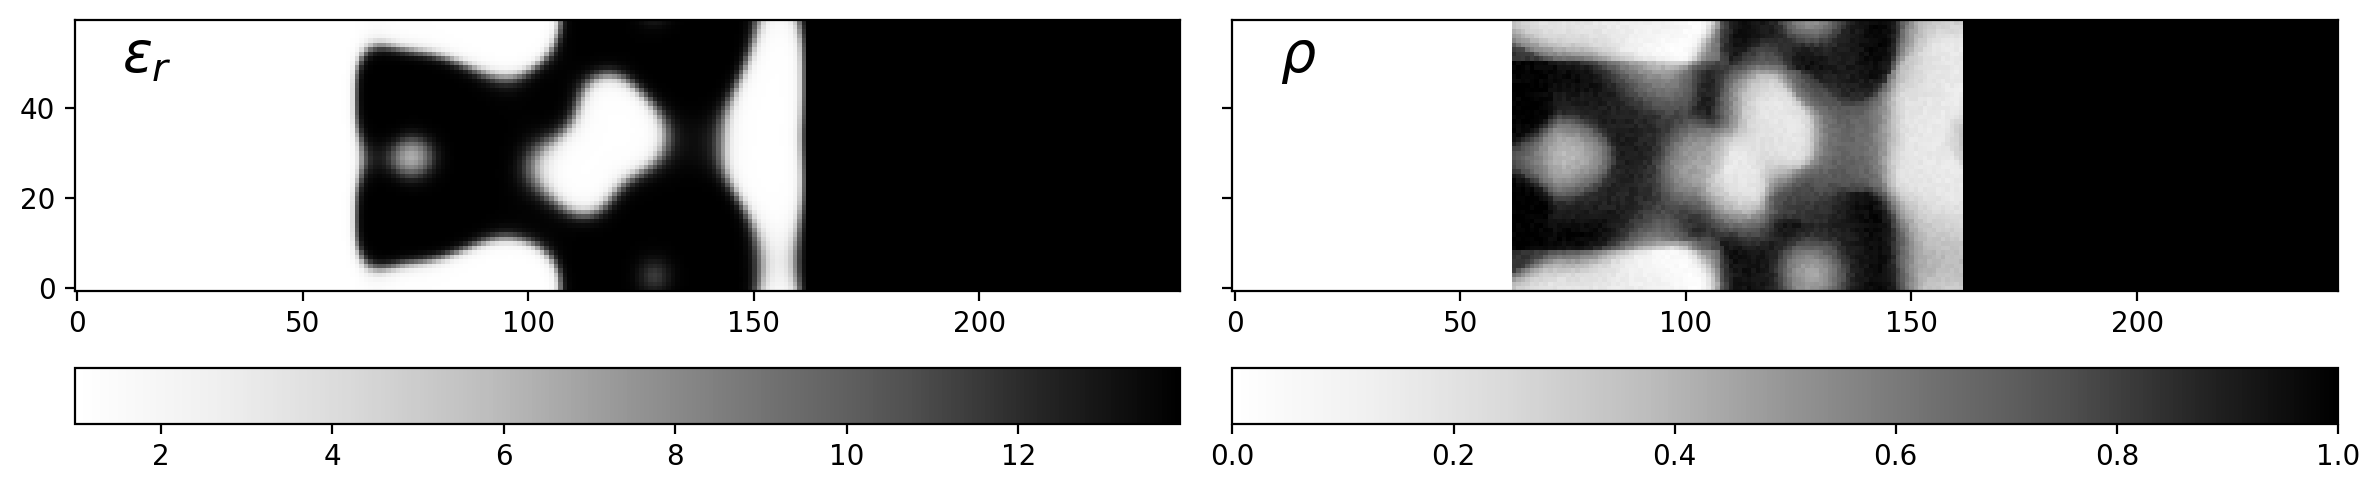

Epoch:  38/100 | Duration: 5.97 secs | Value: 6.374410e+00


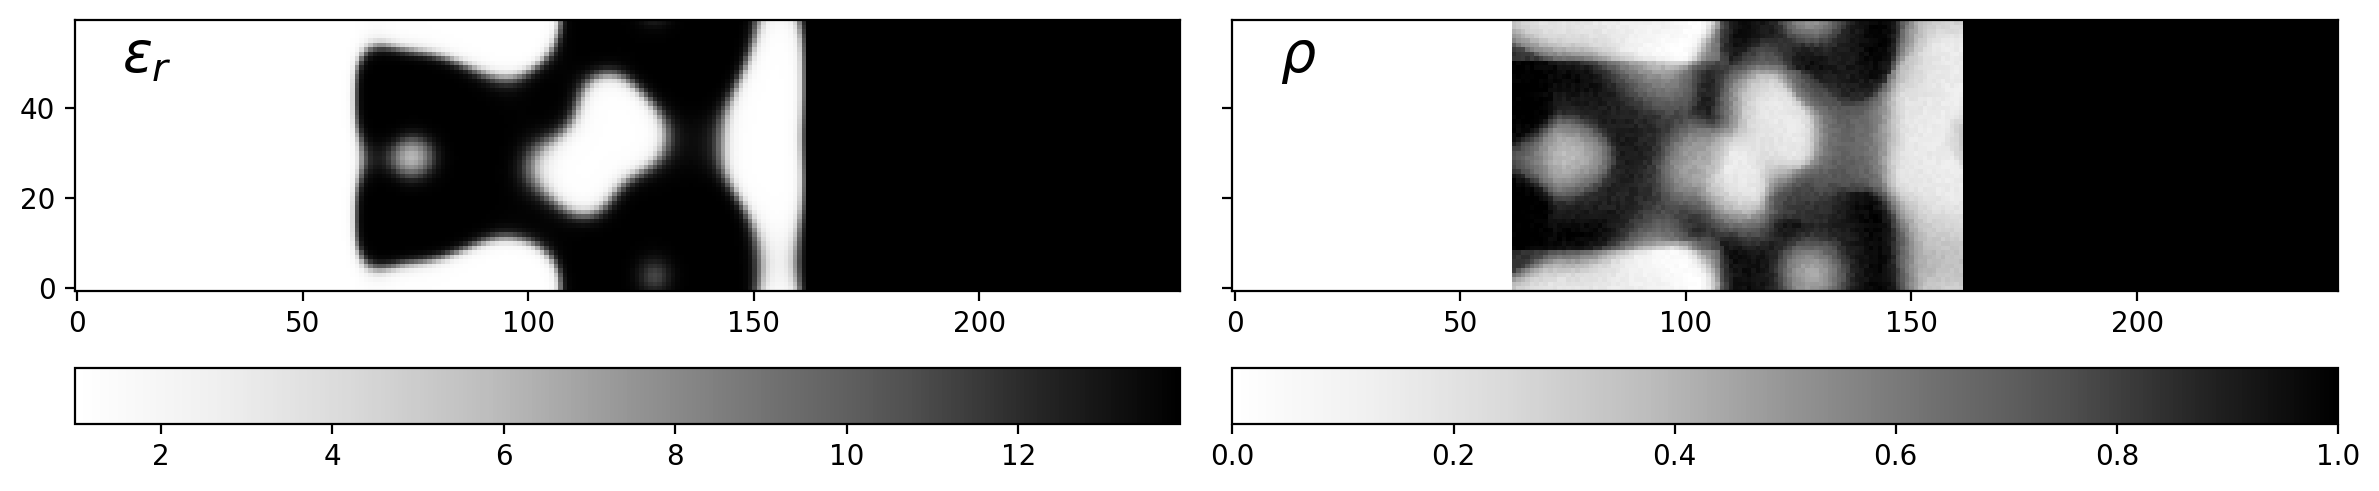

Epoch:  39/100 | Duration: 5.59 secs | Value: 6.816066e+00


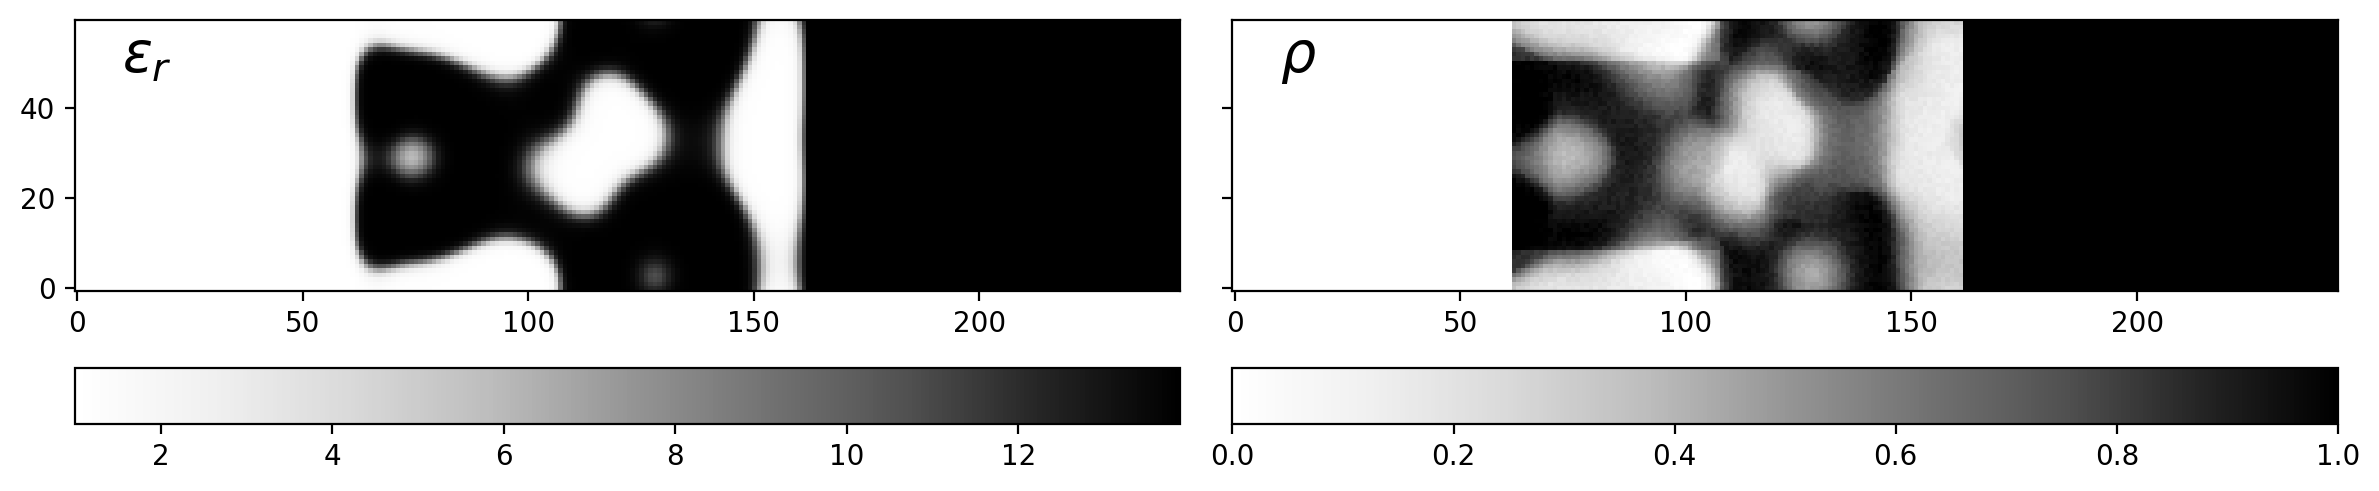

Epoch:  40/100 | Duration: 5.63 secs | Value: 7.617581e+00


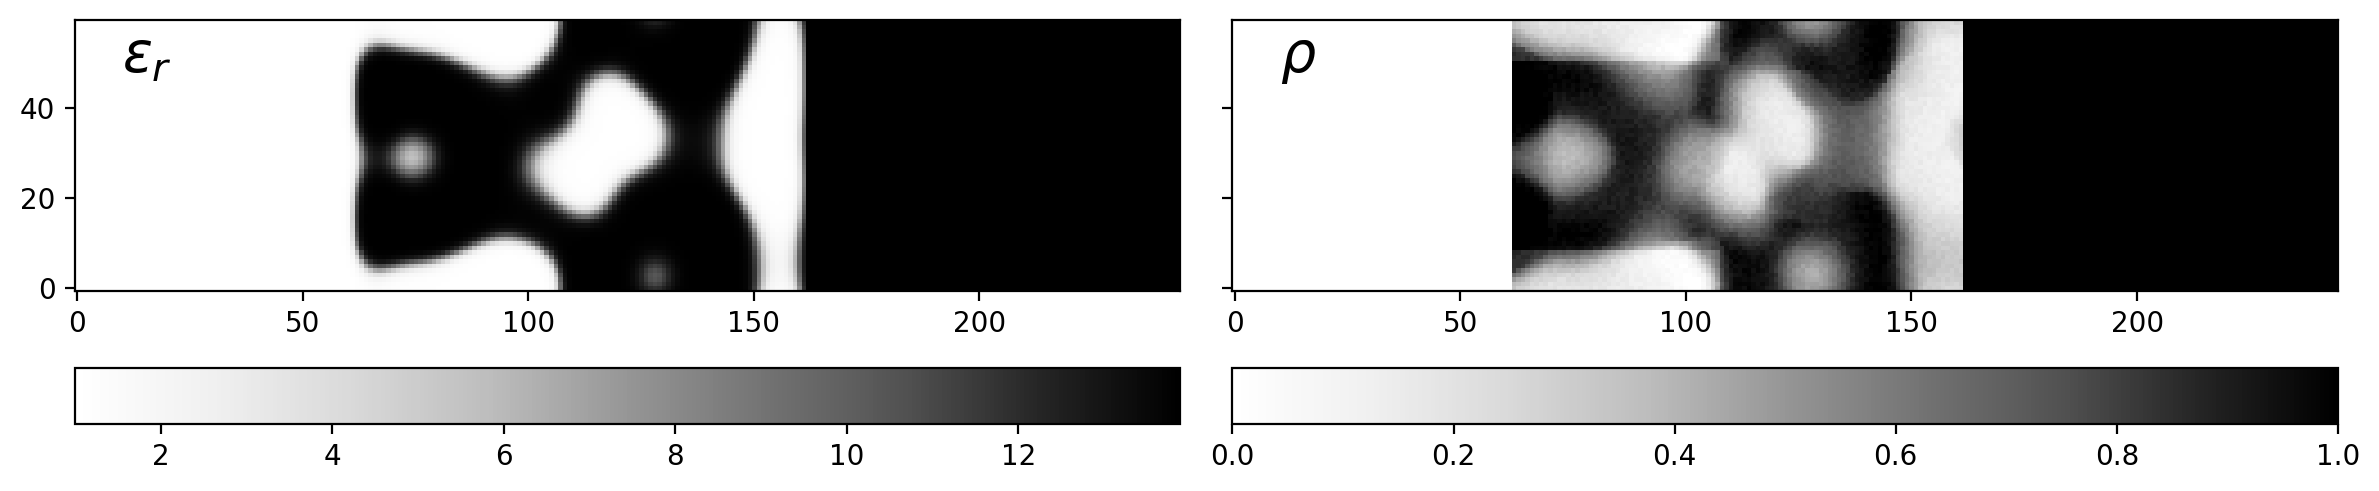

Epoch:  41/100 | Duration: 5.75 secs | Value: 8.065797e+00


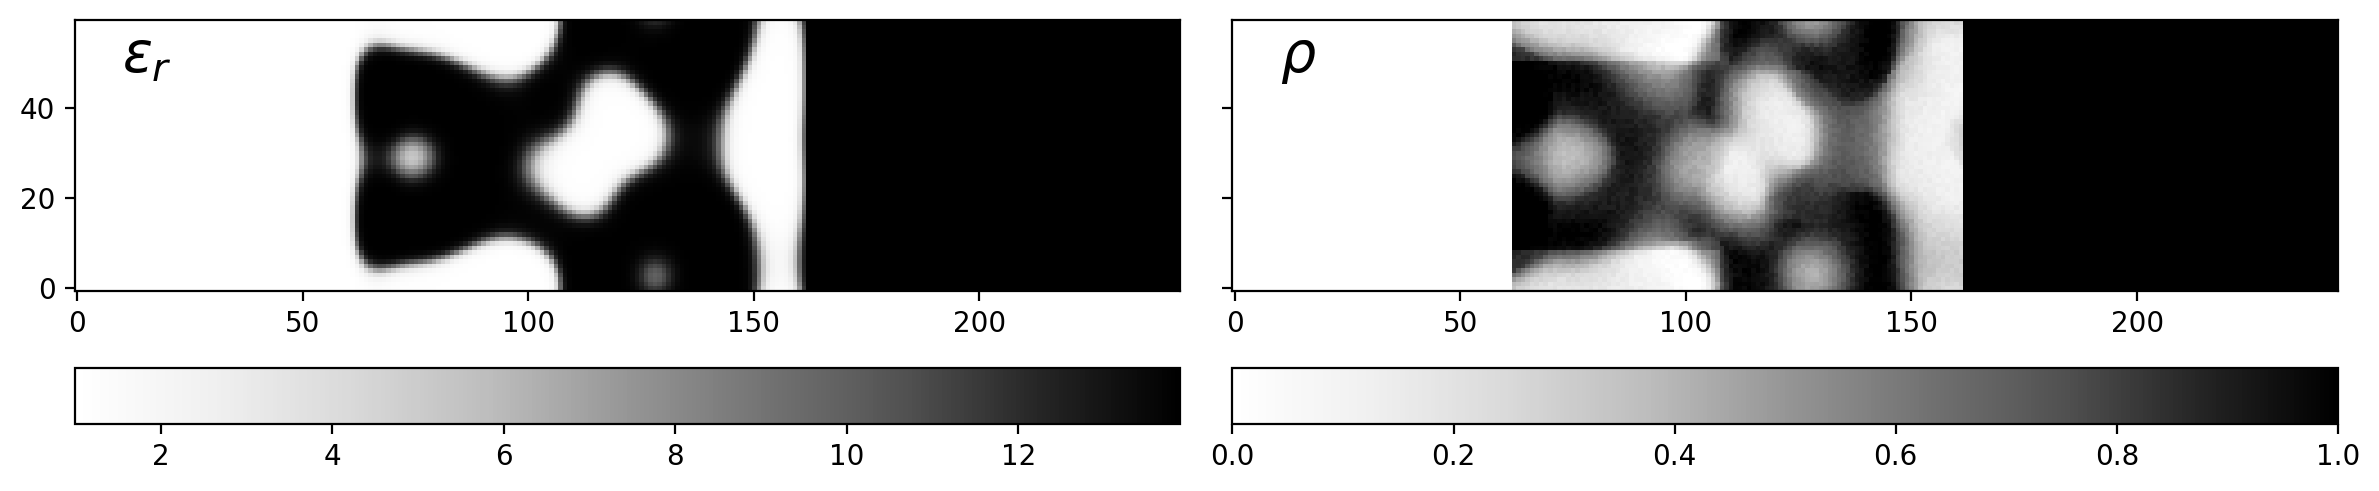

Epoch:  42/100 | Duration: 5.52 secs | Value: 8.129412e+00


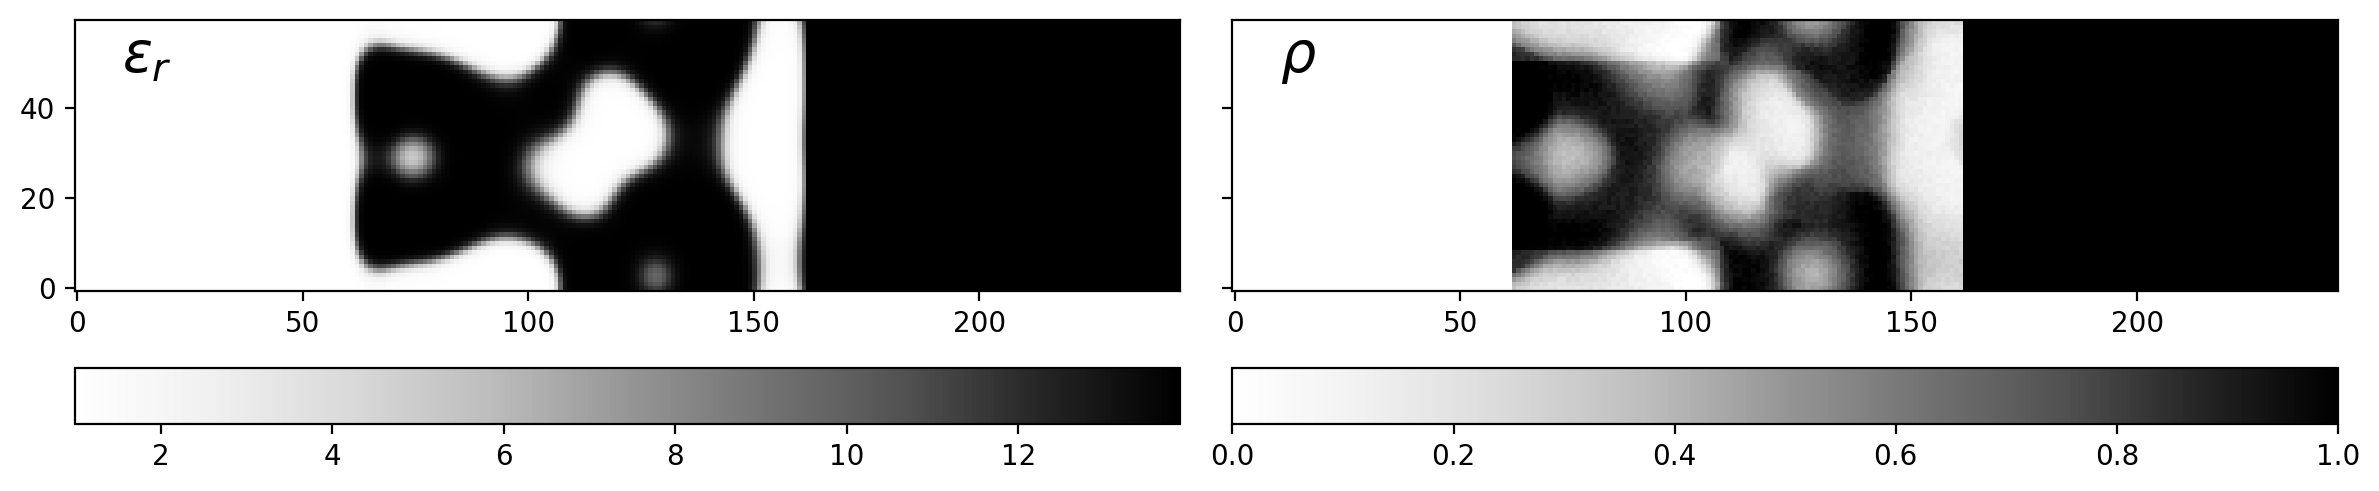

Epoch:  43/100 | Duration: 5.37 secs | Value: 8.937225e+00


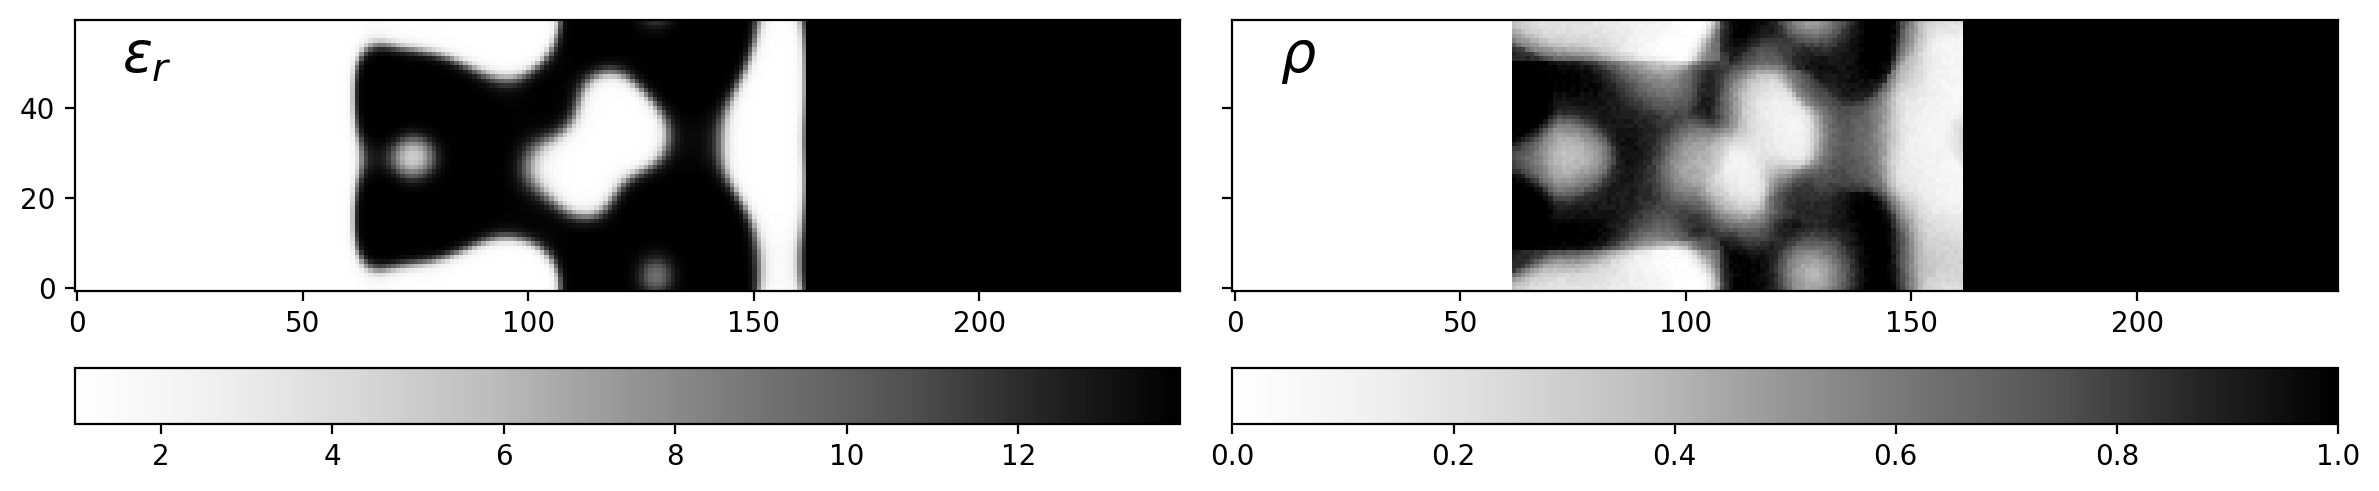

Epoch:  44/100 | Duration: 5.89 secs | Value: 1.008620e+01


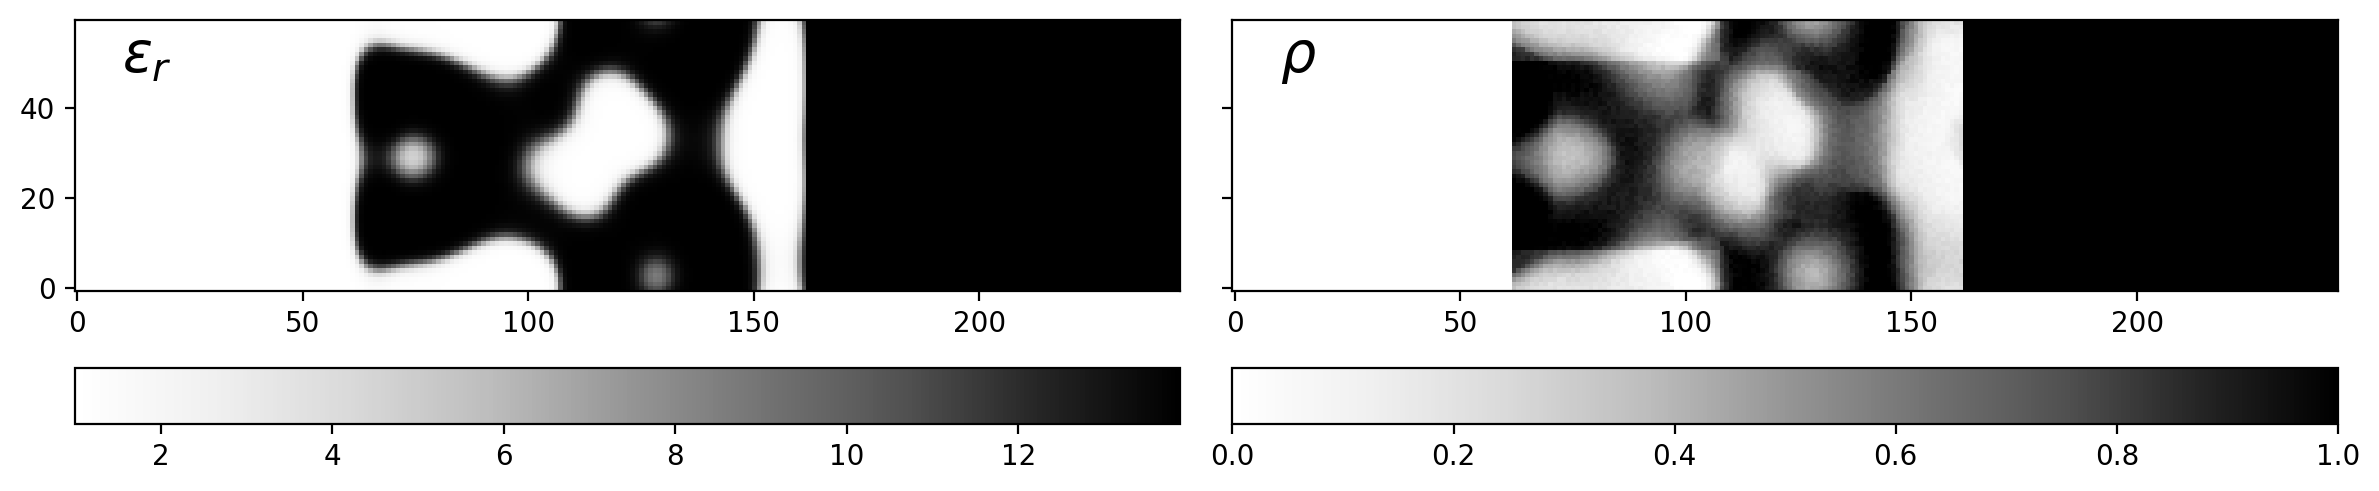

Epoch:  45/100 | Duration: 5.75 secs | Value: 1.010789e+01


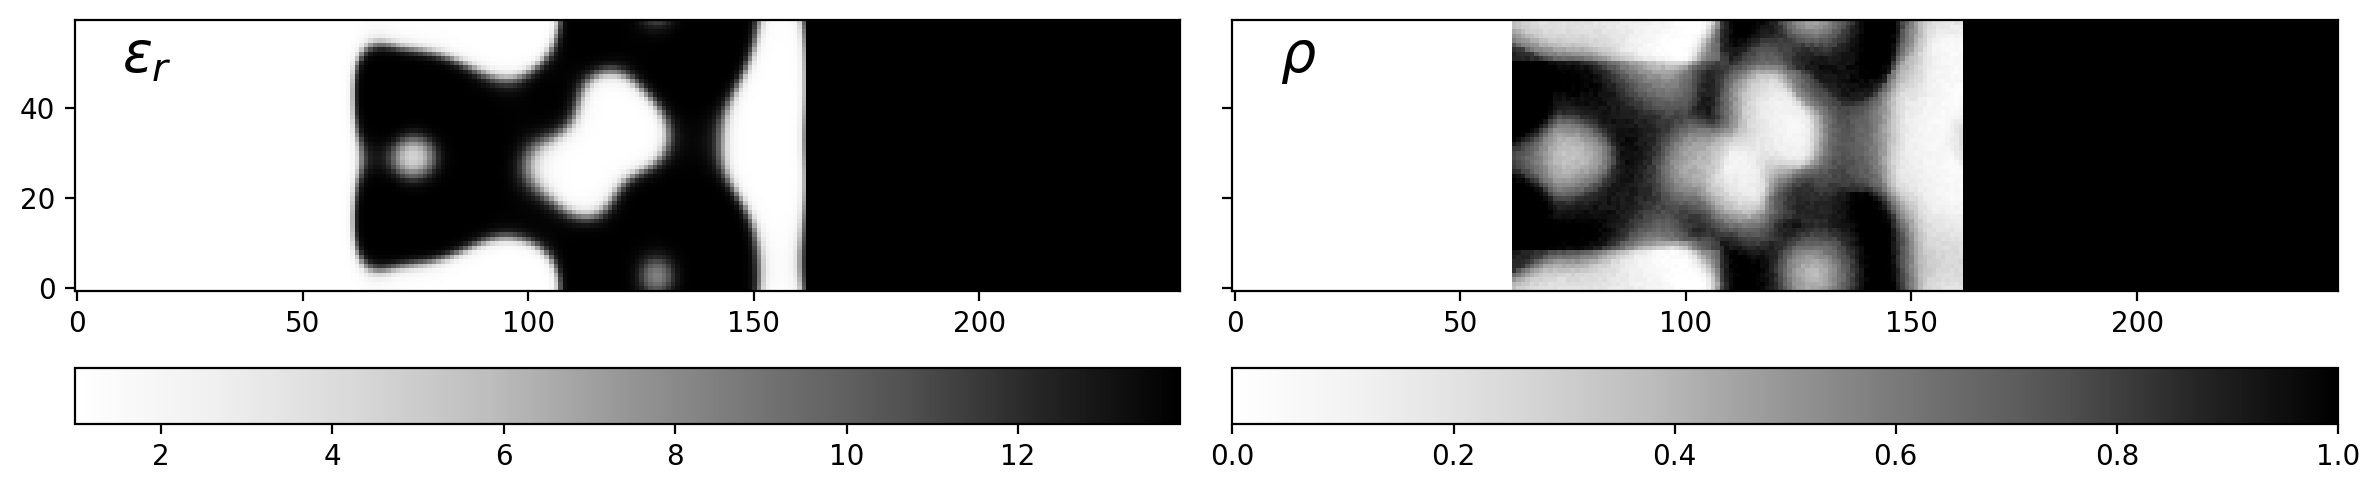

Epoch:  46/100 | Duration: 5.56 secs | Value: 9.368095e+00


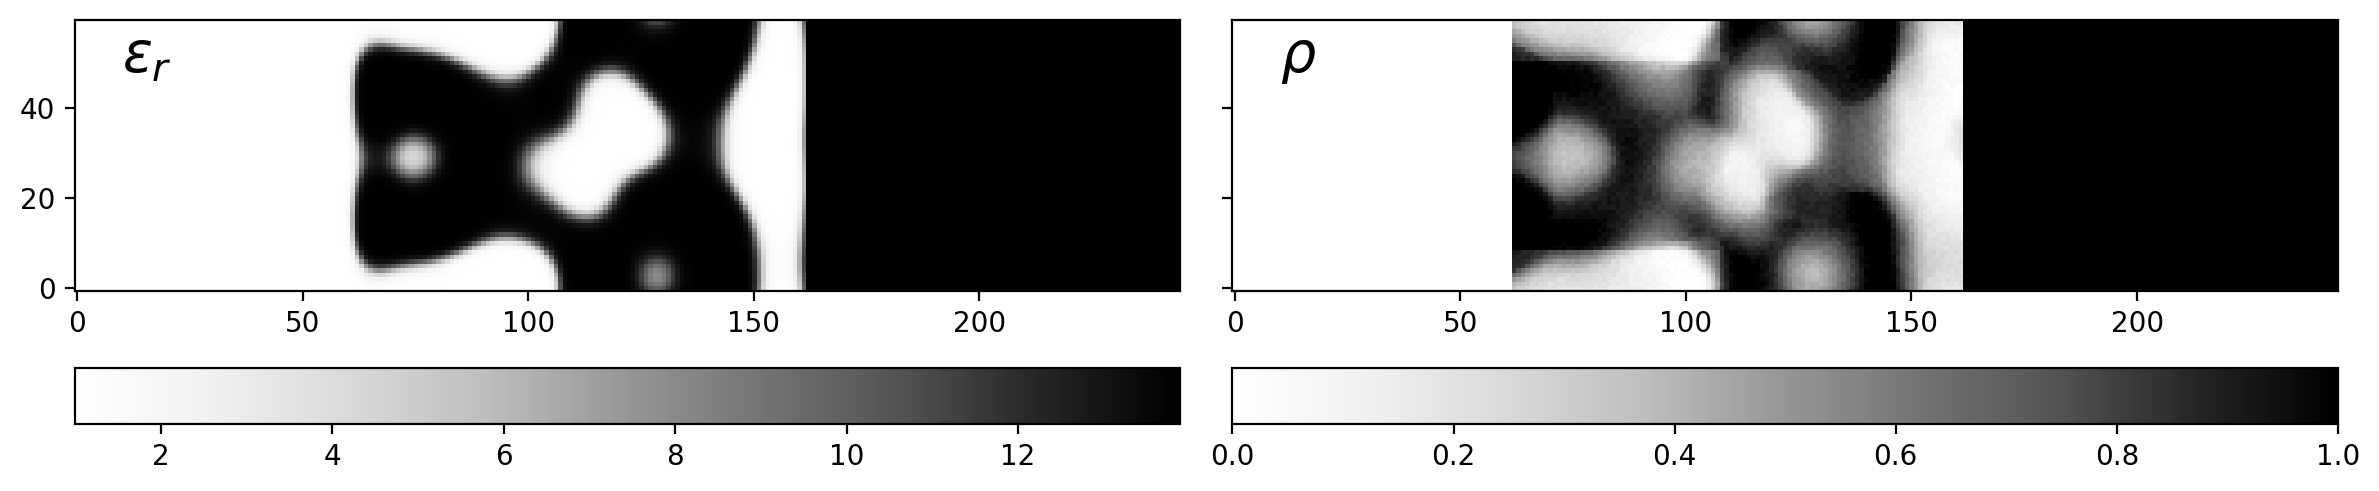

Epoch:  47/100 | Duration: 5.86 secs | Value: 1.227556e+01


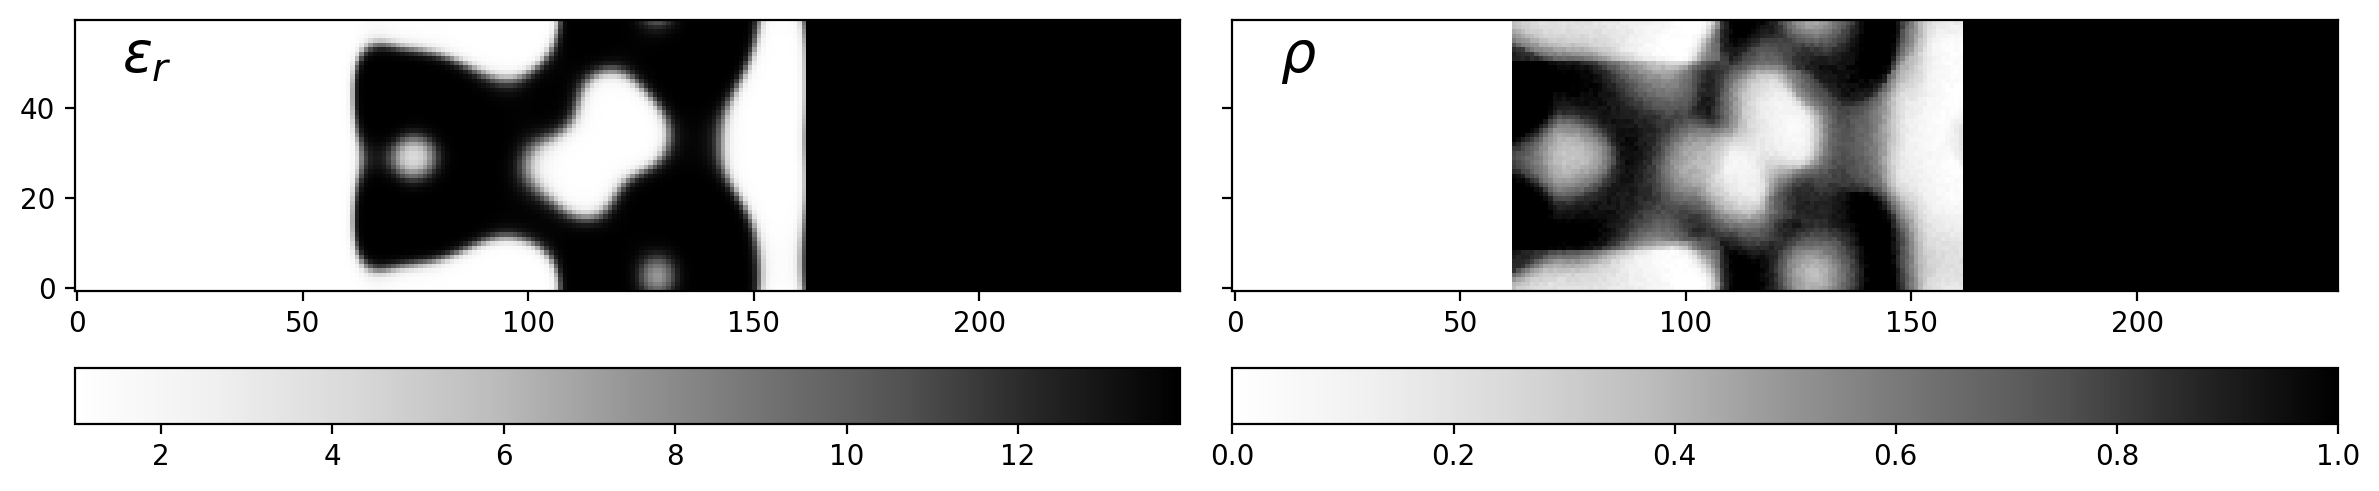

Epoch:  48/100 | Duration: 5.08 secs | Value: 1.141531e+01


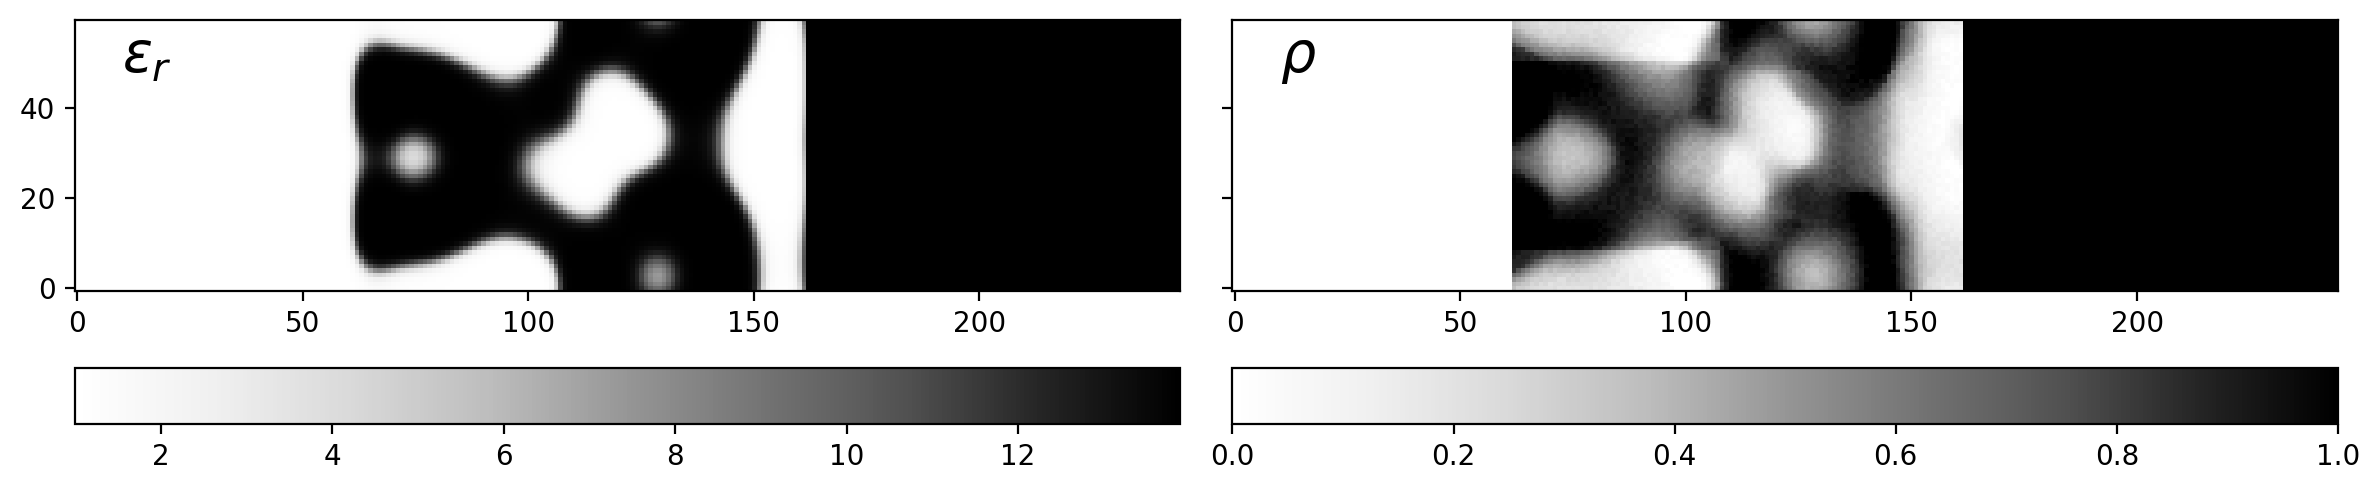

Epoch:  49/100 | Duration: 5.74 secs | Value: 9.623749e+00


Epoch:  50/100 | Duration: 6.17 secs | Value: 1.335381e+01


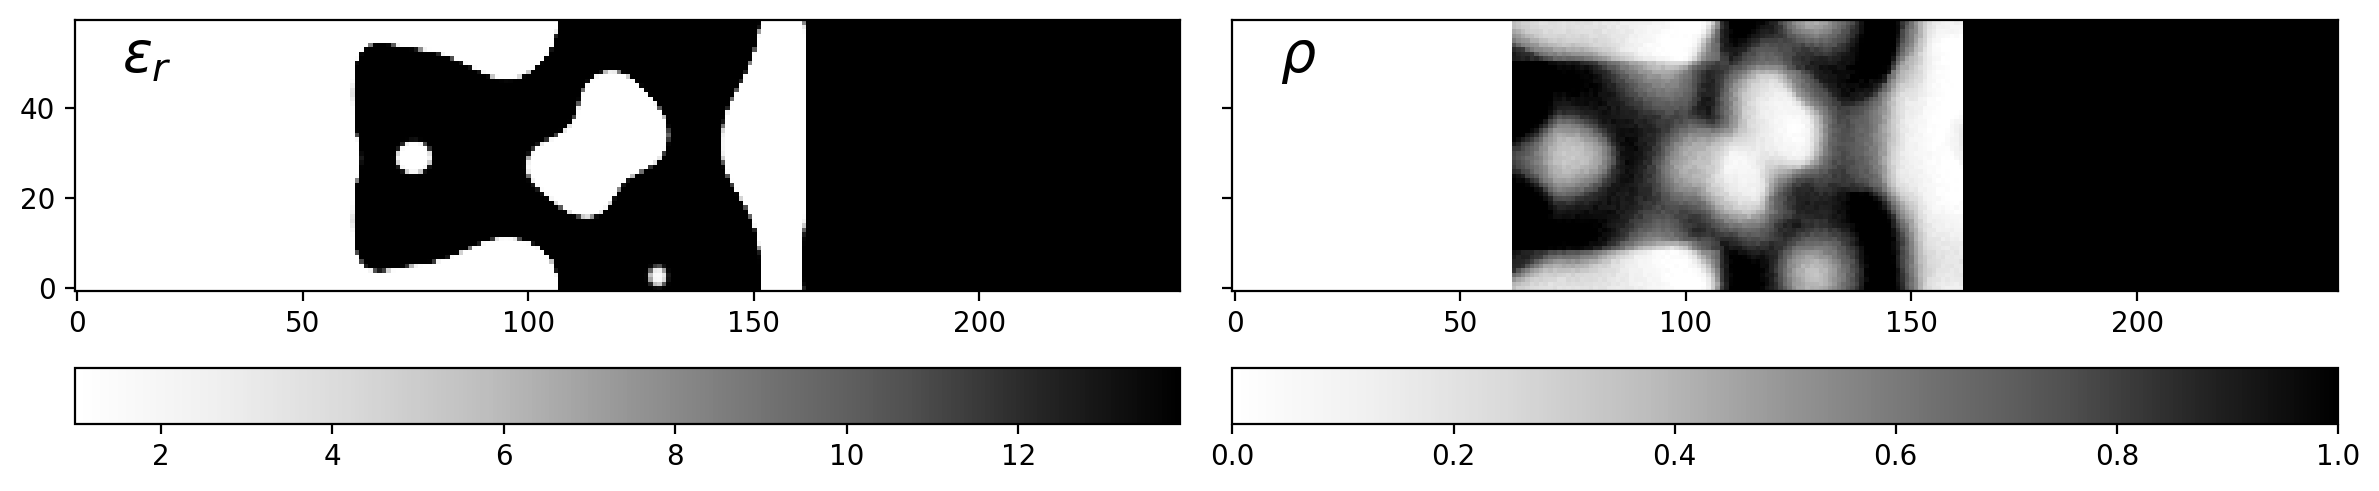

Epoch:  51/100 | Duration: 5.66 secs | Value: 9.465640e-02


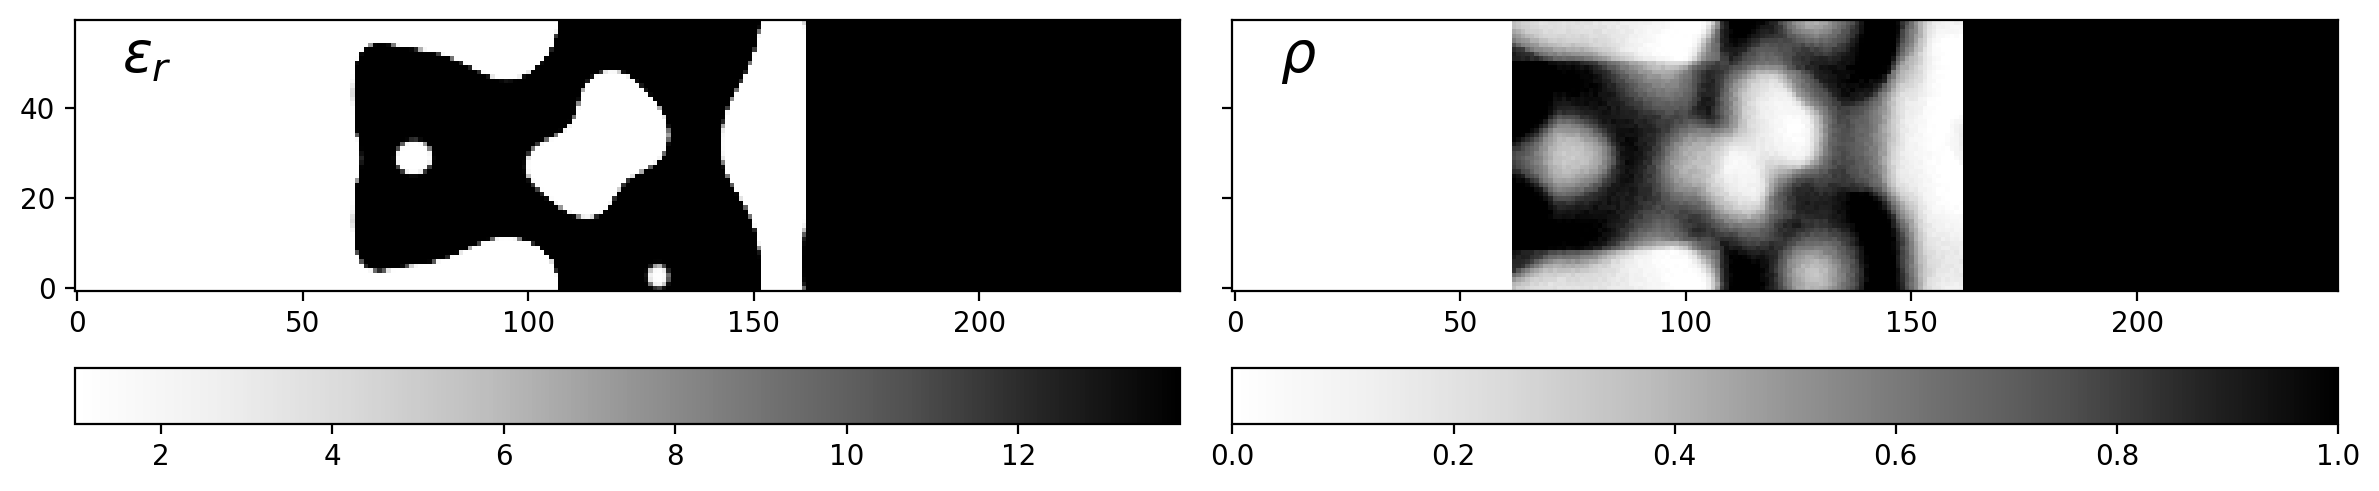

Epoch:  52/100 | Duration: 5.80 secs | Value: 6.721857e-02


Epoch:  53/100 | Duration: 5.61 secs | Value: 5.235754e-02


Epoch:  54/100 | Duration: 6.17 secs | Value: 4.257431e-02


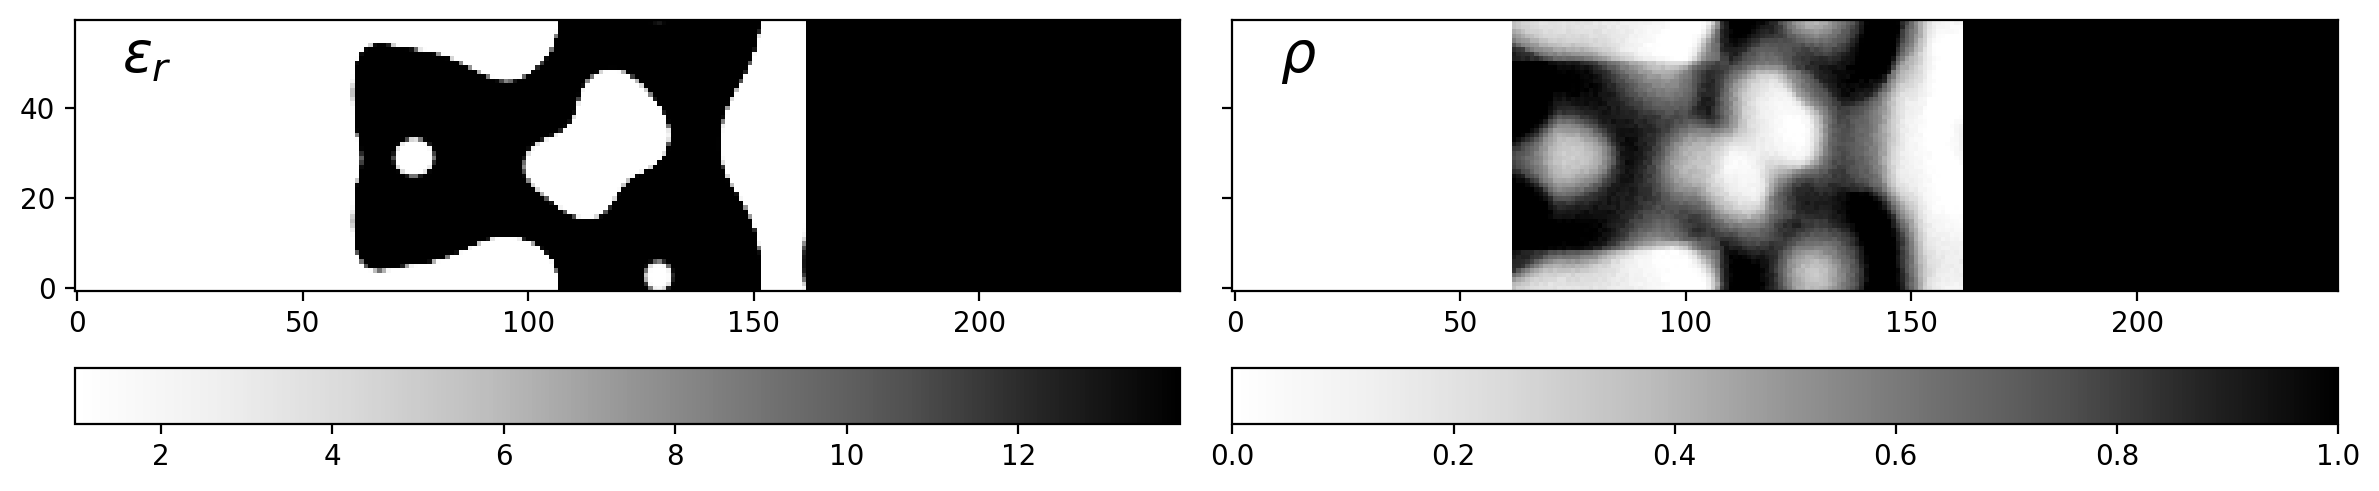

Epoch:  55/100 | Duration: 6.27 secs | Value: 3.553204e-02


Epoch:  56/100 | Duration: 5.73 secs | Value: 3.086521e-02


Epoch:  57/100 | Duration: 6.01 secs | Value: 2.820604e-02


Epoch:  58/100 | Duration: 5.85 secs | Value: 2.704946e-02


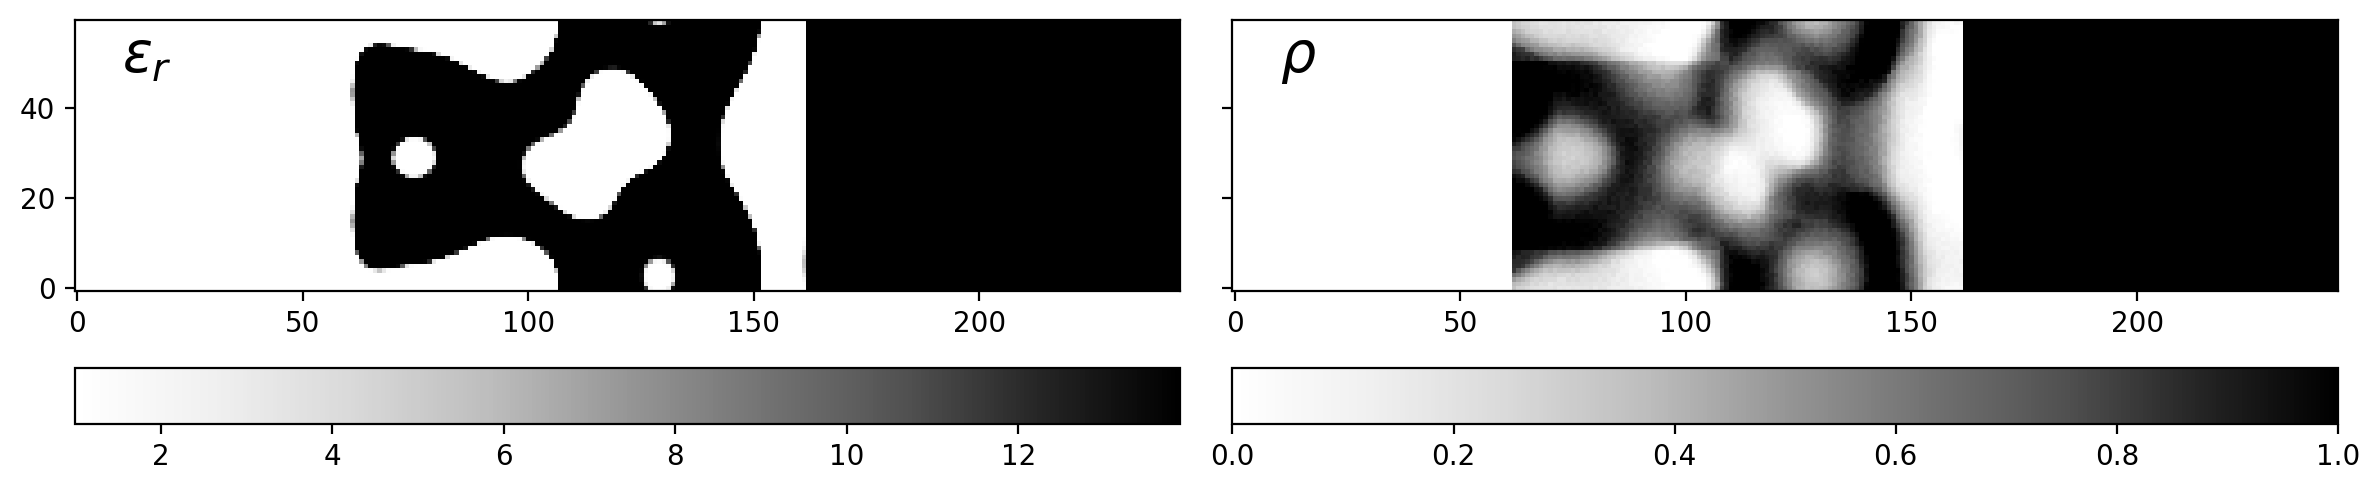

Epoch:  59/100 | Duration: 6.11 secs | Value: 2.694621e-02


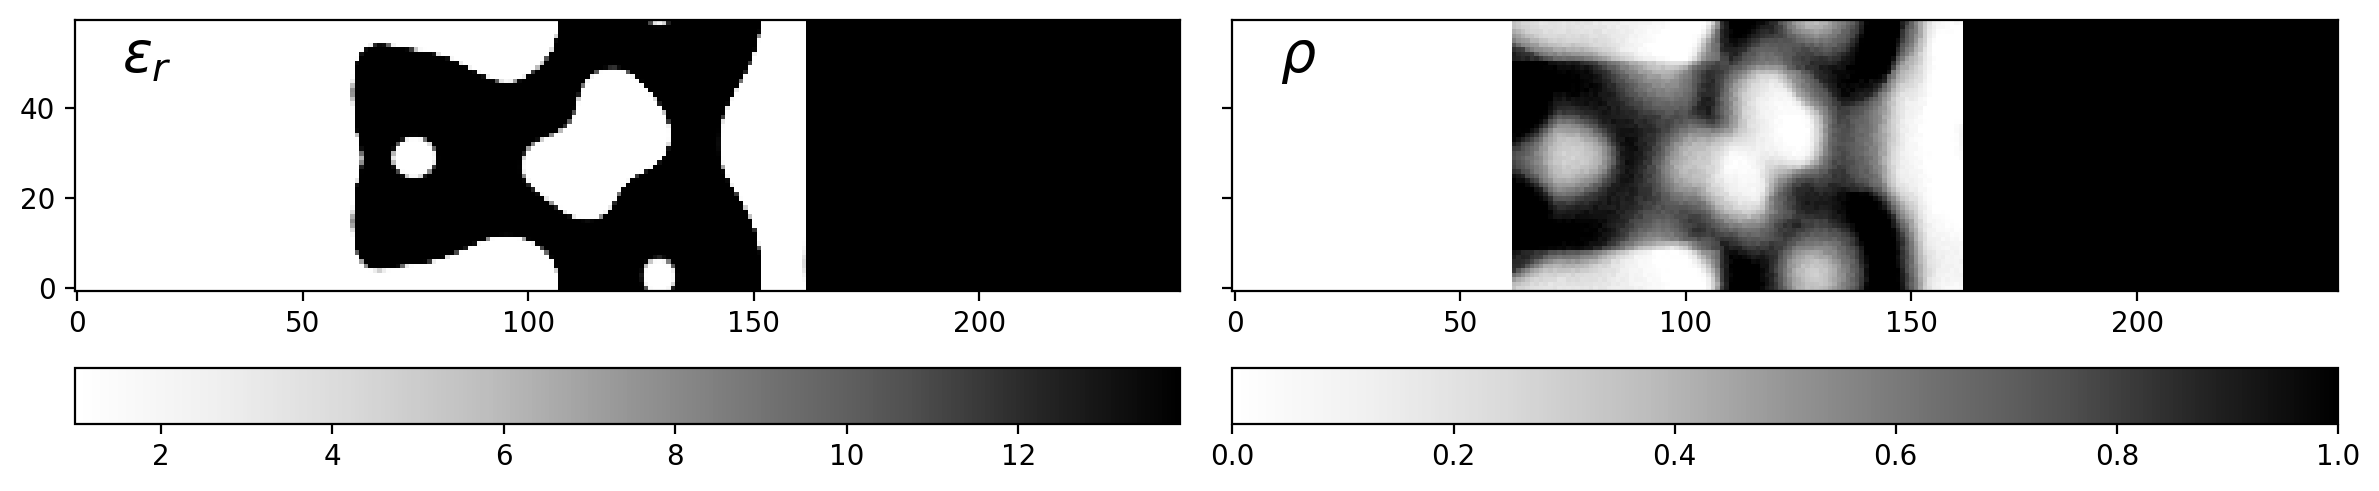

Epoch:  60/100 | Duration: 5.95 secs | Value: 2.759088e-02


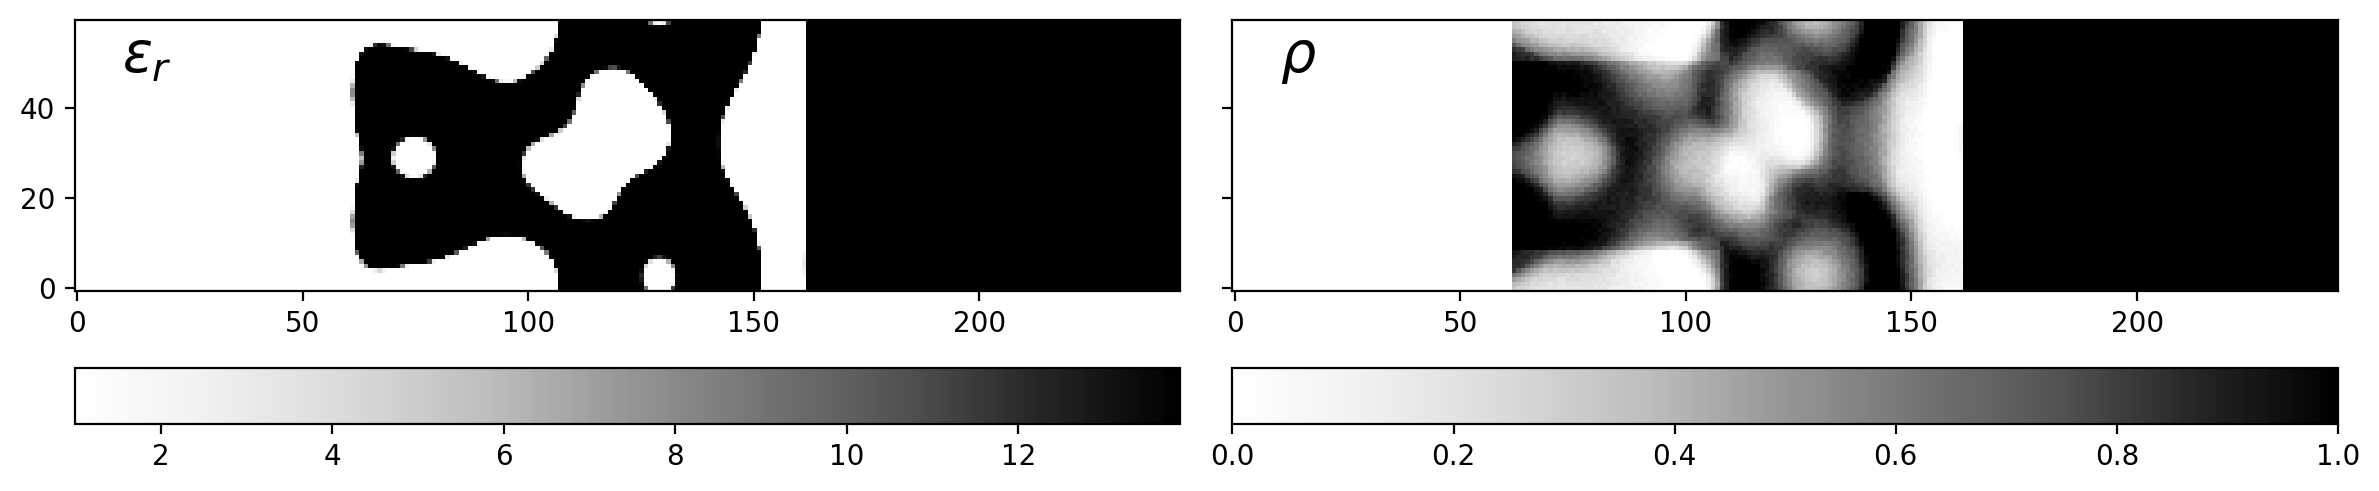

Epoch:  61/100 | Duration: 5.56 secs | Value: 2.884145e-02


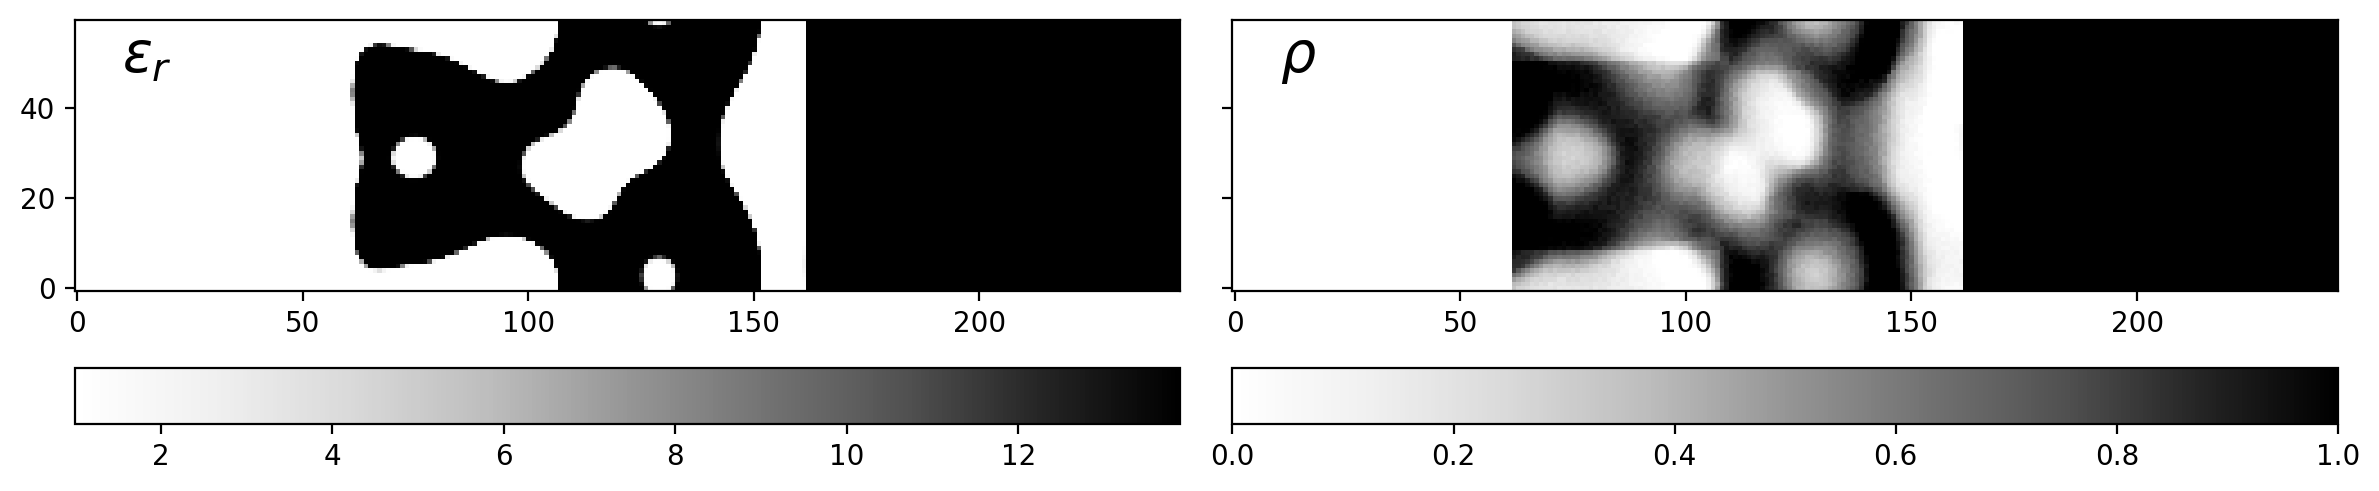

Epoch:  62/100 | Duration: 5.82 secs | Value: 3.064818e-02


Epoch:  63/100 | Duration: 5.83 secs | Value: 3.296752e-02


Epoch:  64/100 | Duration: 5.66 secs | Value: 3.572352e-02


Epoch:  65/100 | Duration: 5.74 secs | Value: 3.881943e-02


Epoch:  66/100 | Duration: 6.05 secs | Value: 4.216784e-02


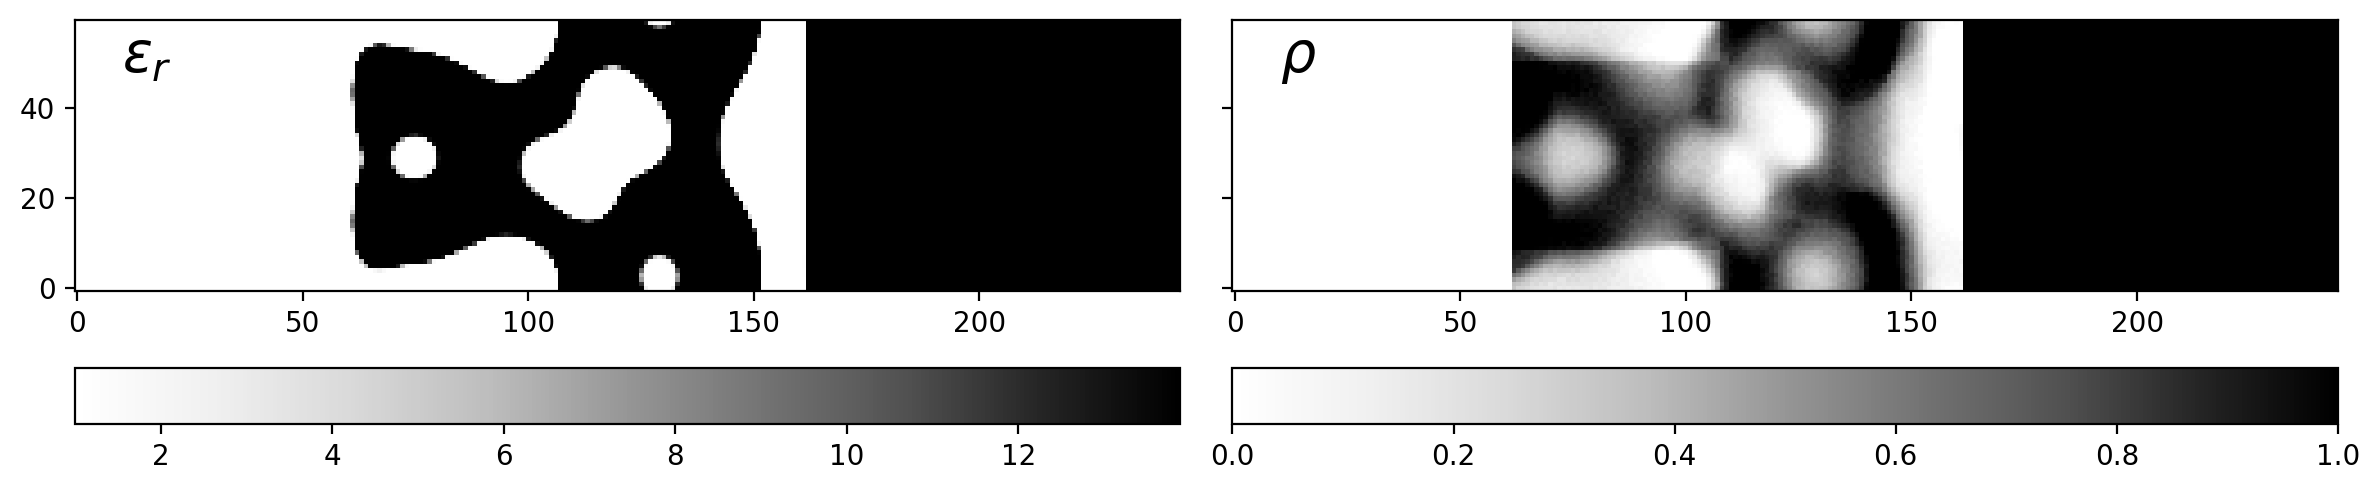

Epoch:  67/100 | Duration: 5.60 secs | Value: 4.571076e-02


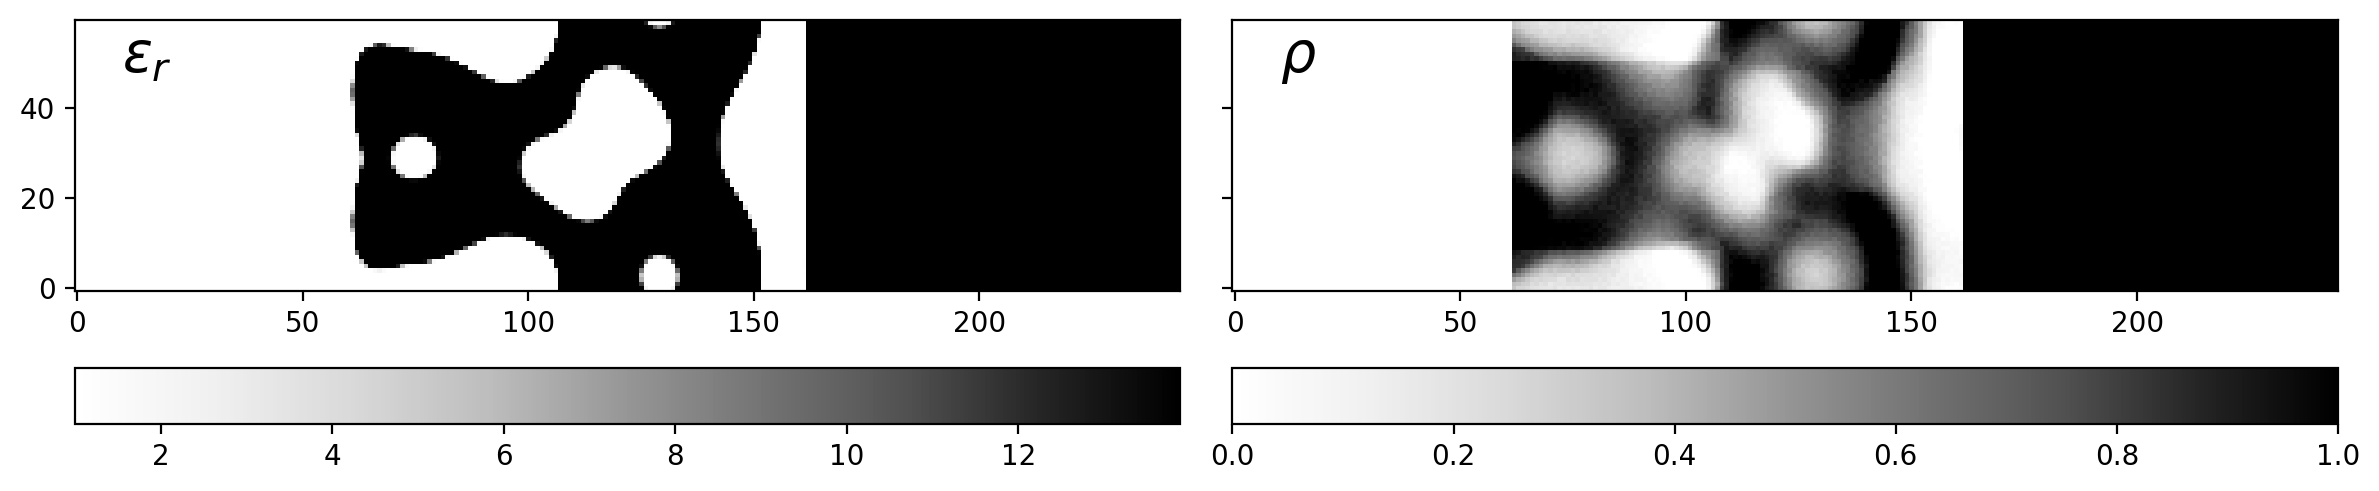

Epoch:  68/100 | Duration: 6.18 secs | Value: 4.942205e-02


Epoch:  69/100 | Duration: 5.93 secs | Value: 5.329965e-02


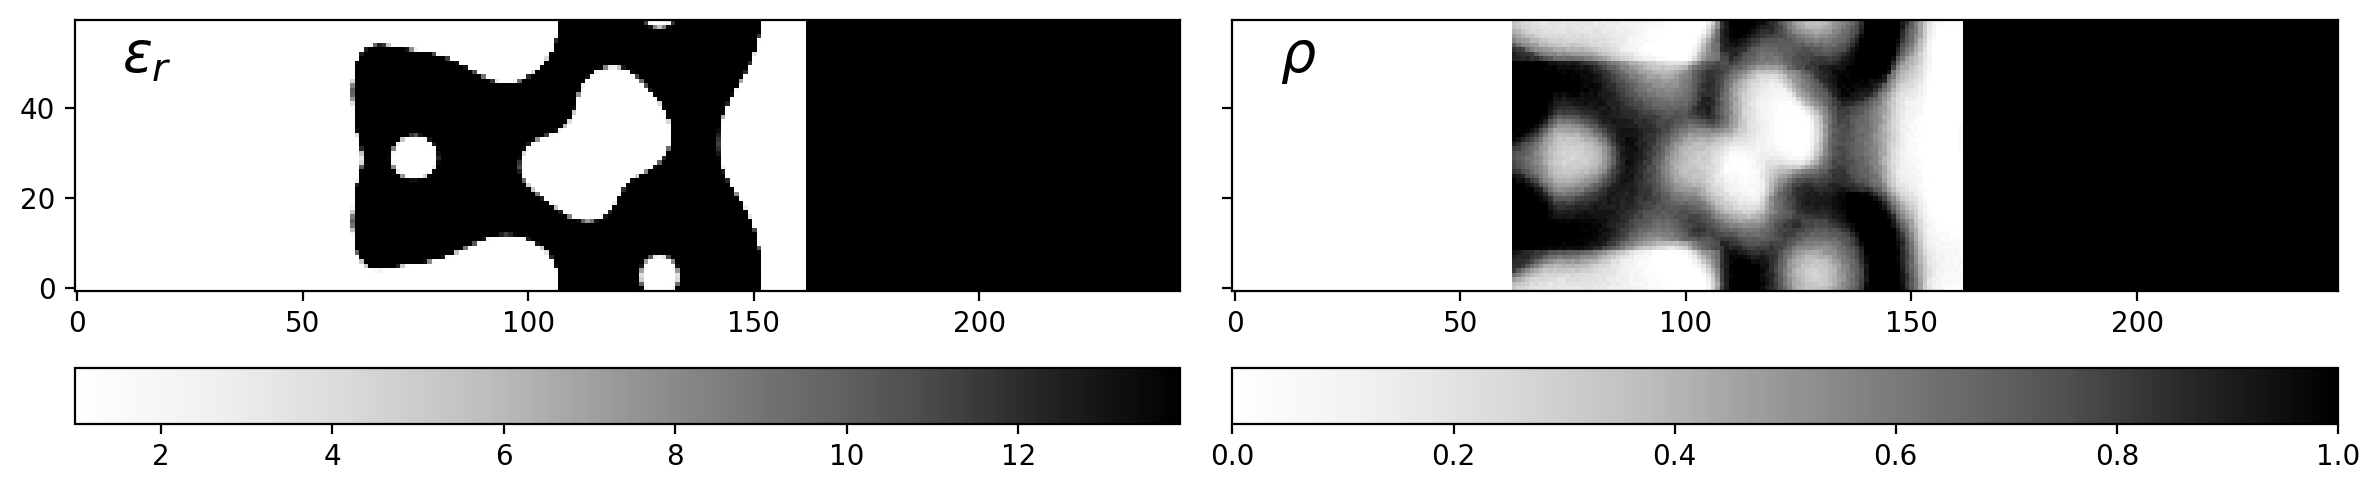

Epoch:  70/100 | Duration: 6.18 secs | Value: 5.735610e-02


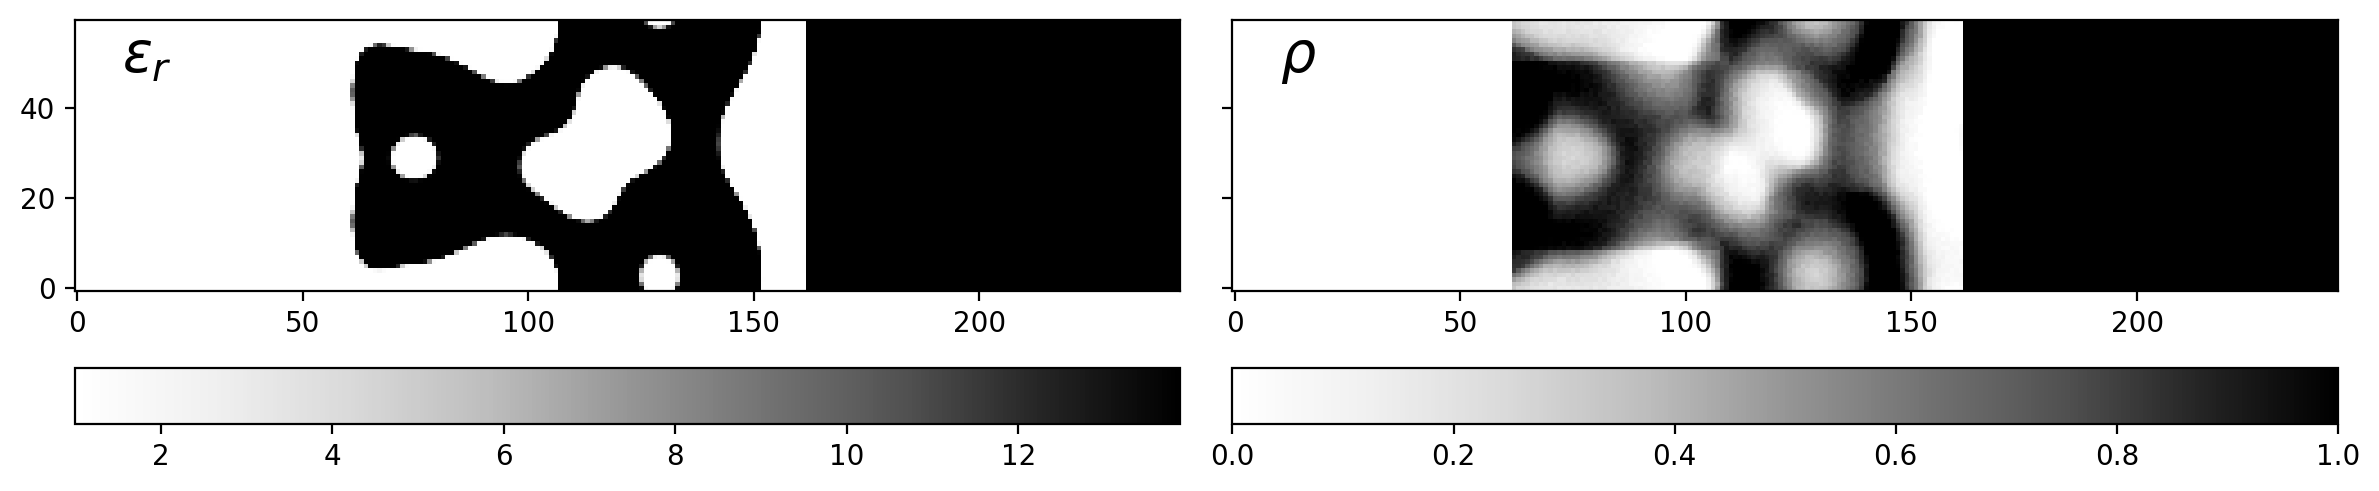

Epoch:  71/100 | Duration: 5.55 secs | Value: 6.161134e-02


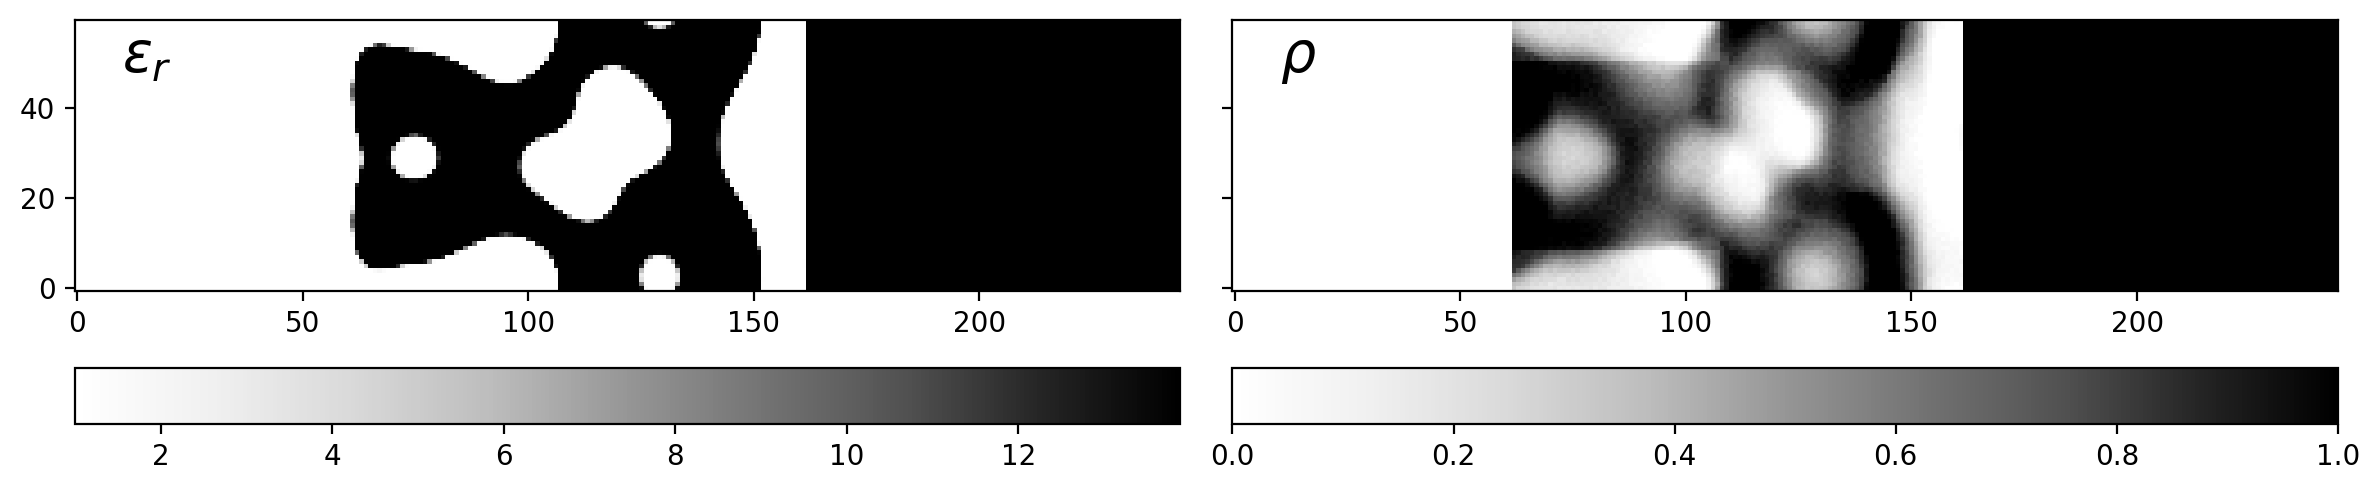

Epoch:  72/100 | Duration: 5.99 secs | Value: 6.608790e-02


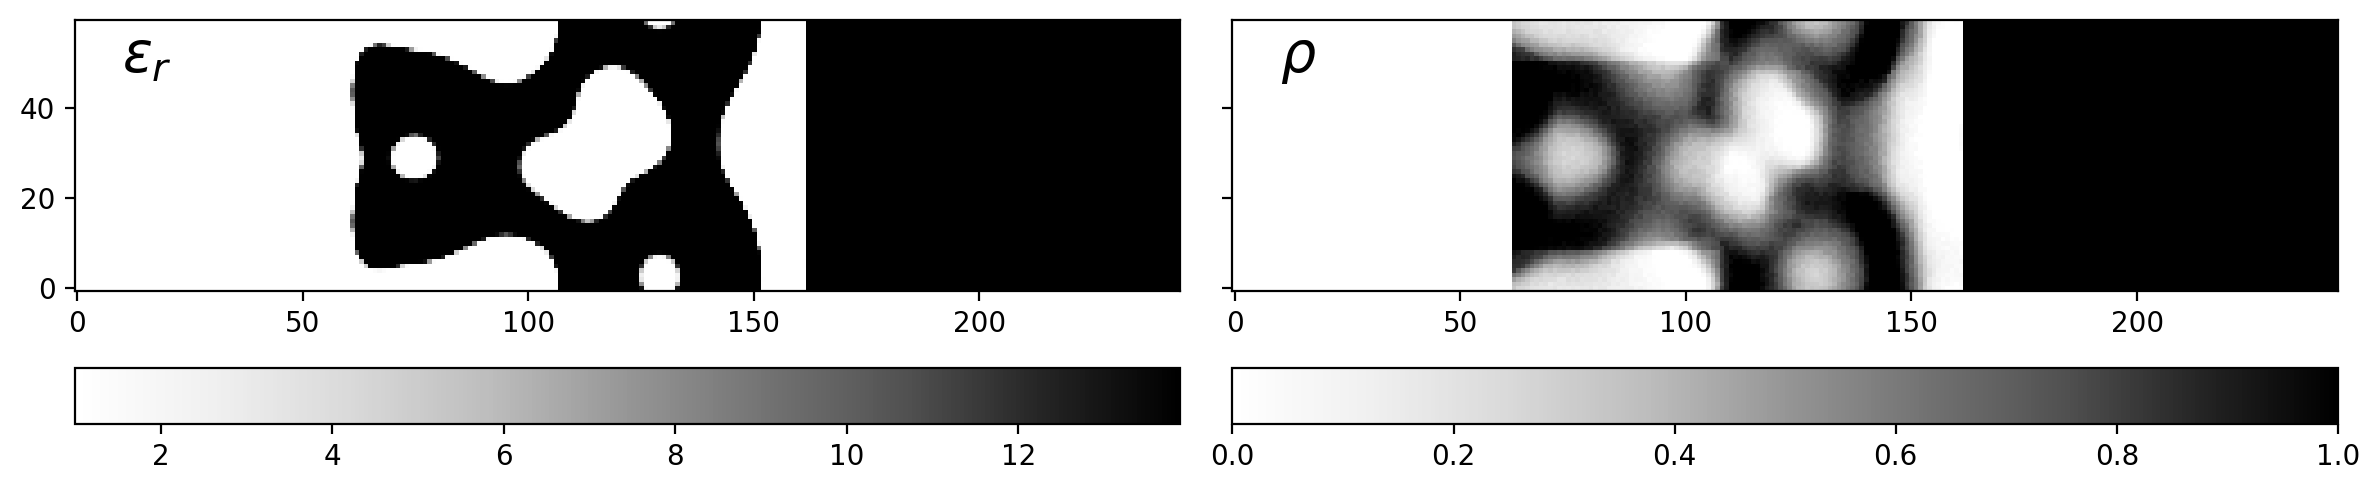

Epoch:  73/100 | Duration: 5.60 secs | Value: 7.080675e-02


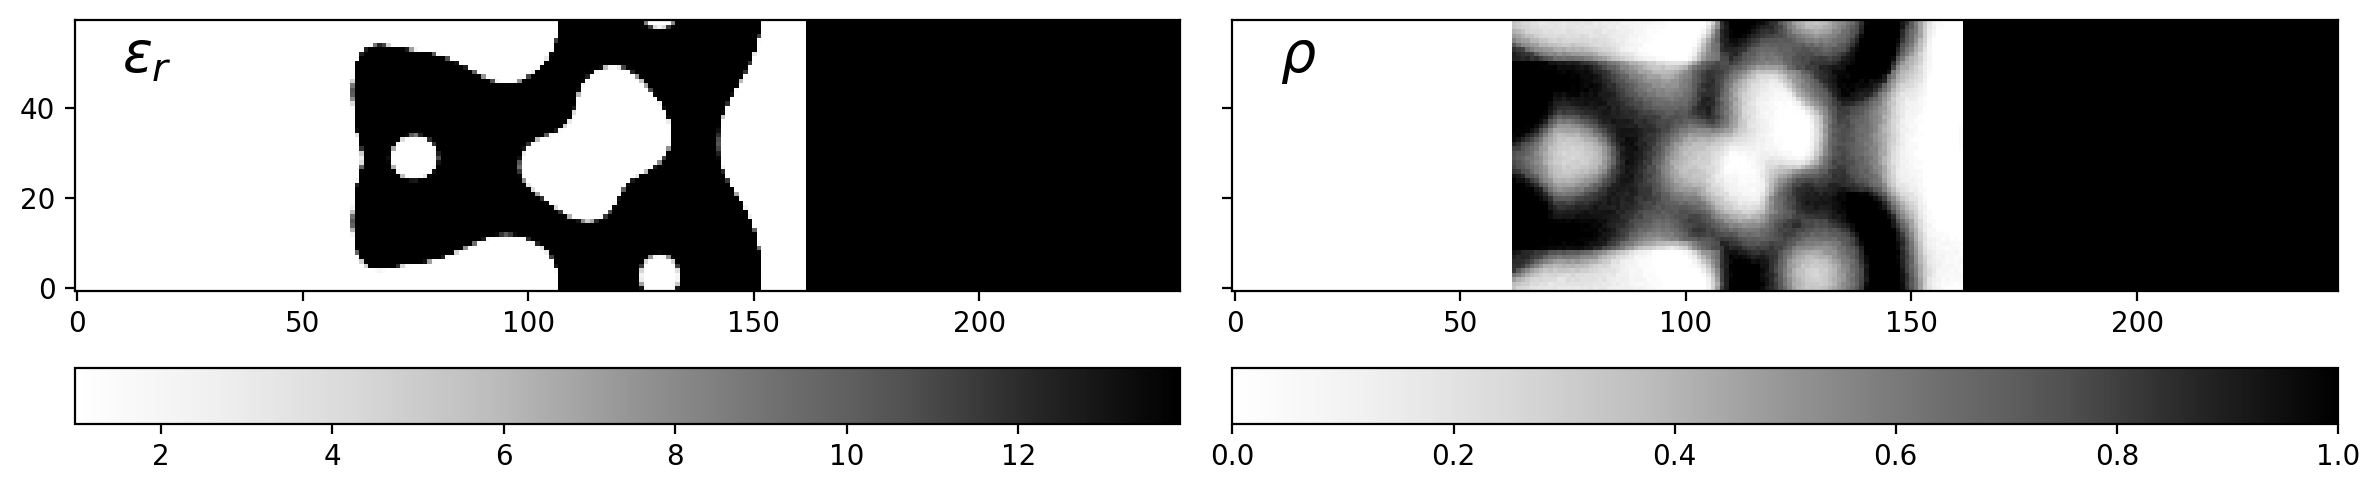

Epoch:  74/100 | Duration: 5.37 secs | Value: 7.578282e-02


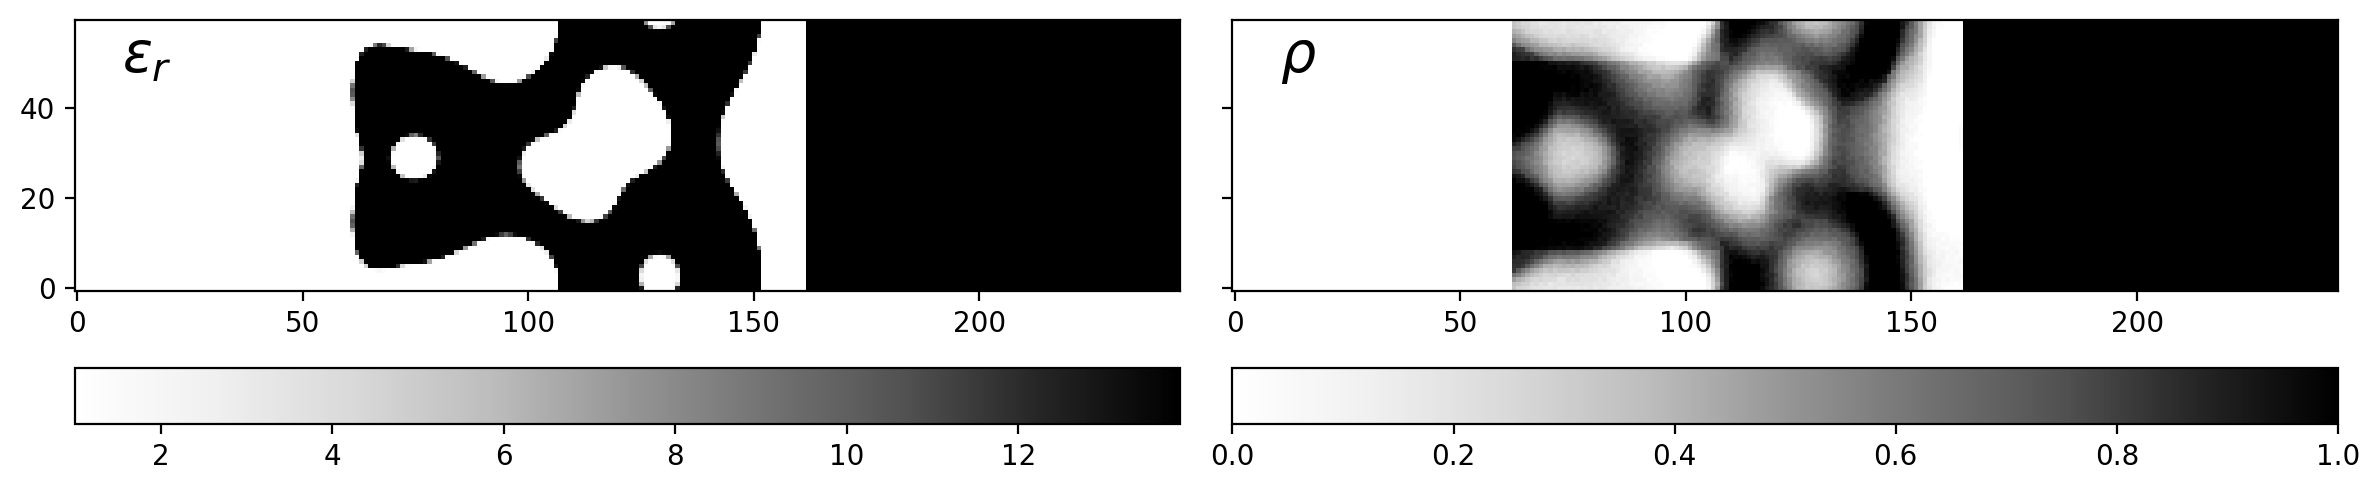

Epoch:  75/100 | Duration: 5.22 secs | Value: 8.102011e-02


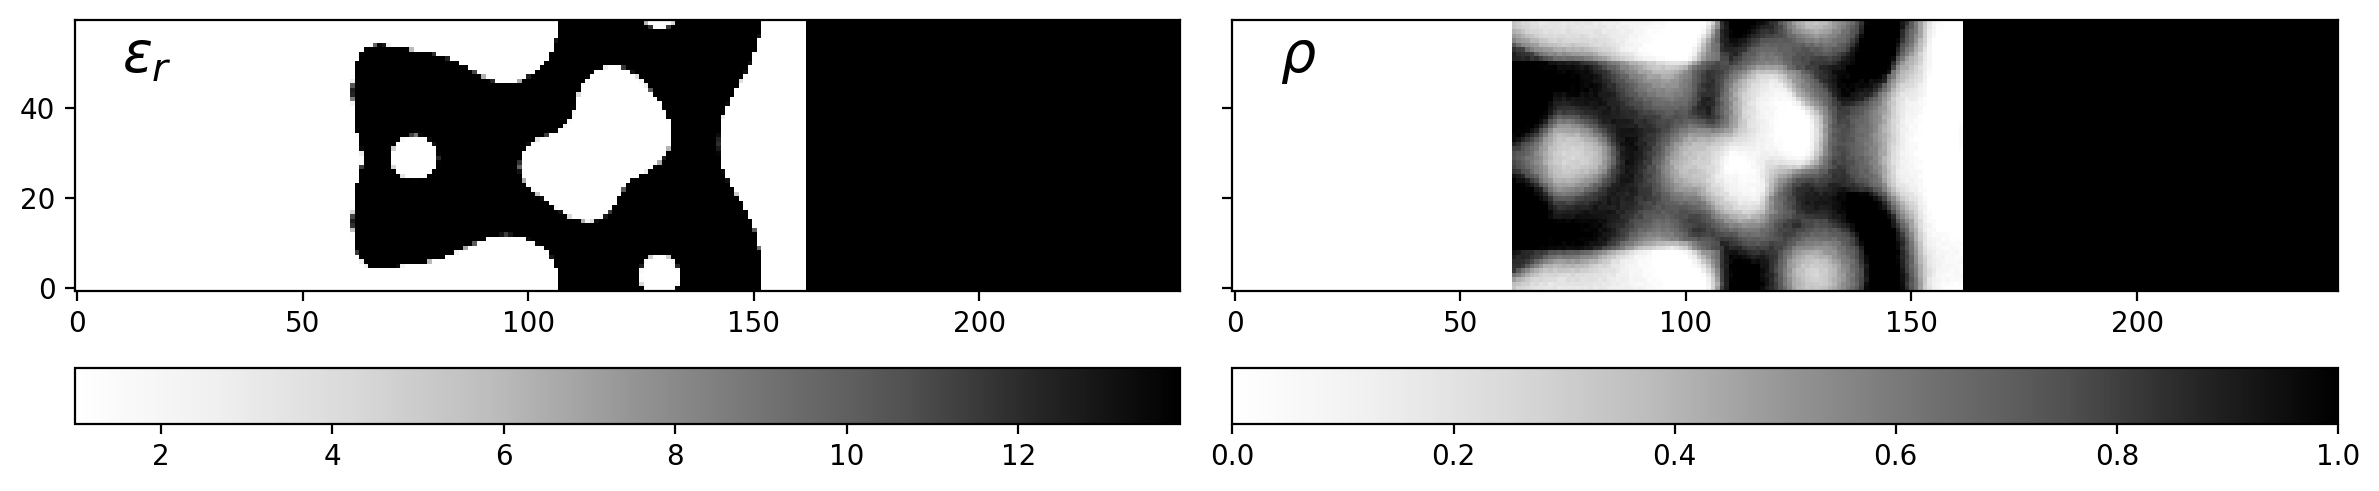

Epoch:  76/100 | Duration: 5.61 secs | Value: 8.953438e-02


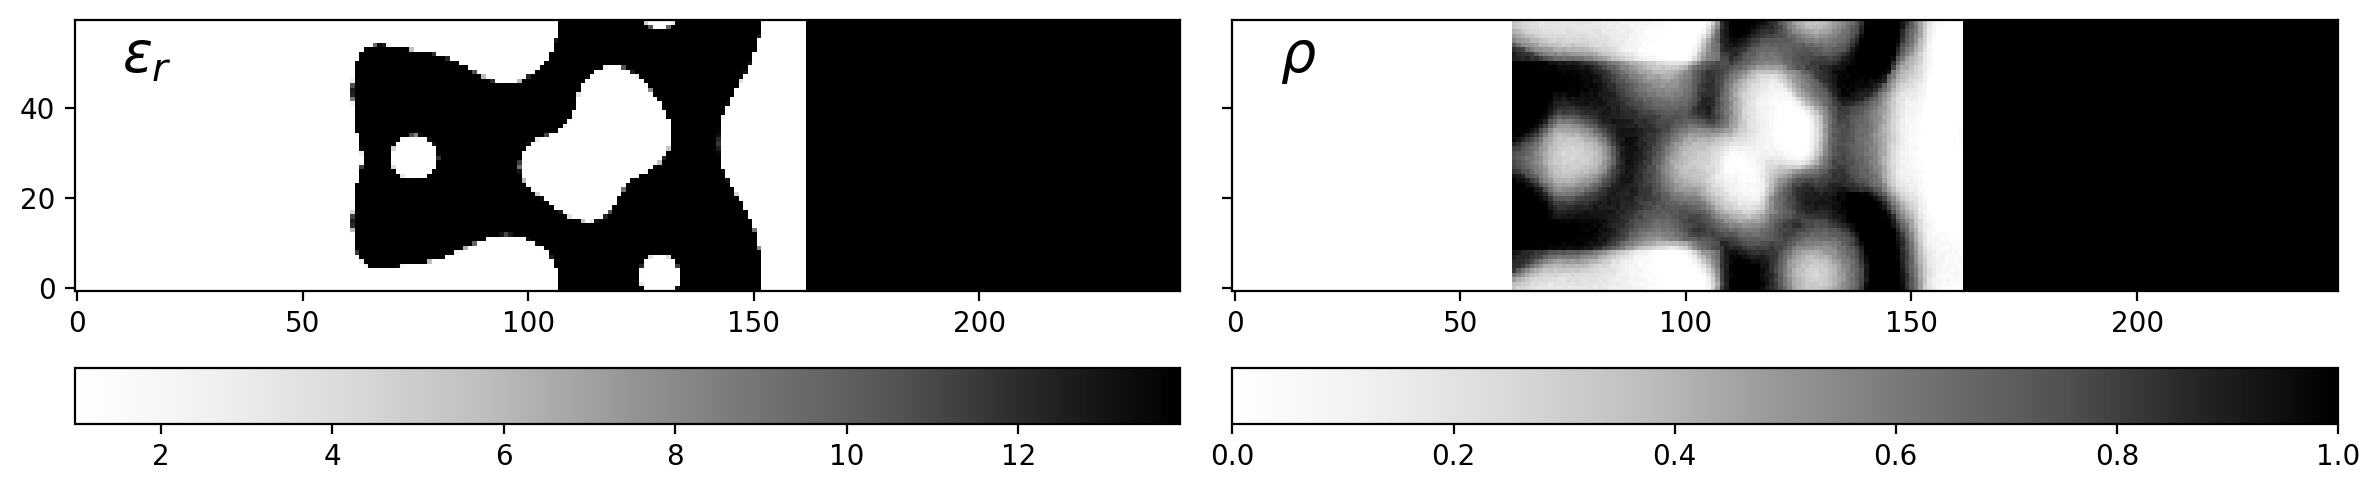

Epoch:  77/100 | Duration: 6.10 secs | Value: 9.548482e-02


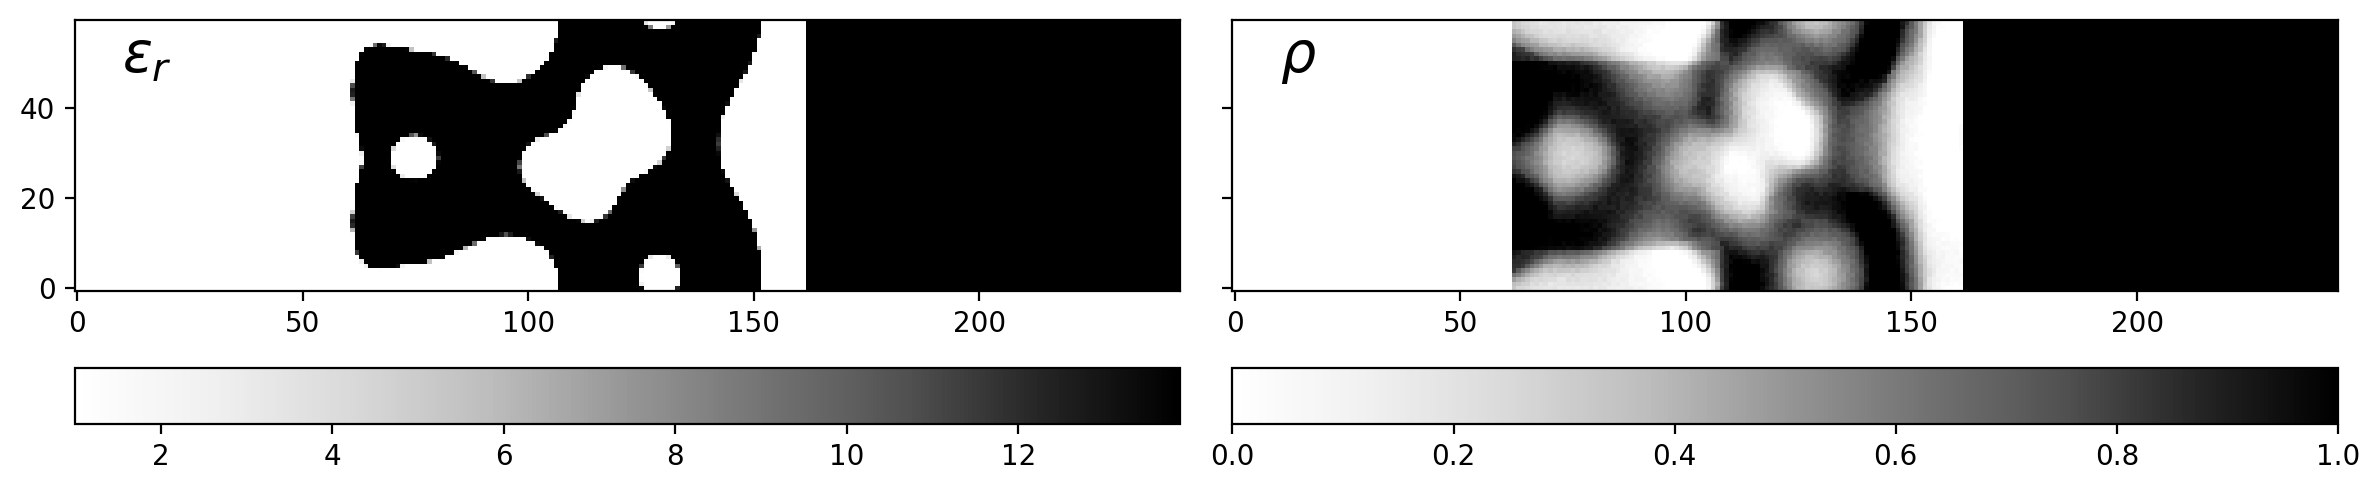

Epoch:  78/100 | Duration: 5.76 secs | Value: 1.016224e-01


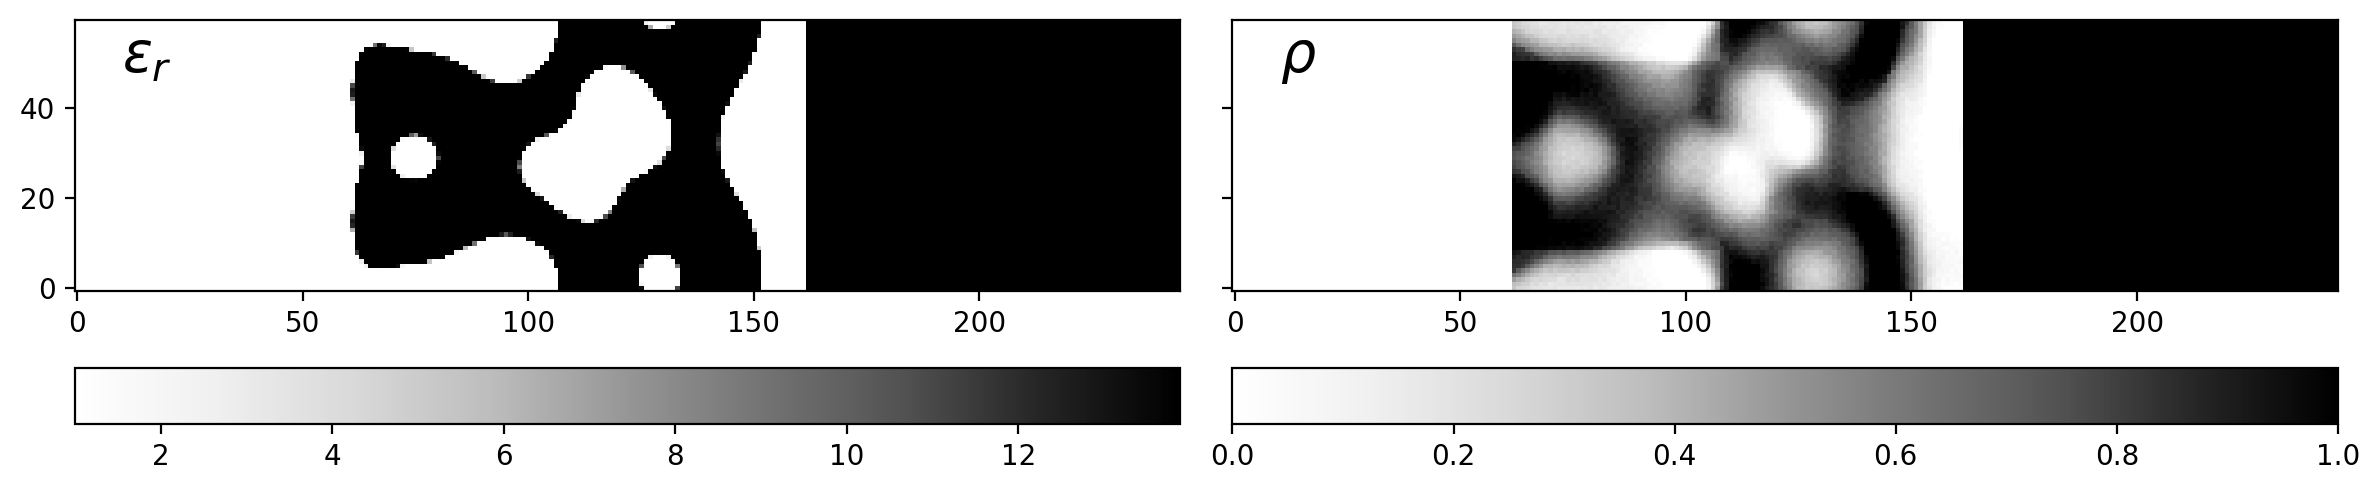

Epoch:  79/100 | Duration: 5.84 secs | Value: 1.080665e-01


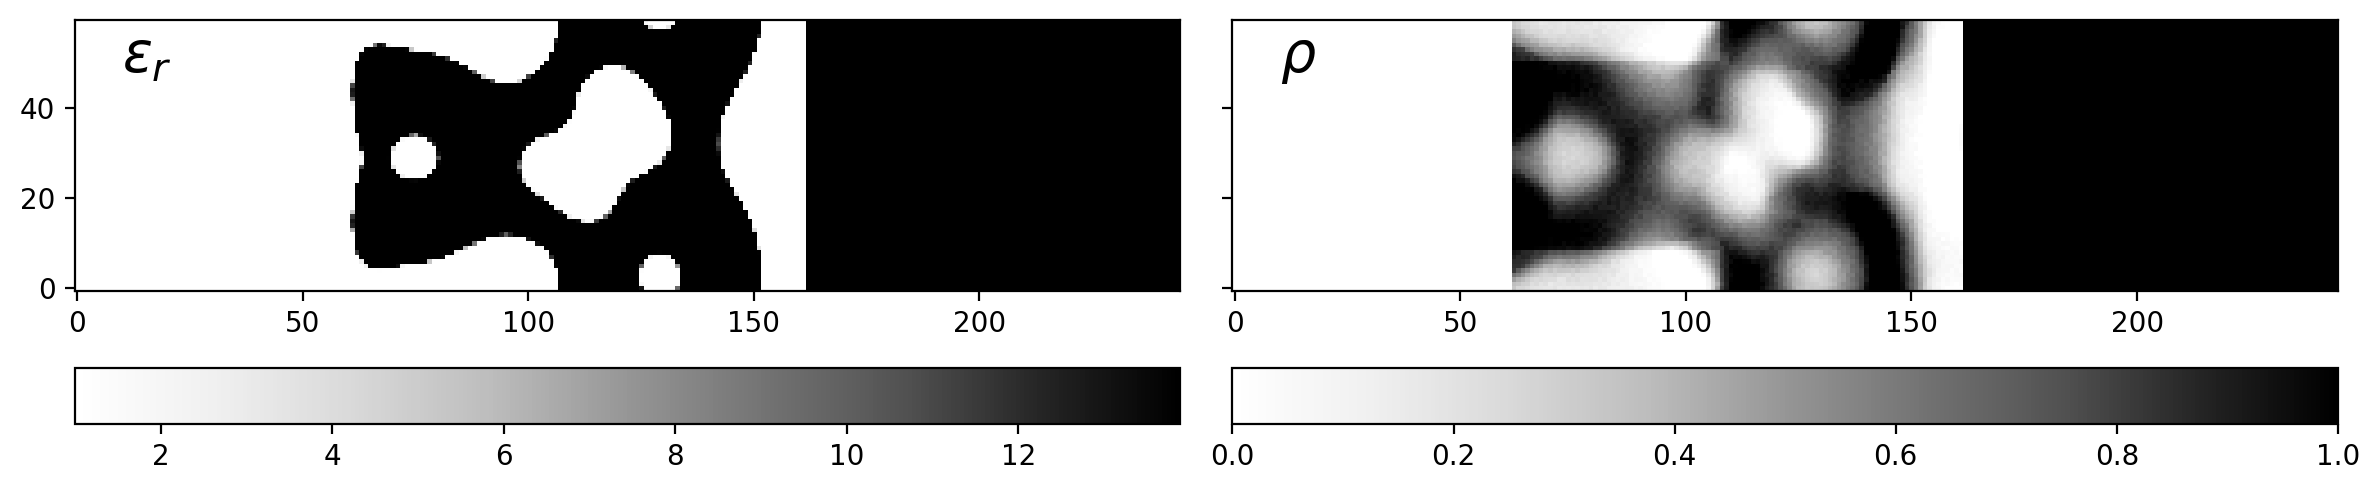

Epoch:  80/100 | Duration: 5.93 secs | Value: 1.147798e-01


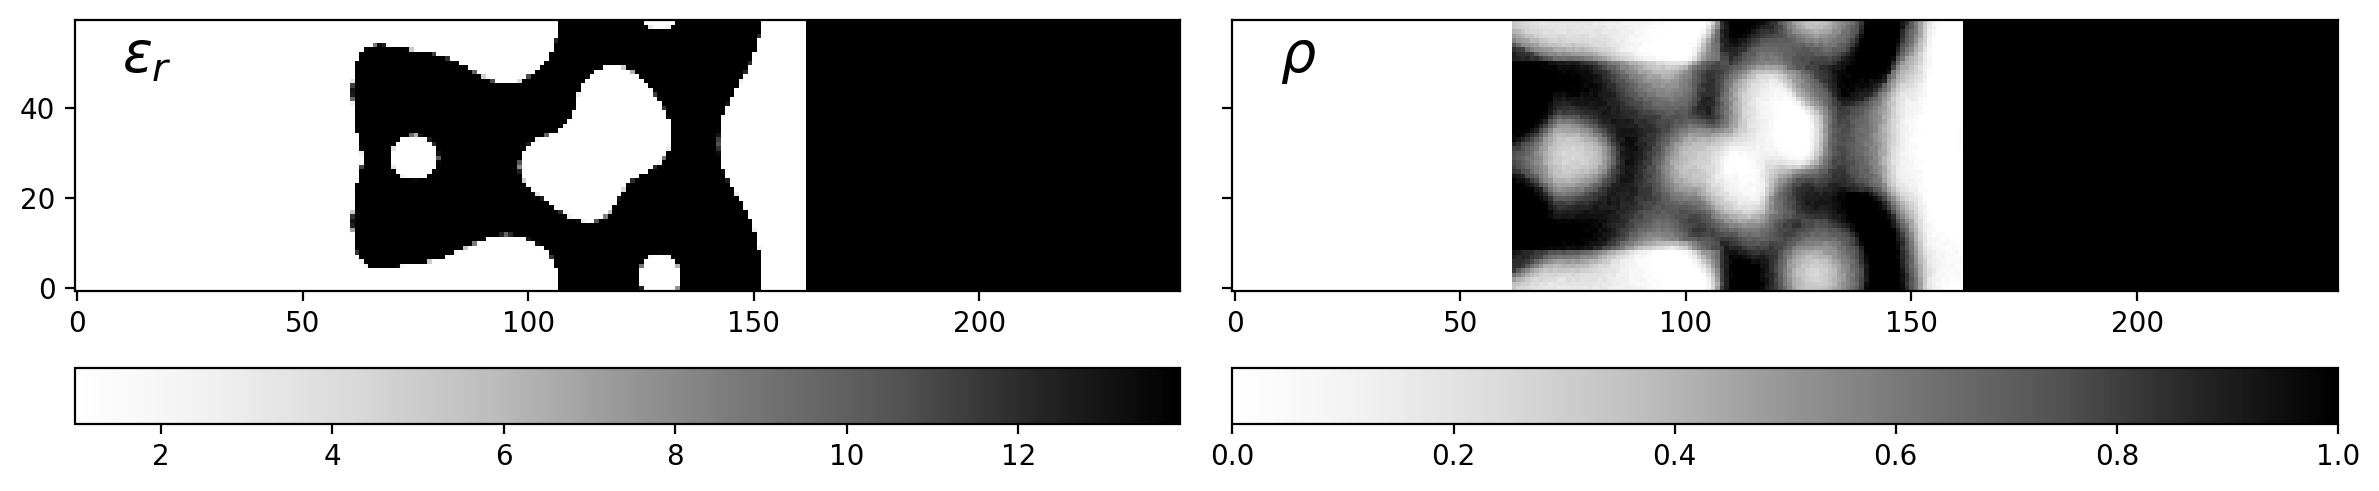

Epoch:  81/100 | Duration: 5.48 secs | Value: 1.215711e-01


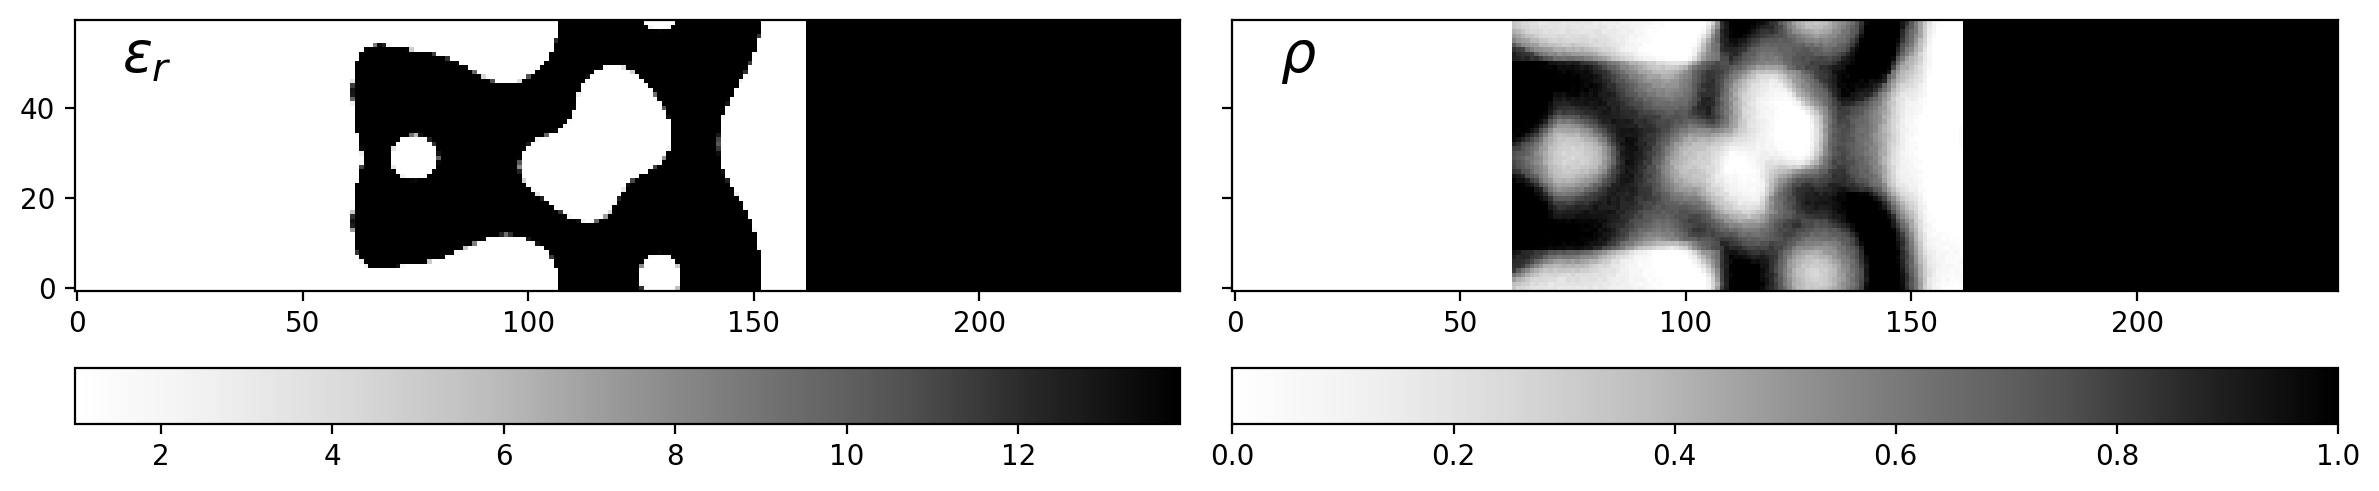

Epoch:  82/100 | Duration: 6.07 secs | Value: 1.281936e-01


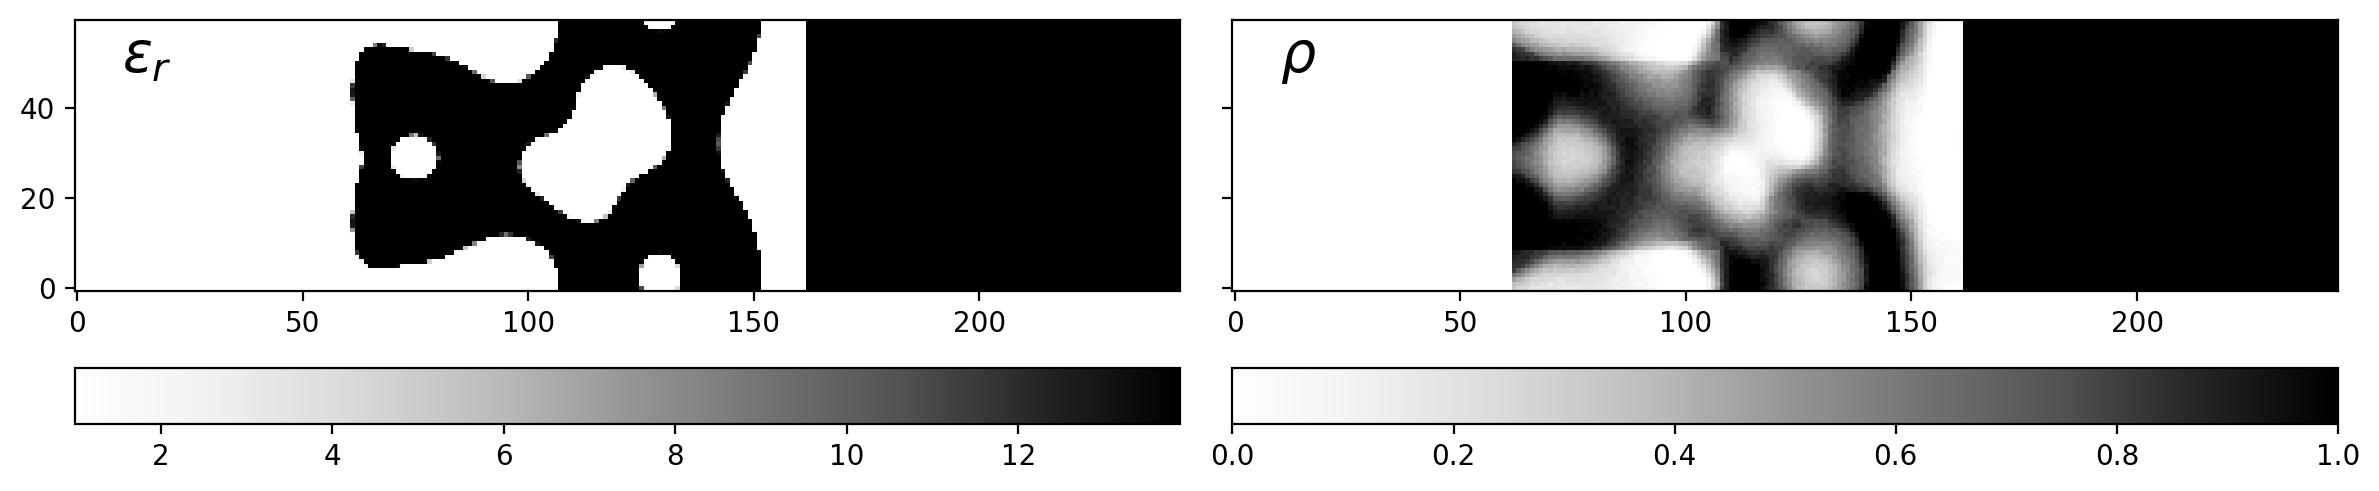

Epoch:  83/100 | Duration: 6.02 secs | Value: 1.344398e-01


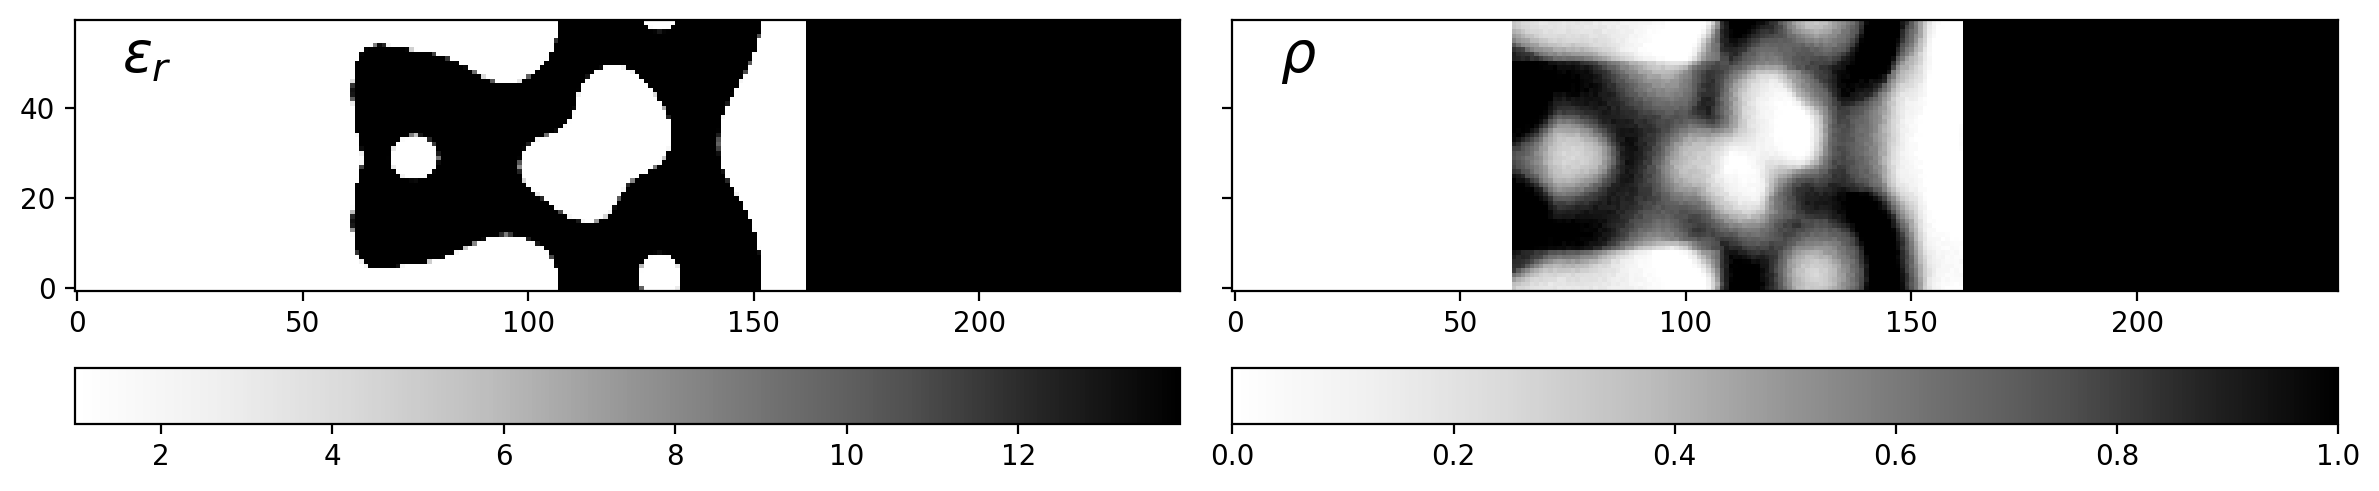

Epoch:  84/100 | Duration: 5.99 secs | Value: 1.401990e-01


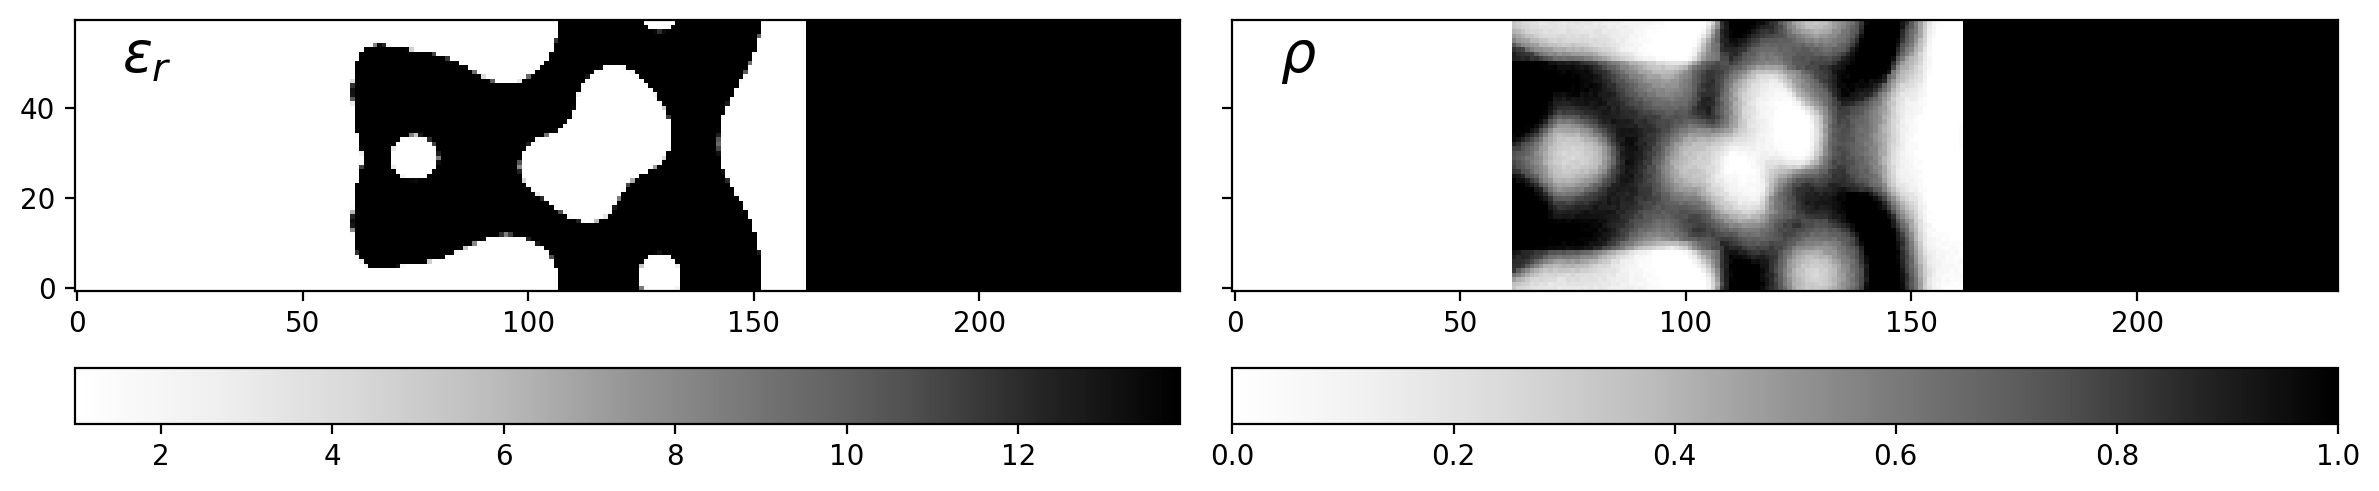

Epoch:  85/100 | Duration: 6.11 secs | Value: 1.454830e-01


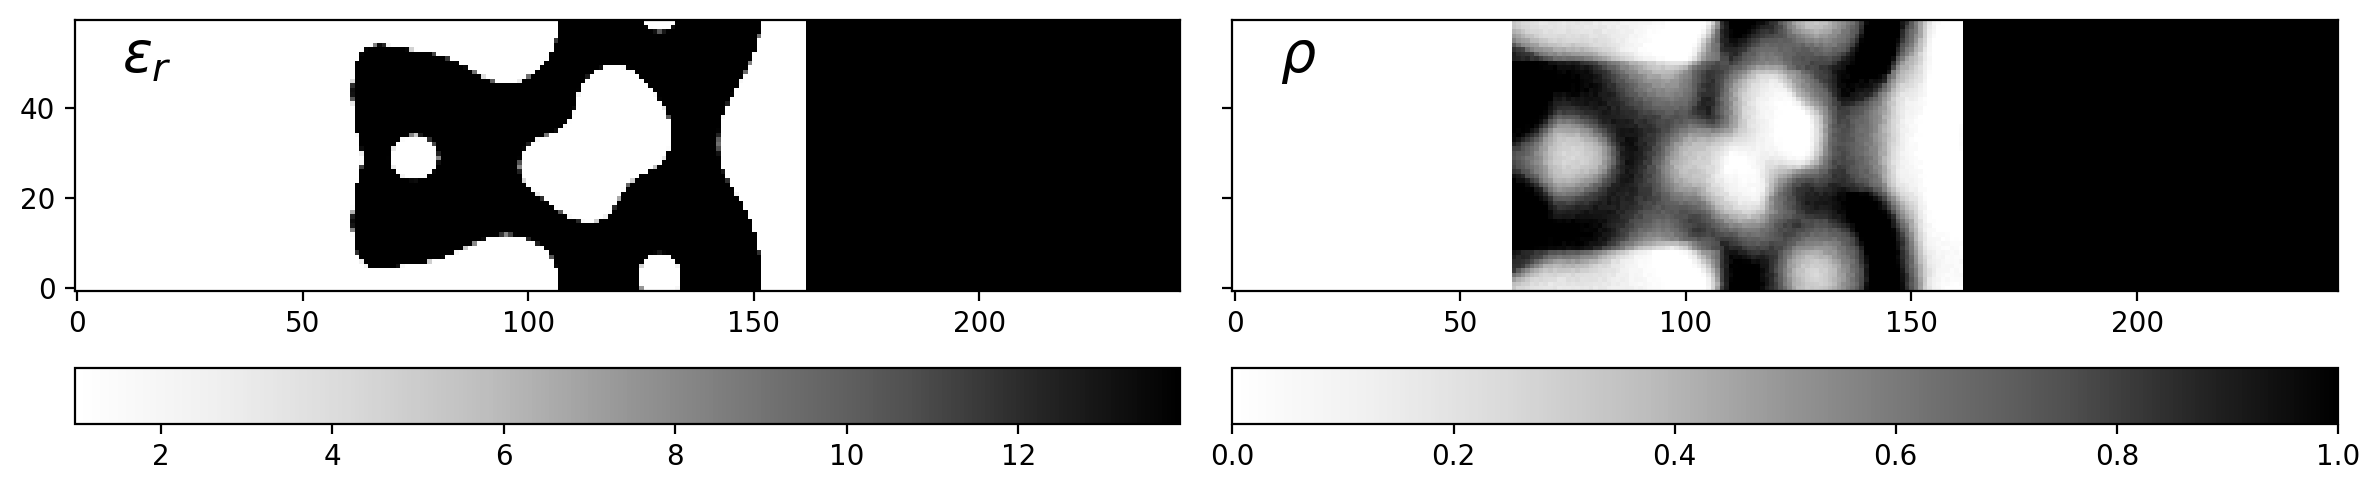

Epoch:  86/100 | Duration: 6.58 secs | Value: 1.504432e-01


Epoch:  87/100 | Duration: 6.34 secs | Value: 1.553260e-01


Epoch:  88/100 | Duration: 5.77 secs | Value: 1.603649e-01


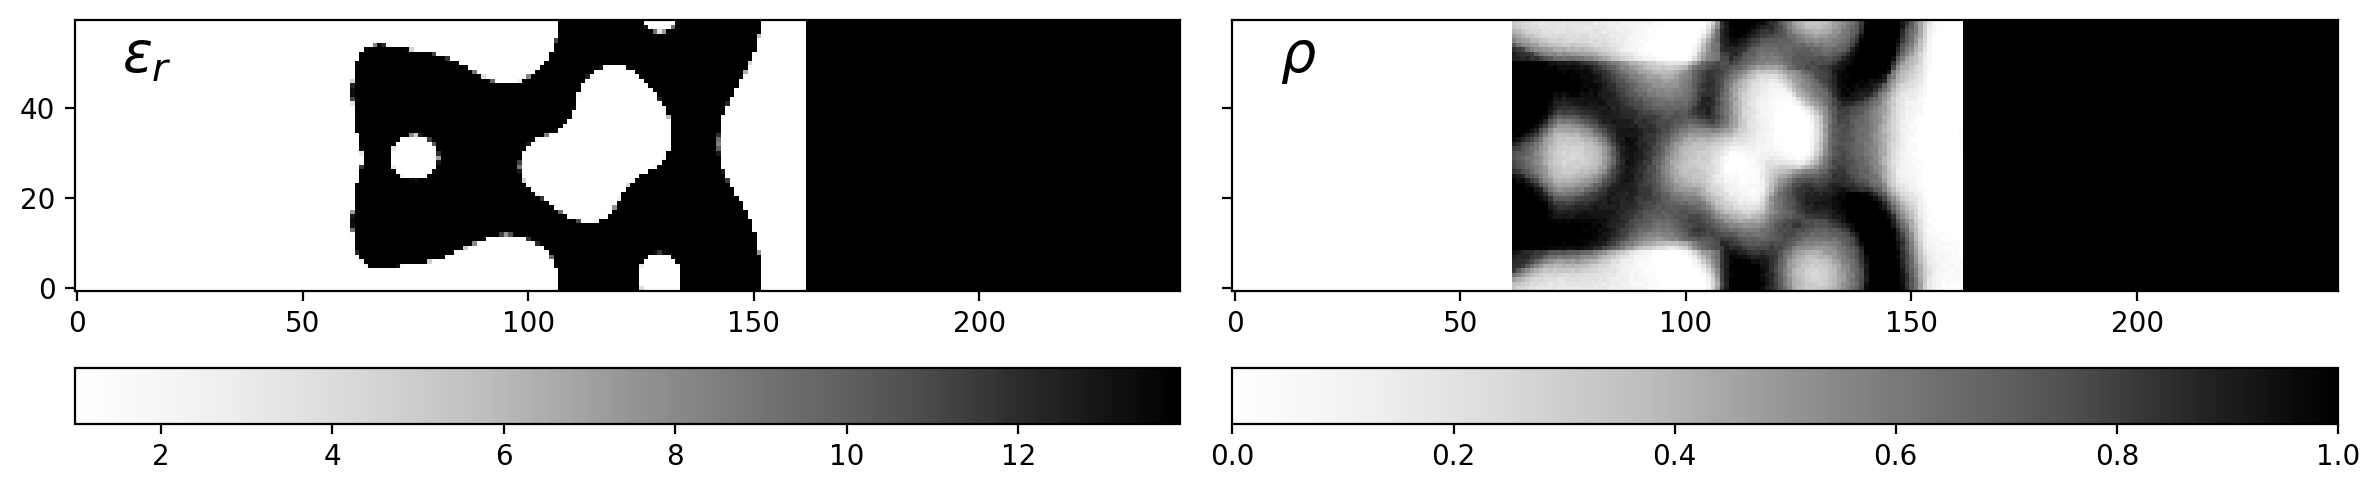

Epoch:  89/100 | Duration: 4.96 secs | Value: 1.656141e-01


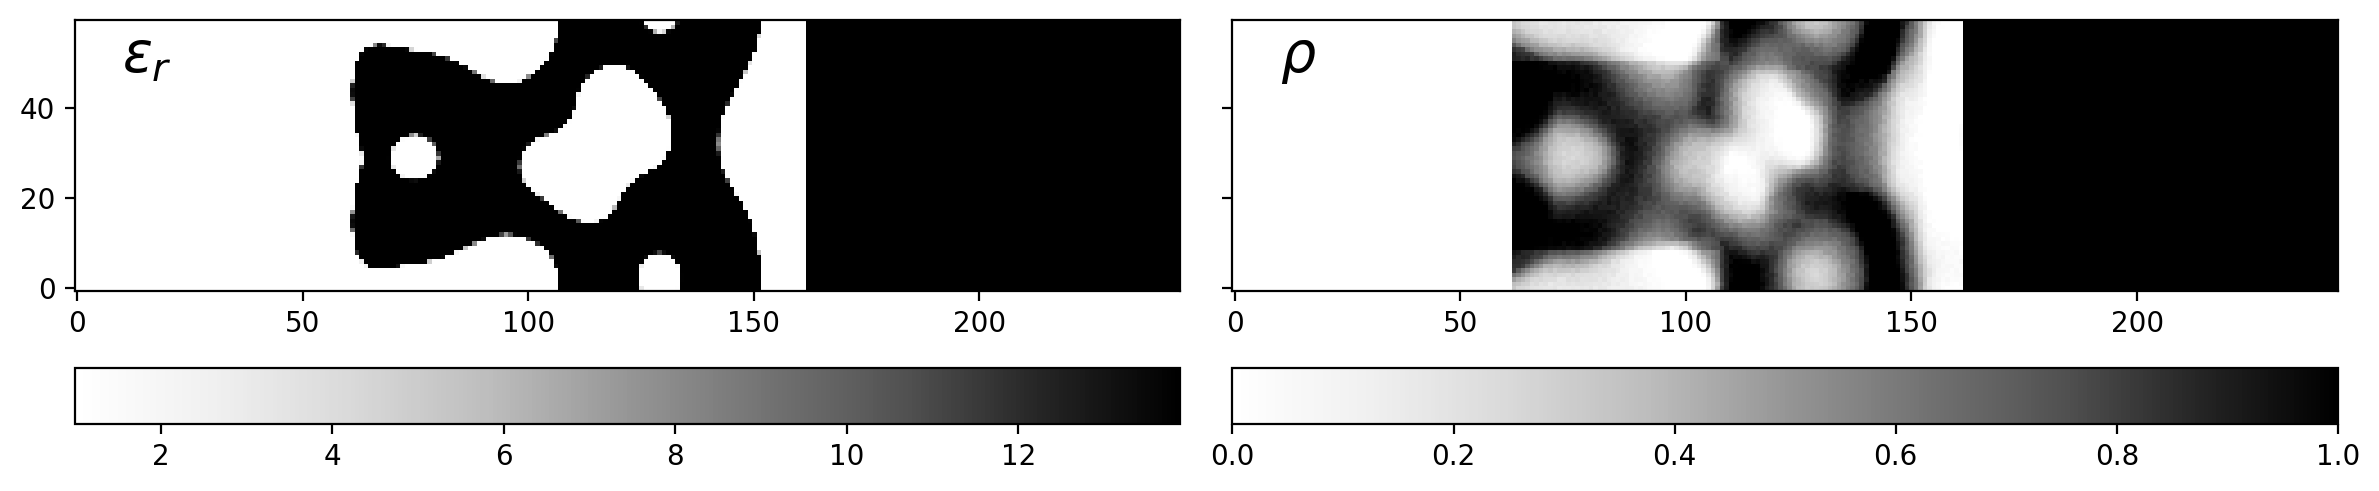

Epoch:  90/100 | Duration: 5.24 secs | Value: 1.707868e-01


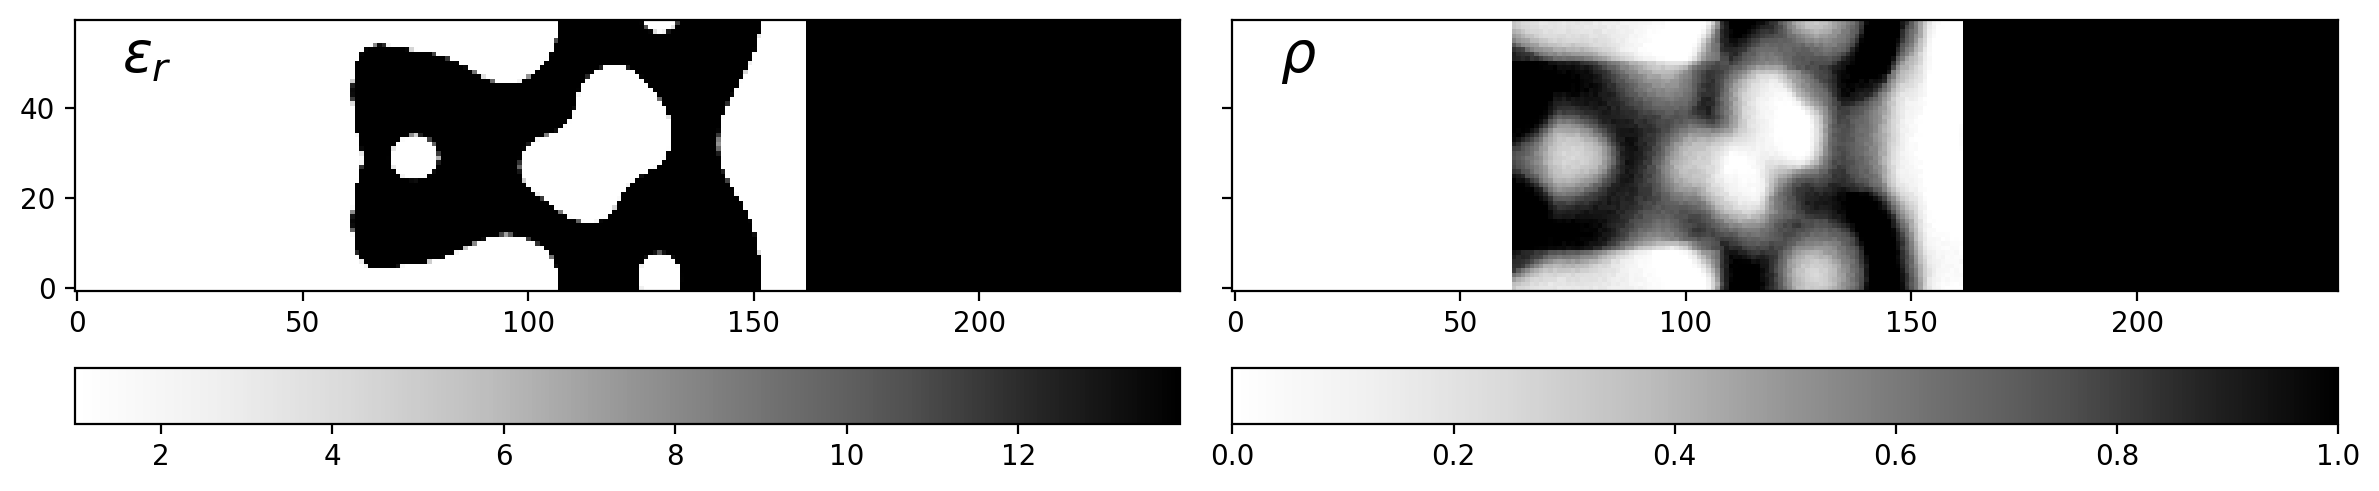

Epoch:  91/100 | Duration: 4.75 secs | Value: 1.754452e-01


Epoch:  92/100 | Duration: 4.88 secs | Value: 1.794786e-01


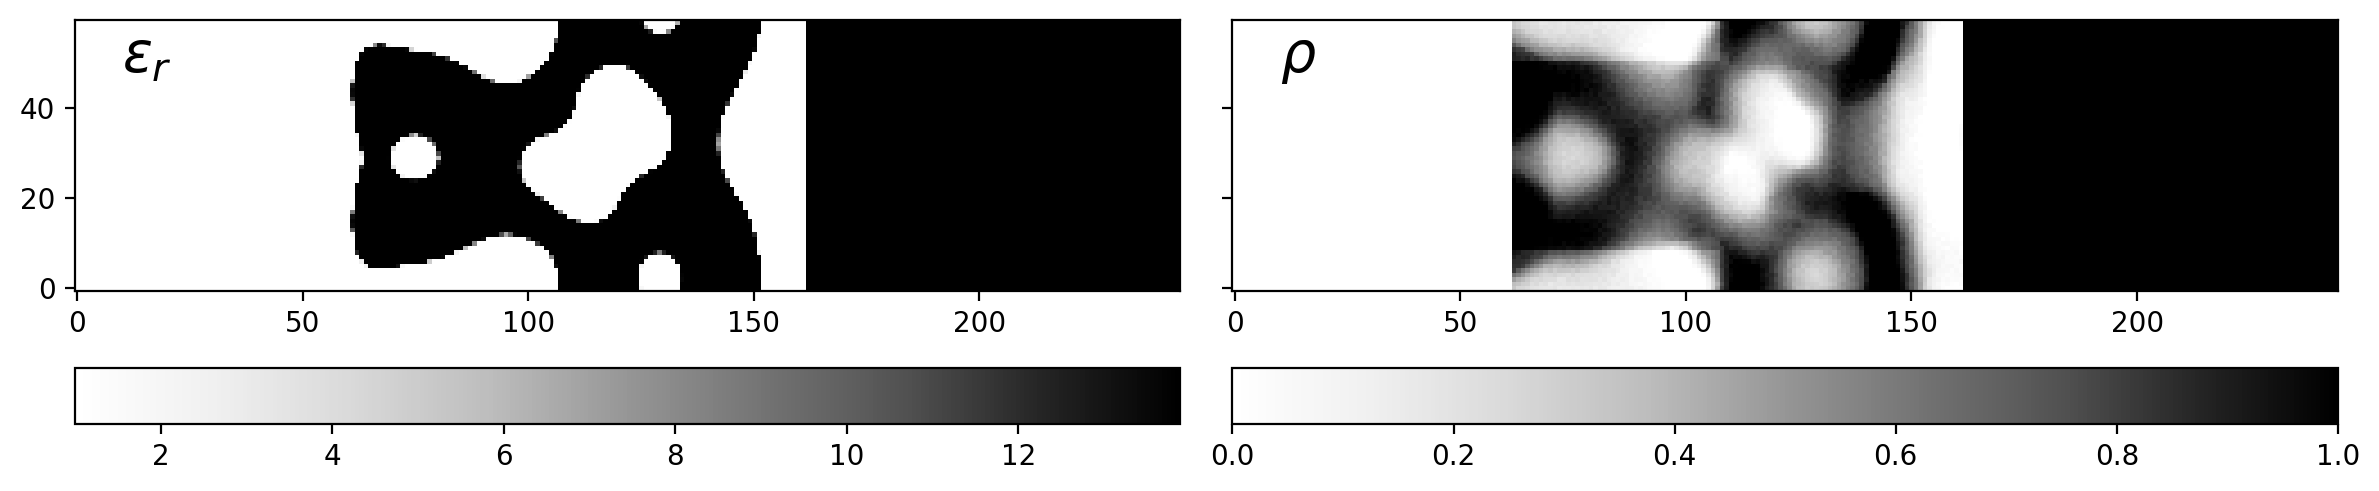

Epoch:  93/100 | Duration: 5.67 secs | Value: 1.831663e-01


Epoch:  94/100 | Duration: 6.07 secs | Value: 1.867722e-01


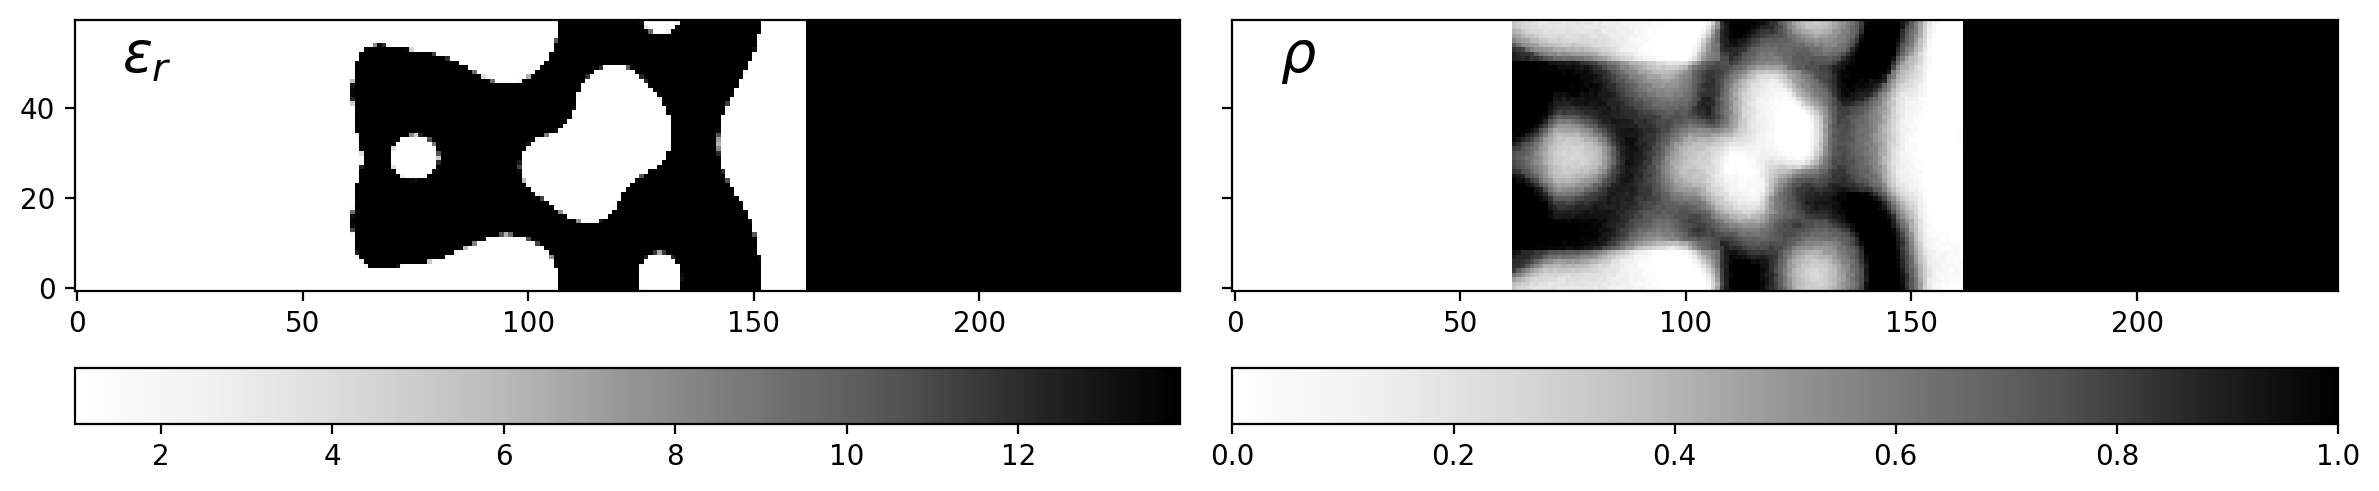

Epoch:  95/100 | Duration: 5.48 secs | Value: 1.903514e-01


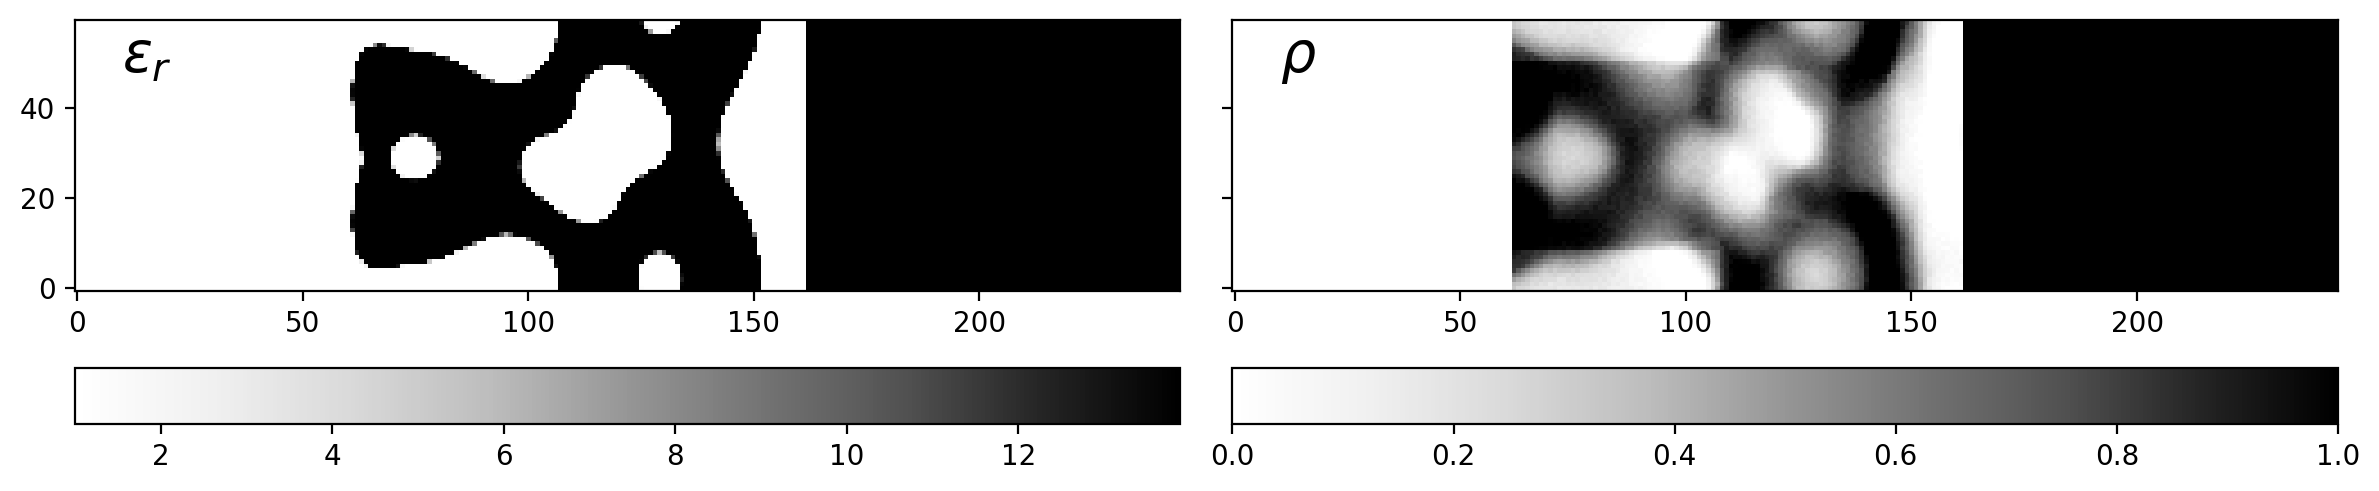

Epoch:  96/100 | Duration: 5.69 secs | Value: 1.939148e-01


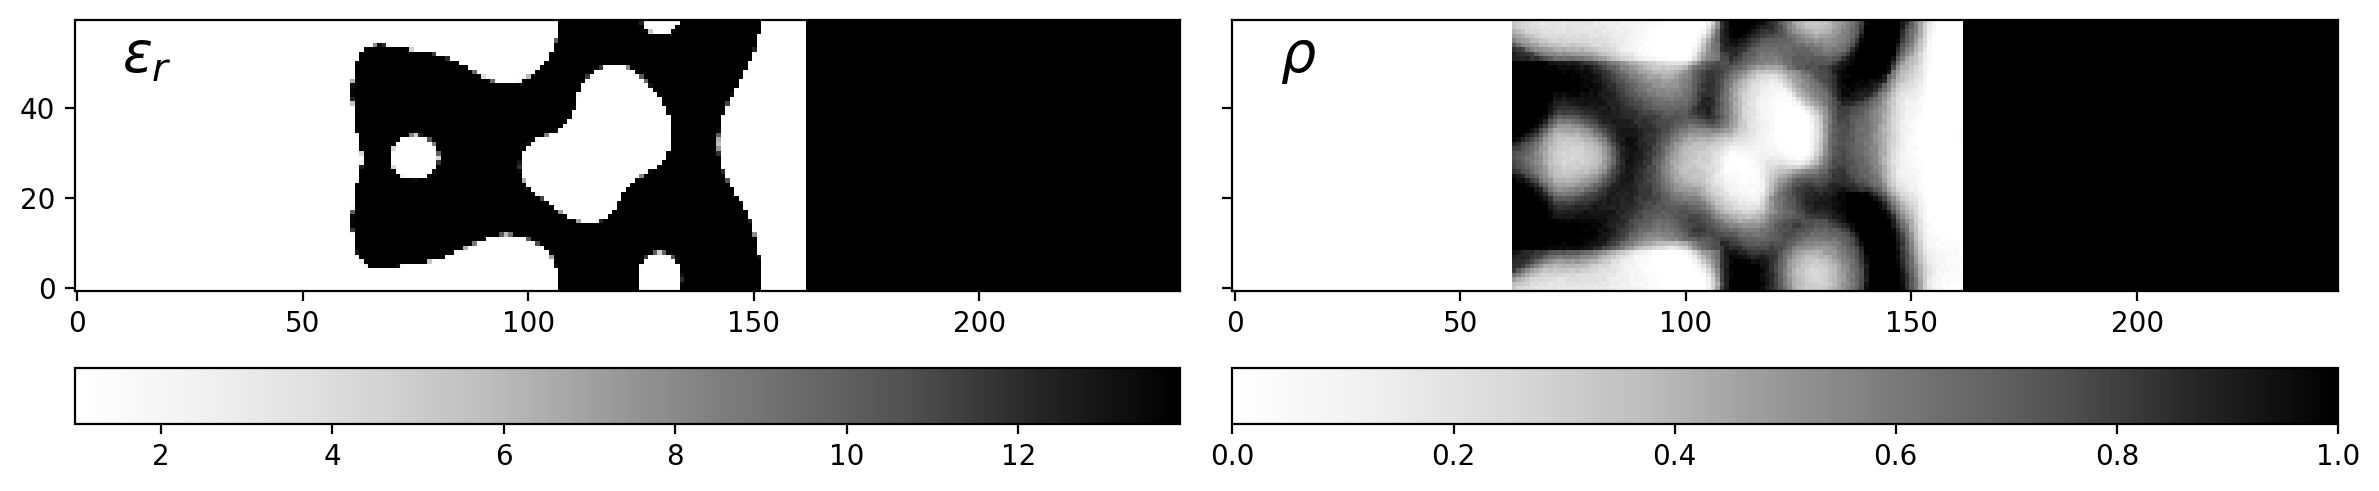

Epoch:  97/100 | Duration: 5.78 secs | Value: 1.975257e-01


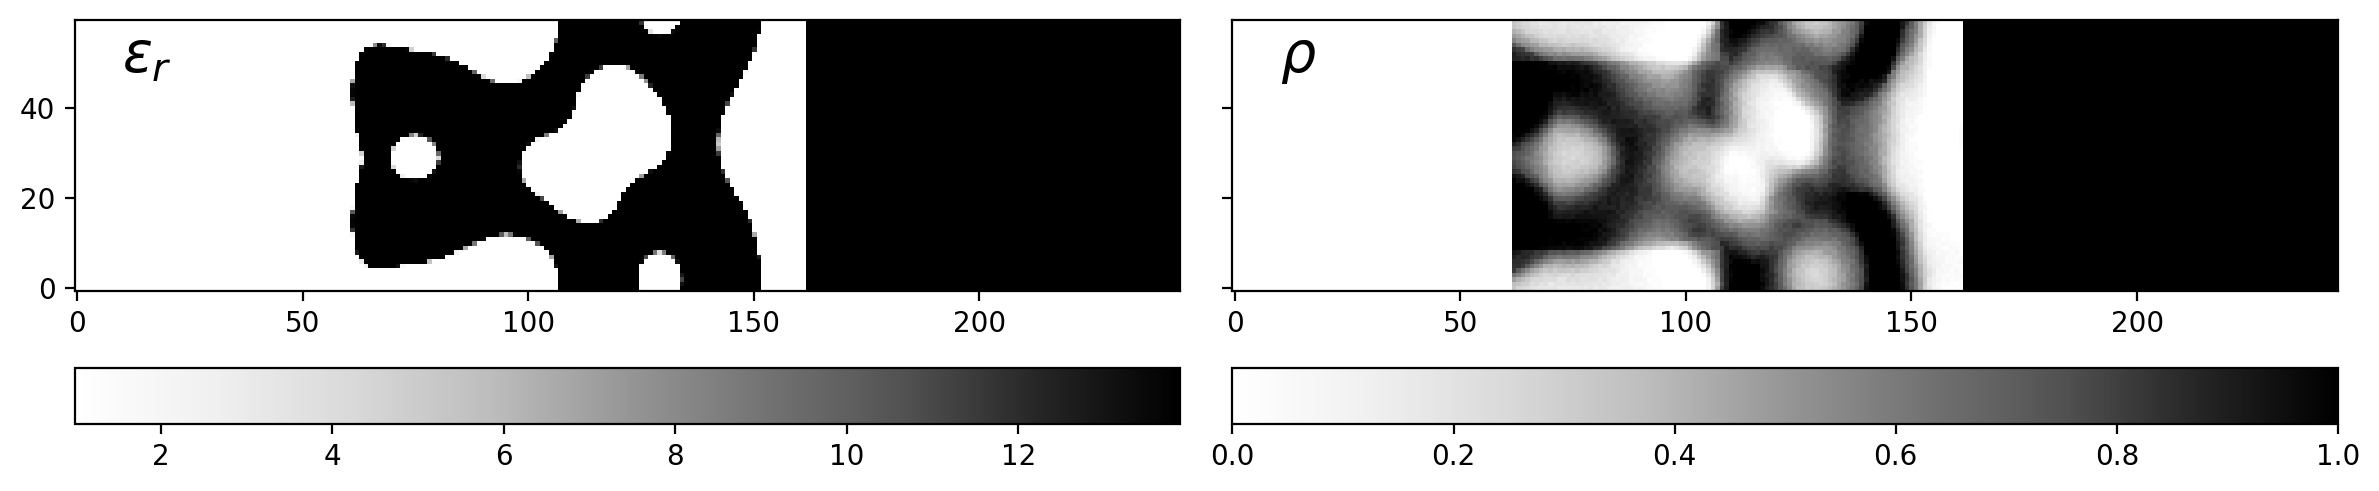

Epoch:  98/100 | Duration: 5.42 secs | Value: 2.012123e-01


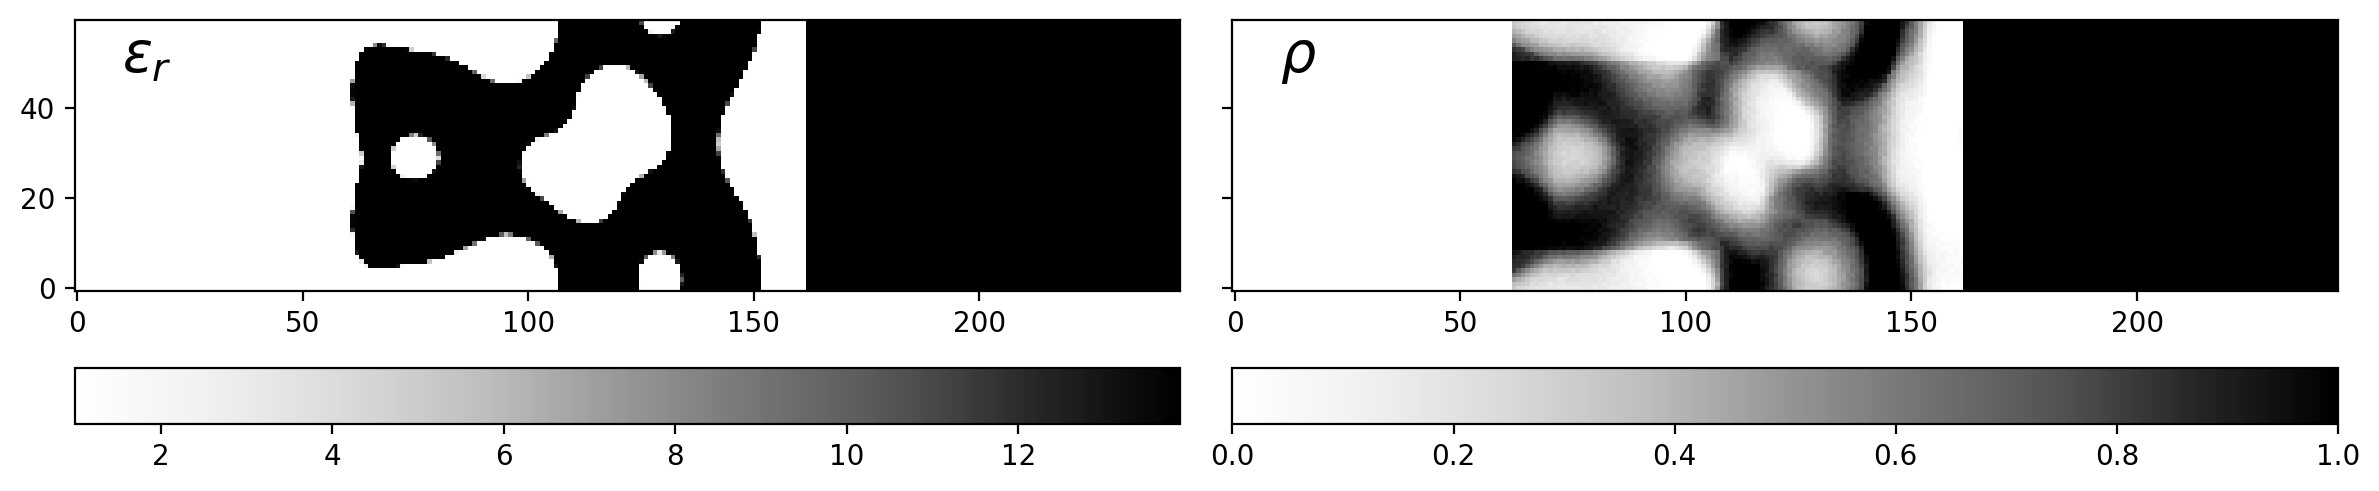

Epoch:  99/100 | Duration: 5.76 secs | Value: 2.049439e-01


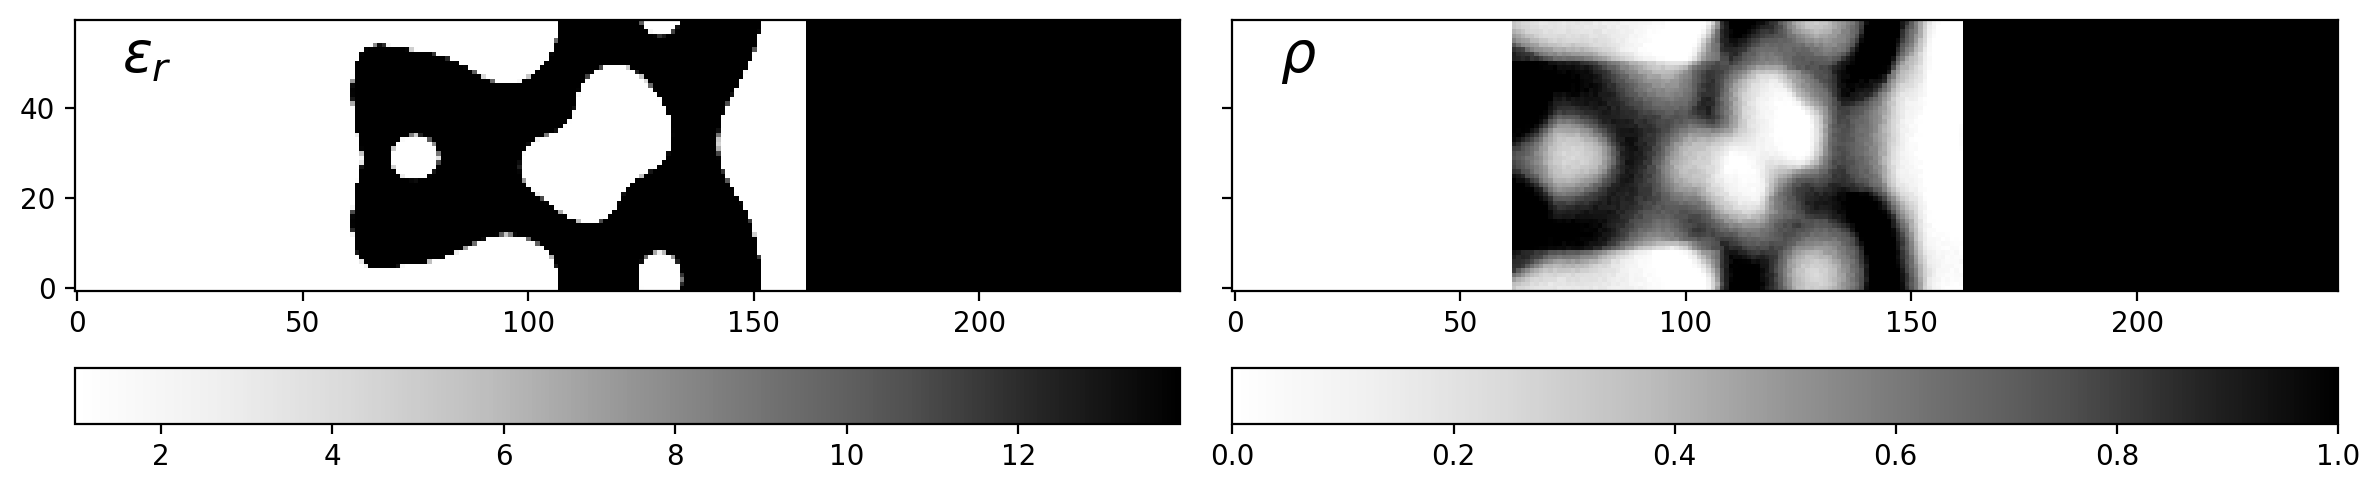

Epoch: 100/100 | Duration: 5.59 secs | Value: 2.086799e-01


In [85]:
# Compute the gradient of the objective function using reverse-mode differentiation
objective_jac = jacobian(objective, mode='reverse')

# Maximize the objective function using an ADAM optimizer
(rho_optimum, loss) = adam_optimize(objective, rho.flatten(), objective_jac,
                                     Nsteps=Nsteps, direction='max', step_size=step_size, callback=callback_beta_schedule)

# Simulate the optimal device
rho_optimum = rho_optimum.reshape((Nx, Ny))

<AxesSubplot:xlabel='x', ylabel='y'>

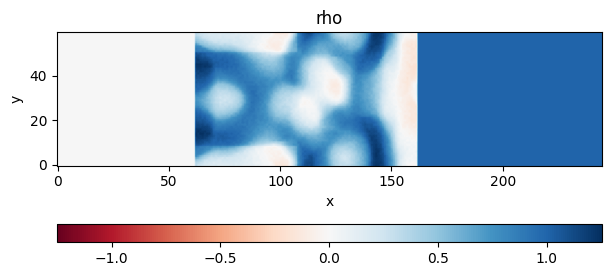

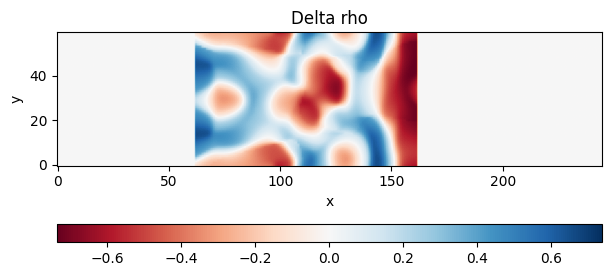

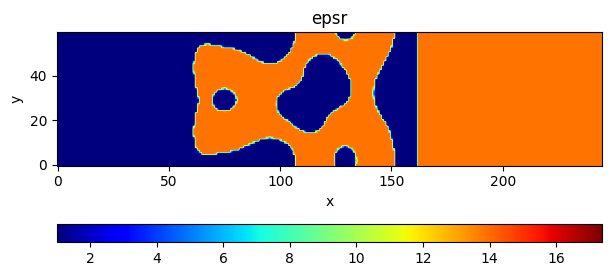

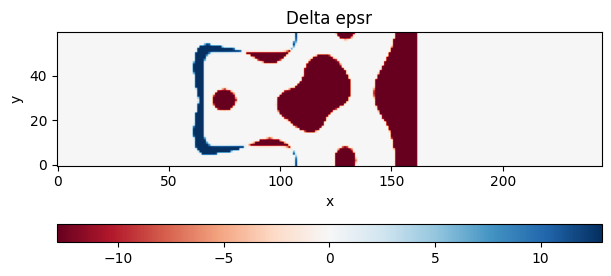

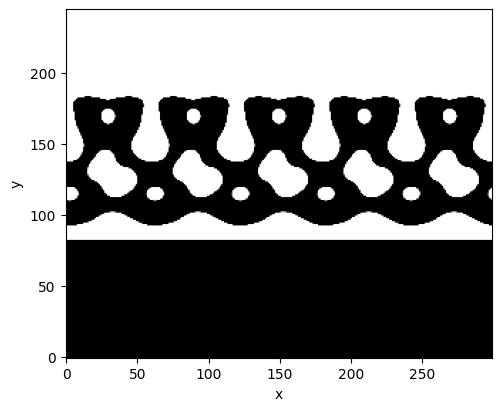

In [86]:
plot_rho = ceviche.viz.real(rho_optimum, DK_title='rho', cbar=True)
ceviche.viz.real(rho_optimum - rho, DK_title='Delta rho', cbar=True)
epsr_optimum = epsr_parameterization(
    rho_optimum, bg_rho, design_region, epsr_min, epsr_max, radius=blur_radius, N_blur=N_blur, beta=beta_proj, eta=eta_proj, N_proj=N_proj)
viz_epsr(epsr_optimum)
ceviche.viz.real(epsr_optimum - epsr, cbar=True, DK_title="Delta epsr")
ceviche.viz.real(np.concatenate([epsr_optimum[::-1] for i in range(5)], axis=1).T, cmap='Greys', DK_min=1)


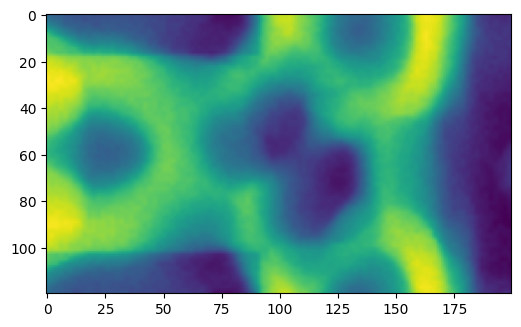

In [87]:
def regrid(data, out_x, out_y):
    m = max(data.shape[0], data.shape[1])
    y = np.linspace(0, 1.0/m, data.shape[0])
    x = np.linspace(0, 1.0/m, data.shape[1])
    interpolating_function = RegularGridInterpolator((y, x), data)

    yv, xv = np.meshgrid(np.linspace(0, 1.0/m, out_y), np.linspace(0, 1.0/m, out_x))

    return interpolating_function((xv, yv))

rho_regrid = regrid(rho_optimum[x1:x2,:], 2*rho_optimum[x1:x2,:].shape[0], 2*rho_optimum[x1:x2,:].shape[1])
plt.imshow(rho_regrid.T)

In [88]:
# beta_proj = 200

# rho_optimum = rho
# rho_optimum[x1:x2,:] = rho_regrid
# epsr_optimum = epsr_parameterization(
#     rho_optimum, bg_rho, design_region, epsr_min, epsr_max, radius=blur_radius, N_blur=N_blur, beta=beta_proj, eta=eta_proj, N_proj=N_proj)
# viz_epsr(epsr_optimum)

In [90]:
omega = frequencies[0]
simulation = ceviche.fdfd_hz(omega, dl, epsr_optimum, [Npml, 0], bloch_phases=[0, -(omega/(beta*C_0)*a)])
Ex, Ey, Hz = simulation.solve(source_tmp_list[0])
Ey = Ey - current_list[0] / (EPSILON_0 * 1j * omega)

In [91]:
def concatenate(arr, n, bloch_phase):
    arr2 = arr

    for _ in range(n-1):
        arr2 = arr2 * np.exp(1j*bloch_phase)
        arr = np.concatenate((arr, arr2), axis=1)

    return arr

<AxesSubplot:title={'center':'Hz'}, xlabel='x', ylabel='y'>

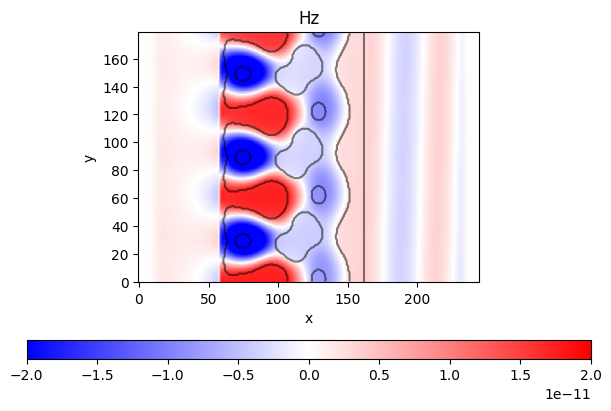

In [92]:
H_conc = concatenate(Hz, 3, bloch_phase=-(omega/(beta*C_0)*a))
epsr_conc = np.concatenate([epsr_optimum for i in range(3)], axis=1)
ceviche.viz.real(H_conc, DK_title='Hz', DK_max=2e-11, outline=epsr_conc, cbar=True, cmap='bwr')

In [93]:
# epsr_optimum = epsr_parameterization(
#     rho_optimum, bg_rho, design_region, epsr_min, epsr_max, radius=blur_radius, N_blur=N_blur, beta=beta_proj, eta=eta_proj, N_proj=N_proj)
# delta_rho = rho_optimum - rho_initial

# # save the structure to txt
# np.savetxt("saved_structures\\MT\\rho_optimal_Si.txt", rho_optimum)
# np.savetxt("saved_structures\\MT\\epsr_optimal_Si.txt", epsr_optimum)
# np.savetxt("saved_structures\\MT\\drho_optimal_Si.txt", delta_rho)

In [94]:
# # load the structure from txt
# rho = np.loadtxt("saved_structures\\MT\\rho_optimal_Si.txt")
# rho = np.loadtxt("saved_structures\\schedule\\rho_72.txt")
# epsr = np.loadtxt("saved_structures\\MT\\epsr_optimal_Si.txt")

In [95]:
def viz_epsr_rho_gif(epsr, rho):
    fig, axs = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(12, 3), dpi=200, tight_layout=True)
    er = axs[0].imshow(epsr.T, cmap='Greys', origin='lower')
    rh = axs[1].imshow(np.real(rho).T, cmap='Greys', origin='lower', vmin=0, vmax=1)

    # text
    axs[0].text(10, Ny - Ny//5, r"$\varepsilon_r$", fontsize=20)
    axs[1].text(10, Ny - Ny//5, r"$\rho$", fontsize=20)

    # colorbars
    cbar_er = plt.colorbar(er, ax=axs[0], orientation="horizontal", aspect=20)
    plt.colorbar(rh, ax=axs[1], orientation="horizontal", aspect=20)

In [96]:
def animate(Nframes, gif_name="mygif"):
    filenames = []

    for iteration in range(Nframes):
        rho_it = np.loadtxt(f"saved_structures\\schedule\\rho_{iteration}.txt")
        epsr_it = epsr_parameterization(rho_it, bg_rho, design_region, epsr_min, epsr_max,
                                                radius=blur_radius, N_blur=N_blur, beta=beta_proj, eta=eta_proj, N_proj=N_proj)
        viz_epsr_rho_gif(epsr_it, rho_it)
        filename = f"saved_structures\\schedule\\{iteration}.png"
        filenames.append(filename)
        plt.savefig(filename, dpi=200)
        plt.close()

    # build gif
    with imageio.get_writer(f'saved_structures\\schedule\\{gif_name}.gif', mode='I') as writer:
        print('Creating gif...')
        for filename in filenames:
            image = imageio.imread(filename)
            writer.append_data(image)
        print('Gif saved\n')

    # Remove files
    for filename in set(filenames):
        os.remove(filename)


In [ ]:
animate(Nsteps, gif_name='Si_optimization');